In [1]:
dataset_name = "W14_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

from IPython.display import display, display_html, HTML
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

import Jupyter_module_loader
from utility import *
import gaussian_kde
# display_components, display_pca_data, weighted_kde, setup_directories,\
#                     get_manifest, get_small_files, clean_filename, create_subdir, amalgamate_waves

In [3]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()




In [4]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

var_type (5692, 13)


In [5]:
def sort_by_wave(lst):
    dict_by_wave = {int(x.split("W")[-1]):x for x in lst}
    return [dict_by_wave[x] for x in sorted(dict_by_wave.keys())]
    

In [6]:
max_wave, num_to_wave, num_to_weight, weights = get_weights(dataset_name,BES_Panel)

In [7]:
# search(BES_Panel,'edlevel')

In [8]:
# mean weights?
# maybe as part of amalgamation?
# BES_Panel[ num_to_weight[8] ]



In [9]:
def get_all_weights(mask, specific_wave = None):

    if specific_wave is None:
        wts = BES_Panel[list(num_to_weight.values())][mask]
    else:
        wts = BES_Panel[specific_wave][mask]

    wts = wts/wts.mean()

    wts = wts.mean(axis=1)
    wts =wts/wts.mean()
    return wts


In [10]:
def nice_bar_plot(ser1, ser2, normalize = 'columns', sort_labels=False, output_folder = BES_output_folder,
                  text_width=8, text_fontsize=14, min_sample_size=100, title=None, drop_insig=True, fuckErrors=True,
                  mask=1, title_fontsize=14):
    var1 = ser1.name
    var2 = ser2.name
    
    mask = ser1.notnull() & ser2.notnull() & mask
    ct = pd.crosstab( ser1, ser2,
                      values= get_all_weights(mask), aggfunc=sum, normalize=normalize)*100
    if sort_labels:
        sorted_labels = list(ser2.value_counts().index)
    else:
        sorted_labels = list(ser2.cat.categories)
           

    unweighted = pd.crosstab( ser1, ser2 )
    errors = 100 * np.sqrt(unweighted)/unweighted     

    labels_by_sample_size = {unweighted.sum().values[x]:sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))}    
    labels_by_sample_size = {sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")":unweighted.sum().values[x] for x in range(0,len(sorted_labels))}    
    labels_restricted = [x for x in labels_by_sample_size.keys() if labels_by_sample_size[x] > min_sample_size] 
#     return labels_by_sample_size, labels_restricted
    if drop_insig:
        rubbish_entries = ct<errors
        ct[rubbish_entries]=np.nan
        errors[rubbish_entries]=np.nan
#     return(sorted_labels, errors, labels_by_sample_size)
    all_nan_rows = ~errors.isnull().any(axis=1)
    errors.columns = list( labels_by_sample_size.keys() )
   
    ct.columns = list( labels_by_sample_size.keys() )
    ct = ct.loc[all_nan_rows, labels_restricted]
#     return errors, labels_restricted
    errors = errors.loc[all_nan_rows, labels_restricted]
#     errors=errors.T
#     return errors
#     return errors, ct
    treatment = var2 +" by " + var1
    output_subfolder = create_subdir(output_folder, treatment)
    
    import textwrap 

    wrapper = textwrap.TextWrapper(width=text_width) 

    stacked = ct.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    err_stacked = errors.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    fig = plt.figure(figsize=(20, 8))
    ax = fig.subplots()

#     a = [np.ones(16),np.ones(16)]
#     a = errors.values
#     return a
#     iter(a)    
    
    stacked[var1] = stacked[var1].apply( lambda x: x +" (N="+str(unweighted.sum(axis=1).loc[x])+")" )
    stacked[var1].cat.set_categories(stacked[var1].cat.categories[all_nan_rows],inplace=True)
#     return stacked
#     return stacked['%'].shape,err_stacked["%"].values.reshape(len(stacked),1).shape
    if fuckErrors:
        sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted);
    else:
        sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted,
                    yerr = errors.values);        
                    # err_stacked["%"].values );
# .reshape(len(stacked),1)
    if title is None:
        title = var2 +" by " + var1
    plt.title(title, fontsize=title_fontsize)
    sorted_labels = [sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))]
    ax.set_xticklabels([ wrapper.fill(text=x) for x in labels_restricted], rotation=0, fontsize=text_fontsize);

    ax.annotate(dataset_citation, (0,0), (0, -140),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
    fname = output_subfolder + clean_filename(title) + ".png"
    fig.savefig( fname, bbox_inches='tight' )    

In [24]:
search(BES_reduced_with_na,"lr_scale" ,mask=BES_reduced_with_na["profile_eurefvote_Leave the EU"].notnull())

lr_scaleW7W8W9__Right        30964
lr_scaleW6__Right            20914
lr_scaleW1W2W3W4W5__Right    22963
lr_scaleW10W11W12__Right     27381
lr_scaleW13__Right           25962
lr_scaleW14__Right           25226
dtype: int64

In [25]:
## THEN VALUES x THEN EUREFVOTE
BES_reduced_with_na["lr_scaleW7W8W9__Right"].corr(BES_reduced_with_na["profile_eurefvote_Leave the EU"])

0.04734530040850964

In [22]:
## NOW VALUES x THEN EUREFVOTE
BES_reduced_with_na["lr_scaleW14__Right"].corr(BES_reduced_with_na["profile_eurefvote_Leave the EU"])

0.09827926433068467

In [20]:
## NOW VALUES x NOW EUREFVOTE PREFERENCE
BES_reduced_with_na["lr_scaleW14__Right"].corr(BES_reduced_with_na["euRefVoteW14_Leave the EU"])

0.15581822179578167

Warning, filename truncated because it was over 30. Filenames may no longer be unique


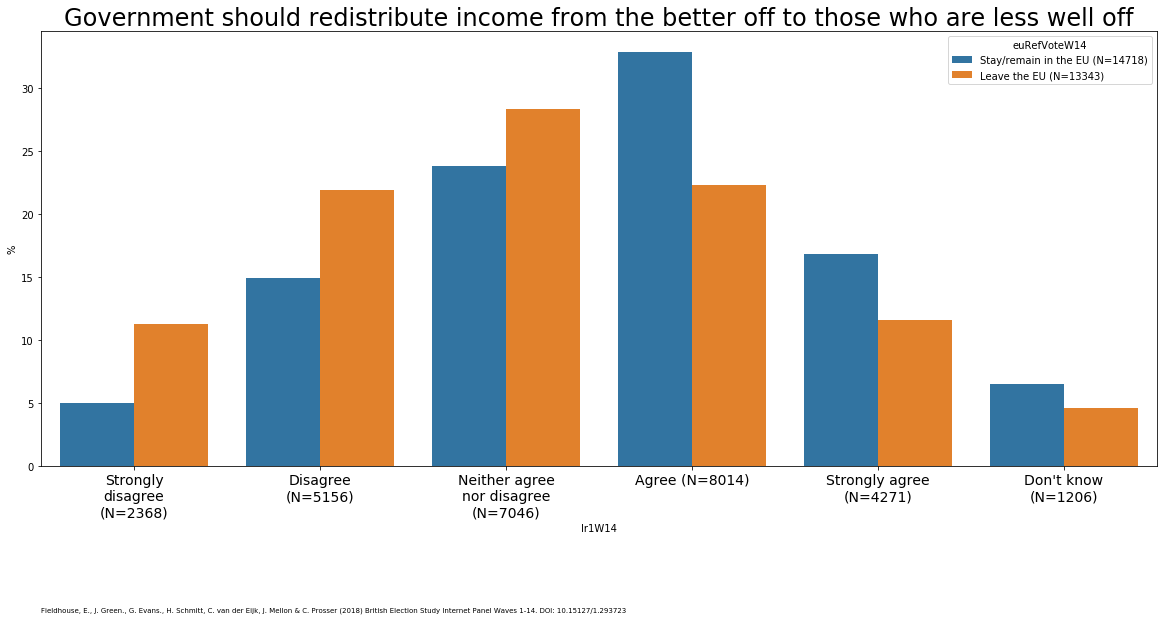

In [12]:
var2 ="lr1W14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2
# mask = BES_Panel["workingStatusW6_W12"]!="Retired"
# mask = BES_Panel["ageW13"] <65
# mask = BES_Panel["profile_house_tenureW13"]==BES_Panel["profile_house_tenureW13"].cat.categories[0]

df1 = BES_Panel[var1].cat.remove_categories(['I would/will not vote', "Don't know"])
df2 = BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])
# df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories])

nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              text_width = 14,
              title_fontsize=24,
              title="Government should redistribute income from the better off to those who are less well off")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


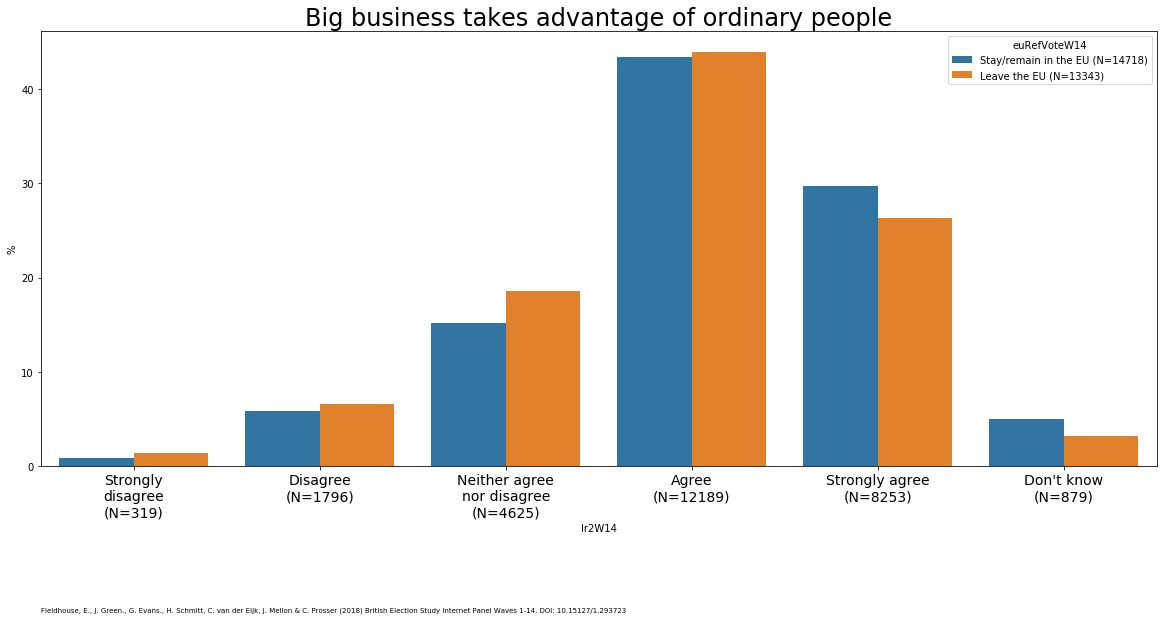

In [13]:
var2 ="lr2W14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2
# mask = BES_Panel["workingStatusW6_W12"]!="Retired"
# mask = BES_Panel["ageW13"] <65
# mask = BES_Panel["profile_house_tenureW13"]==BES_Panel["profile_house_tenureW13"].cat.categories[0]

df1 = BES_Panel[var1].cat.remove_categories(['I would/will not vote', "Don't know"])
df2 = BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])
# df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories])

nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              text_width = 14,
              title_fontsize=24,
              title="Big business takes advantage of ordinary people")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


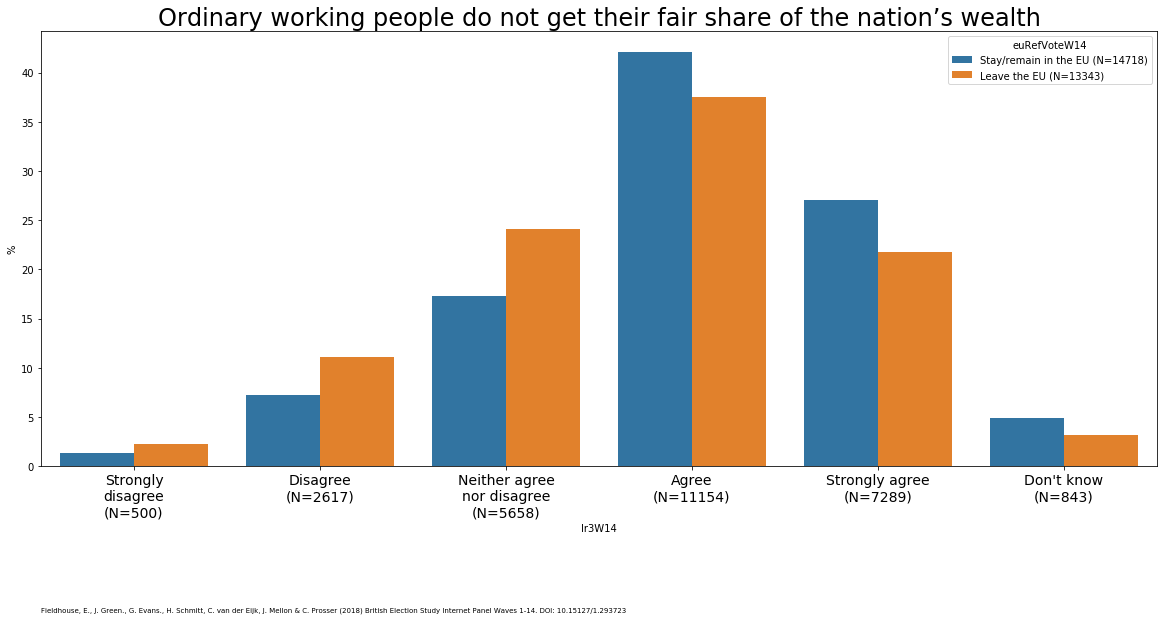

In [14]:
var2 ="lr3W14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2
# mask = BES_Panel["workingStatusW6_W12"]!="Retired"
# mask = BES_Panel["ageW13"] <65
# mask = BES_Panel["profile_house_tenureW13"]==BES_Panel["profile_house_tenureW13"].cat.categories[0]

df1 = BES_Panel[var1].cat.remove_categories(['I would/will not vote', "Don't know"])
df2 = BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])
# df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories])

nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              text_width = 14,
              title_fontsize=24,
              title="Ordinary working people do not get their fair share of the nation’s wealth")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


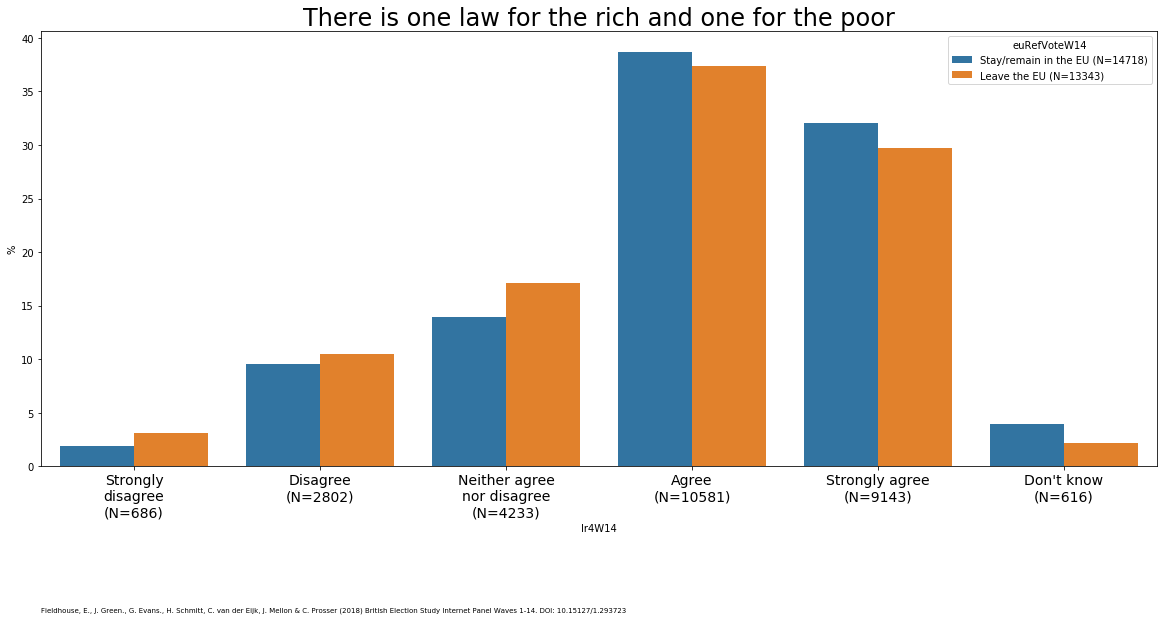

In [15]:
var2 ="lr4W14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2
# mask = BES_Panel["workingStatusW6_W12"]!="Retired"
# mask = BES_Panel["ageW13"] <65
# mask = BES_Panel["profile_house_tenureW13"]==BES_Panel["profile_house_tenureW13"].cat.categories[0]

df1 = BES_Panel[var1].cat.remove_categories(['I would/will not vote', "Don't know"])
df2 = BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])
# df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories])

nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              text_width = 14,
              title_fontsize=24,
              title="There is one law for the rich and one for the poor")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


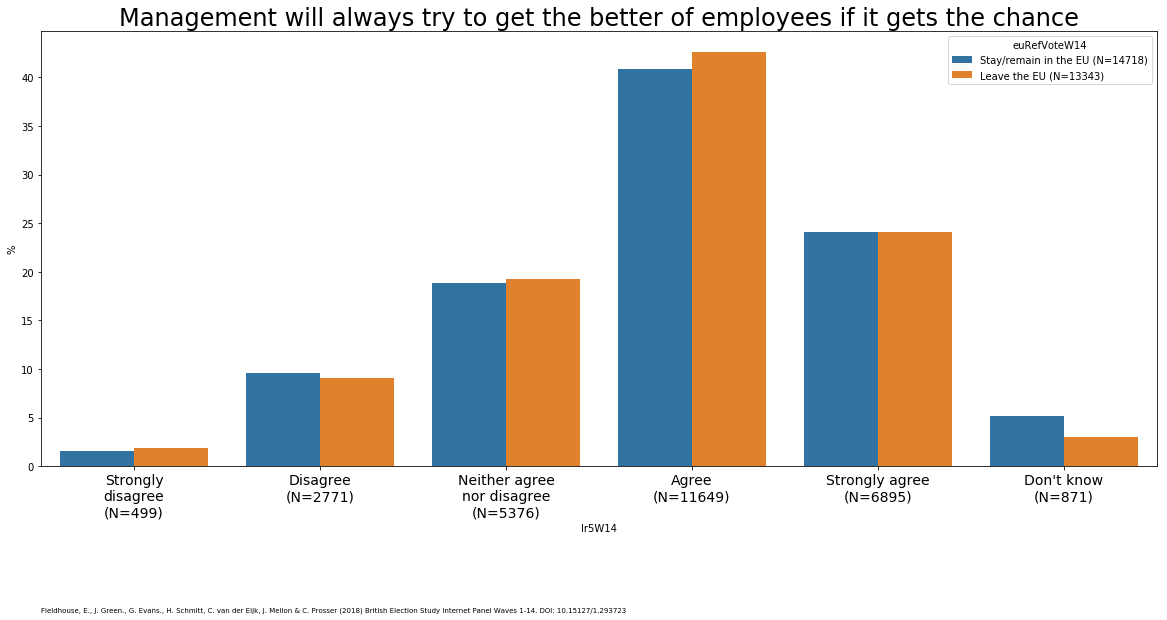

In [16]:
var2 ="lr5W14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2
# mask = BES_Panel["workingStatusW6_W12"]!="Retired"
# mask = BES_Panel["ageW13"] <65
# mask = BES_Panel["profile_house_tenureW13"]==BES_Panel["profile_house_tenureW13"].cat.categories[0]

df1 = BES_Panel[var1].cat.remove_categories(['I would/will not vote', "Don't know"])
df2 = BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])
# df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories])

nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              text_width = 14,
              title_fontsize=24,
              title="Management will always try to get the better of employees if it gets the chance")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


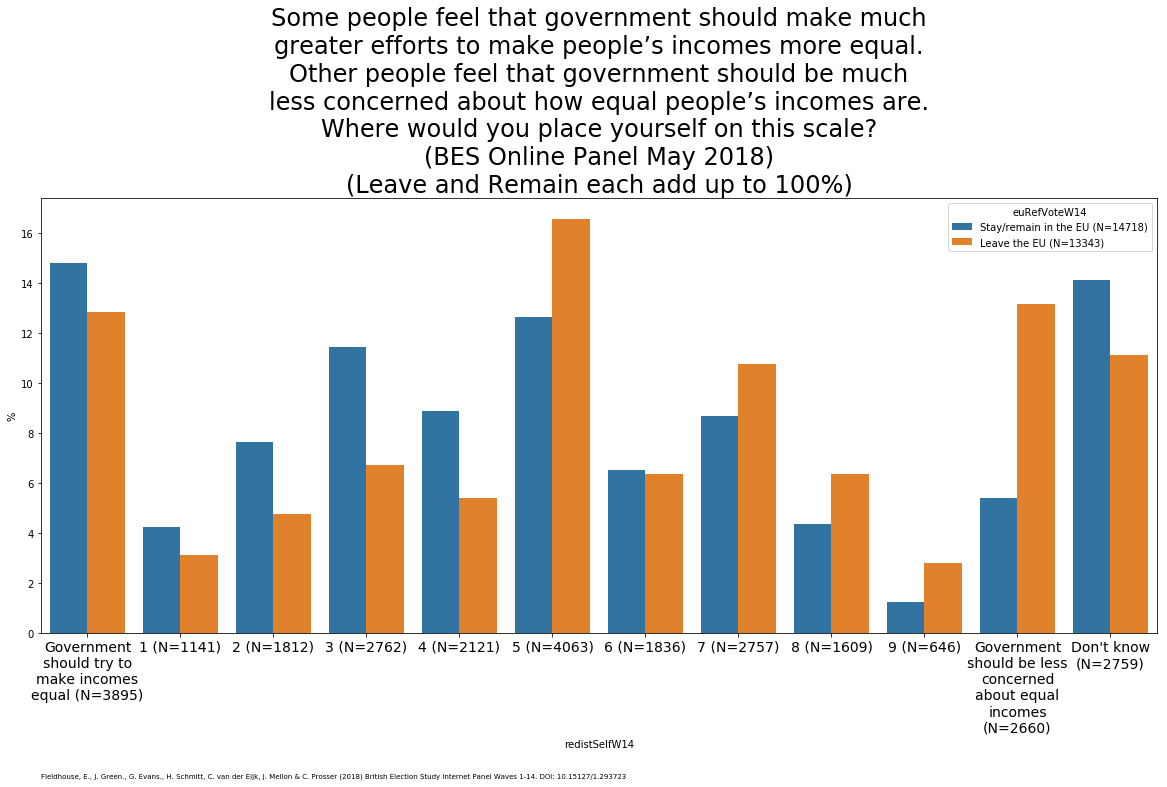

In [20]:
var2 ="redistSelfW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2
# mask = BES_Panel["workingStatusW6_W12"]!="Retired"
# mask = BES_Panel["ageW13"] <65
# mask = BES_Panel["profile_house_tenureW13"]==BES_Panel["profile_house_tenureW13"].cat.categories[0]

df1 = BES_Panel[var1].cat.remove_categories(['I would/will not vote', "Don't know"])
df2 = BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])
# df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories])

nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              text_width = 14,
              title_fontsize=24,
              title="Some people feel that government should make much\ngreater efforts to make people’s incomes more equal.\nOther people feel that government should be much\nless concerned about how equal people’s incomes are.\nWhere would you place yourself on this scale?\n(BES Online Panel May 2018)\n(Leave and Remain each add up to 100%)")



In [21]:
# search(BES_reduced_with_na, "reDist")

In [43]:
BES_Panel["profile_house_tenureW13"].cat.categories[0]

'Own \x96 outright'

Warning, filename truncated because it was over 30. Filenames may no longer be unique


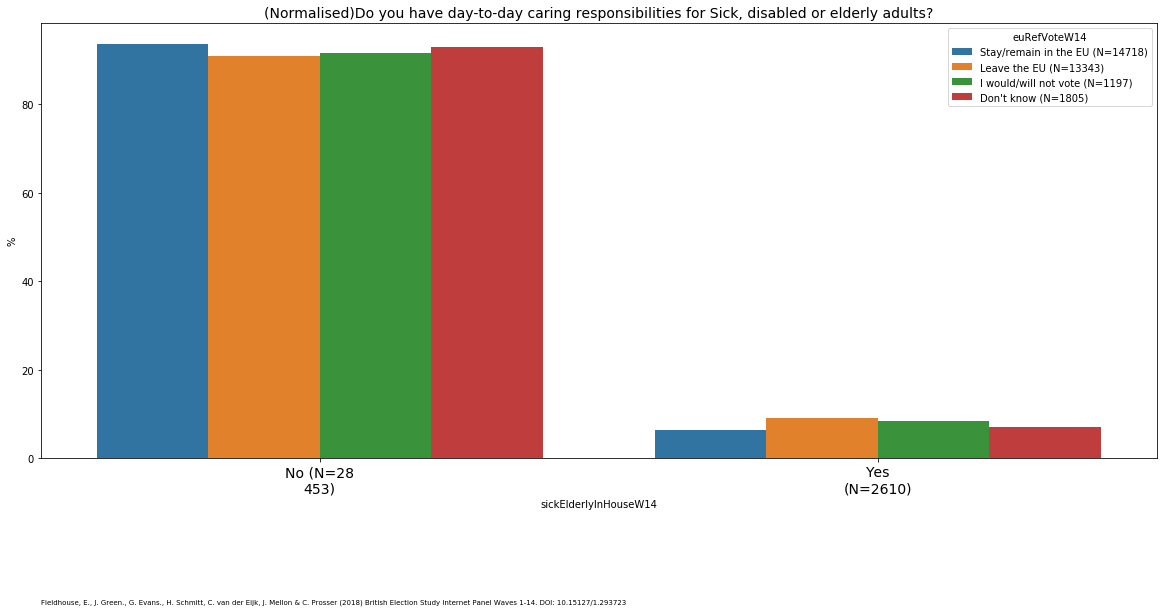

In [57]:
var2 ="sickElderlyInHouseW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2
# mask = BES_Panel["workingStatusW6_W12"]!="Retired"
# mask = BES_Panel["ageW13"] <65
# mask = BES_Panel["profile_house_tenureW13"]==BES_Panel["profile_house_tenureW13"].cat.categories[0]

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories])

nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
#               mask=mask,
              title="(Normalised)Do you have day-to-day caring responsibilities for Sick, disabled or elderly adults?")



Index(['Taxation', '2.0', '3.0', '4.0', 'Own money', 'Don't know'], dtype='object')

Warning, filename truncated because it was over 30. Filenames may no longer be unique


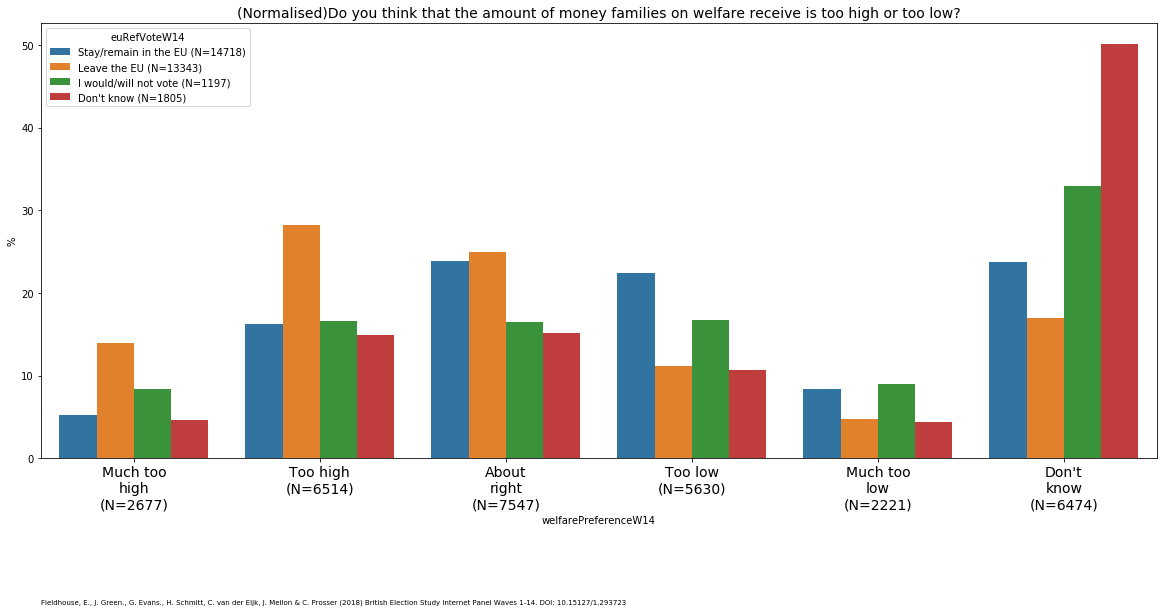

In [17]:
var2 ="welfarePreferenceW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
df2.cat.rename_categories([str(x) for x in df2.cat.categories])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)Do you think that the amount of money families on welfare receive is too high or too low?")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


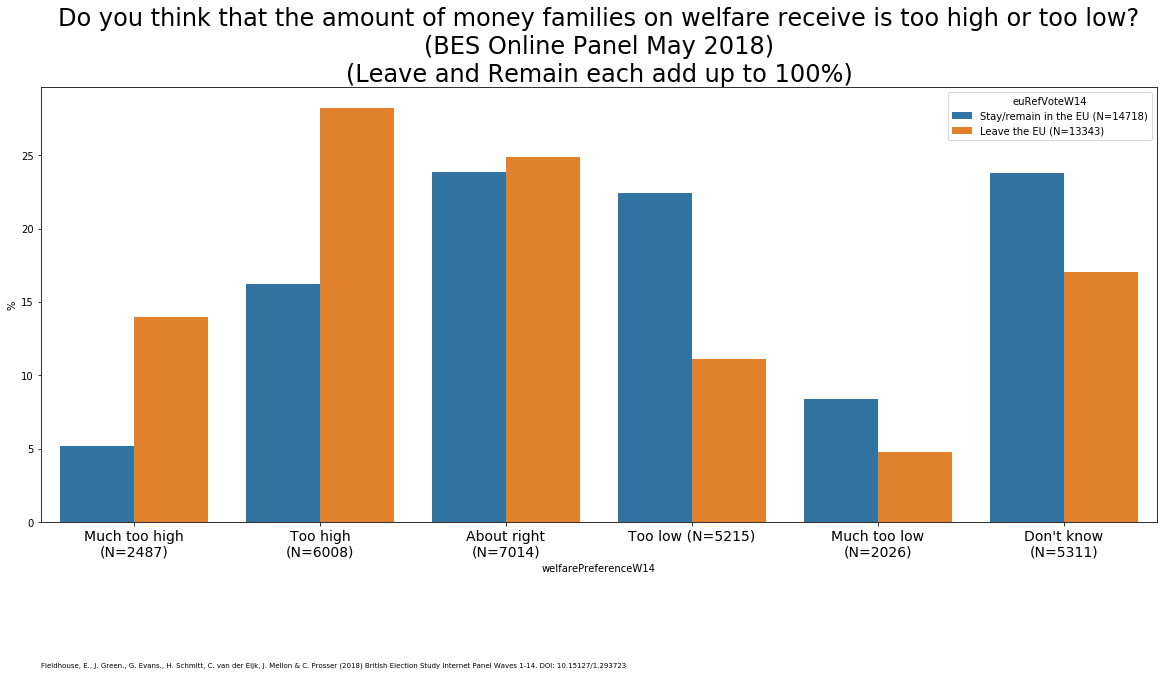

In [34]:
var2 ="welfarePreferenceW14"
var1 ="euRefVoteW14"

df1 = BES_Panel[var1].cat.remove_categories(['I would/will not vote', "Don't know"])
df2 = BES_Panel[var2]



nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              title_fontsize=24,
              text_width=16,
              title="Do you think that the amount of money families on welfare receive is too high or too low?\n(BES Online Panel May 2018)\n(Leave and Remain each add up to 100%)")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


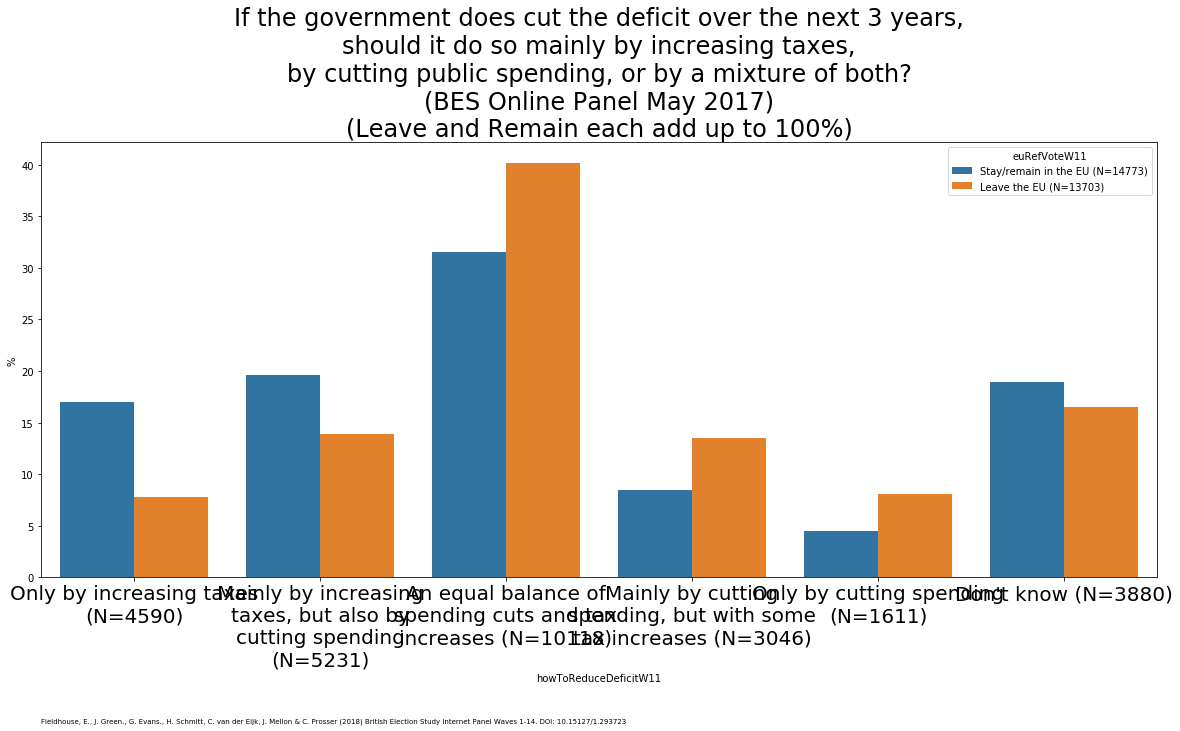

In [40]:
var2 ="howToReduceDeficitW11"
var1 ="euRefVoteW11"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1].cat.remove_categories(['I would/will not vote', "Don't know"])
df2 = BES_Panel[var2]  


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              title_fontsize=24,
              text_width=24, text_fontsize=20,
              title="If the government does cut the deficit over the next 3 years,\nshould it do so mainly by increasing taxes,\nby cutting public spending, or by a mixture of both?\n(BES Online Panel May 2017)\n(Leave and Remain each add up to 100%)")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


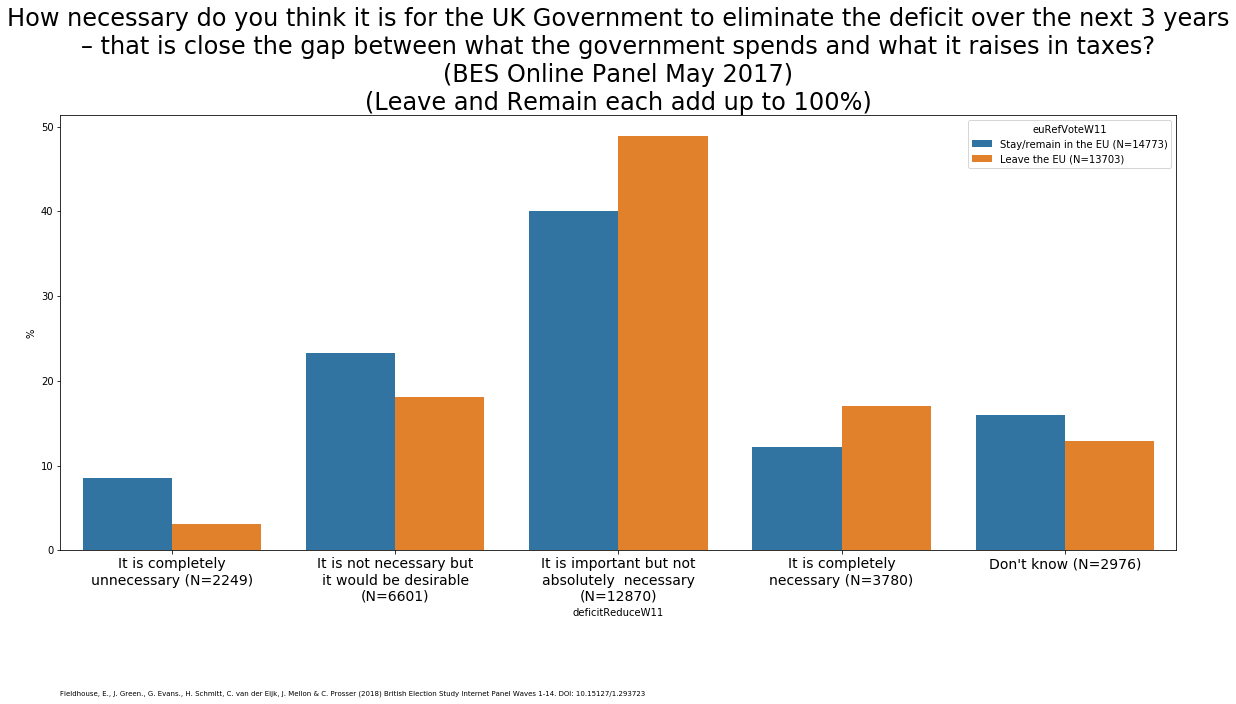

In [38]:
var2 ="deficitReduceW11"
var1 ="euRefVoteW11"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1].cat.remove_categories(['I would/will not vote', "Don't know"])
df2 = BES_Panel[var2]  


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              title_fontsize=24,
              text_width=24,
              title="How necessary do you think it is for the UK Government to eliminate the deficit over the next 3 years\n– that is close the gap between what the government spends and what it raises in taxes?\n(BES Online Panel May 2017)\n(Leave and Remain each add up to 100%)")



In [21]:
df1.cat.categories

Index(['Stay/remain in the EU', 'Leave the EU', 'I would/will not vote',
       'Don't know'],
      dtype='object')

In [32]:
search(BES_Panel,"deficit")

deficitReduceW4          31443
howToReduceDeficitW4     31443
deficitReduceW6          30150
howToReduceDeficitW6     30150
deficitReduceW10         30237
howToReduceDeficitW10    30237
deficitReduceW11         30956
howToReduceDeficitW11    30956
dtype: int64

In [9]:
search(BES_Panel,"welfarePreference")

welfarePreferenceW2      5656
welfarePreferenceW3      7039
welfarePreferenceW4      7962
welfarePreferenceW6      7614
welfarePreferenceW7      7682
welfarePreferenceW11    30956
welfarePreferenceW14    31063
dtype: int64

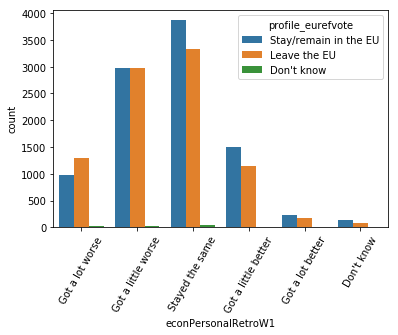

In [13]:
sns.countplot(x = BES_Panel["econPersonalRetroW1"], hue = BES_Panel["profile_eurefvote"]);
plt.xticks(rotation=60);

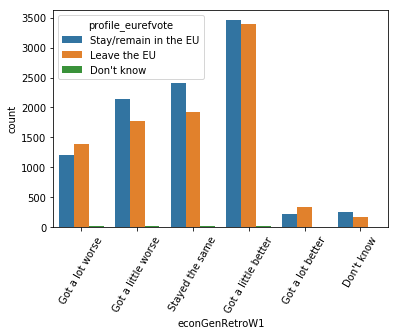

In [14]:
sns.countplot(x = BES_Panel["econGenRetroW1"], hue = BES_Panel["profile_eurefvote"]);
plt.xticks(rotation=60);

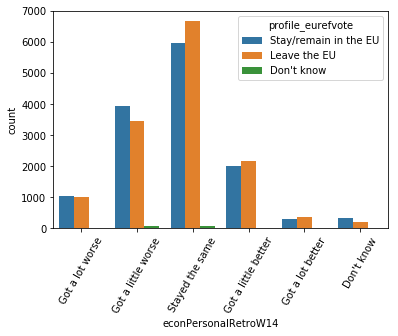

In [15]:
sns.countplot(x = BES_Panel["econPersonalRetroW14"], hue = BES_Panel["profile_eurefvote"]);
plt.xticks(rotation=60);

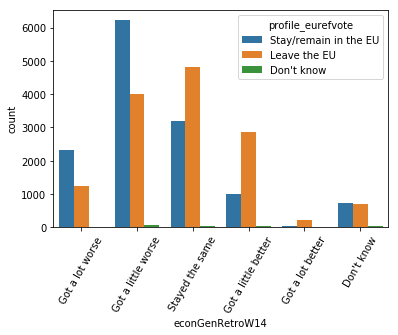

In [16]:
sns.countplot(x = BES_Panel["econGenRetroW14"], hue = BES_Panel["profile_eurefvote"]);
plt.xticks(rotation=60);

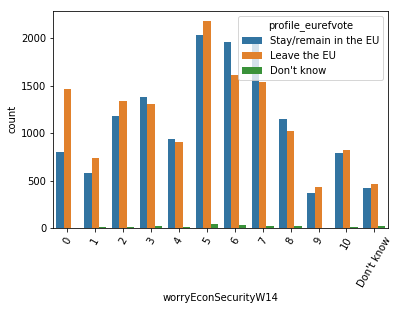

In [23]:
sns.countplot(x = BES_Panel["worryEconSecurityW14"], hue = BES_Panel["profile_eurefvote"]);
plt.xticks(rotation=60);

Warning, filename truncated because it was over 30. Filenames may no longer be unique


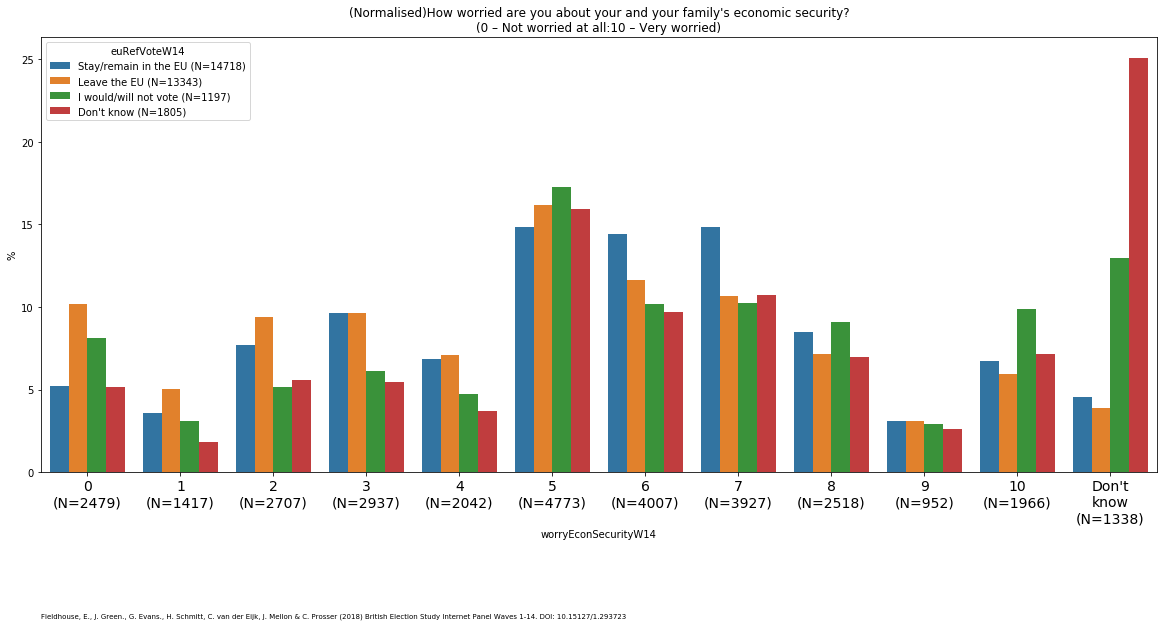

In [47]:
var2 ="worryEconSecurityW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)How worried are you about your and your family's economic security?\n(0 – Not worried at all:10 – Very worried)")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


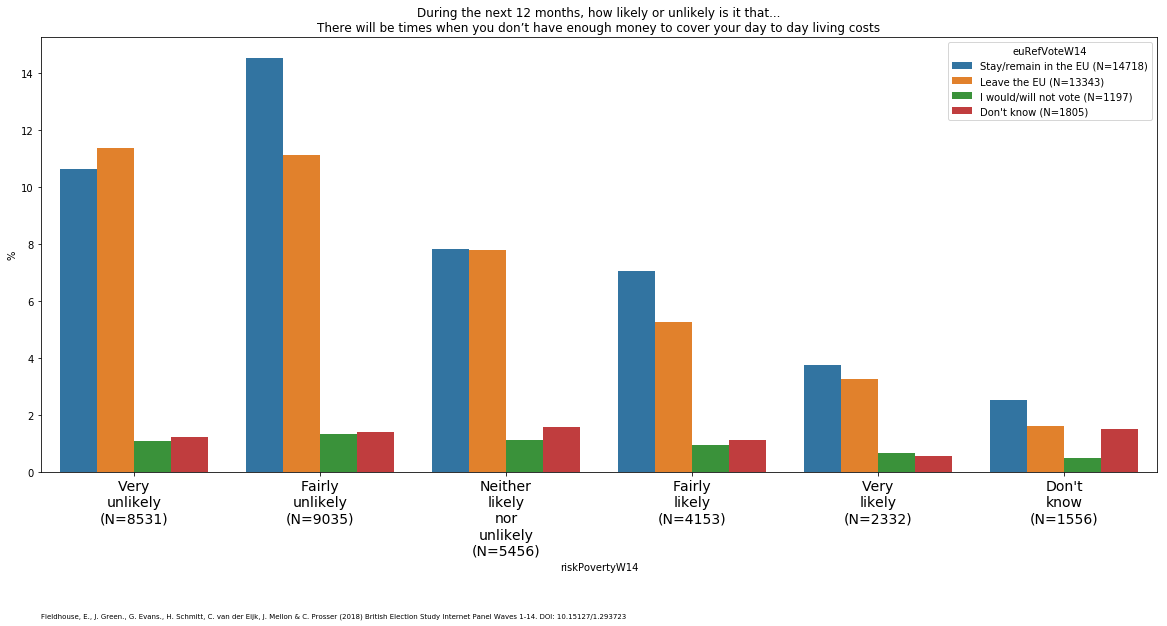

In [50]:
var2 ="riskPovertyW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              #fuckErrors=False,
              title="During the next 12 months, how likely or unlikely is it that...\nThere will be times when you don’t have enough money to cover your day to day living costs")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


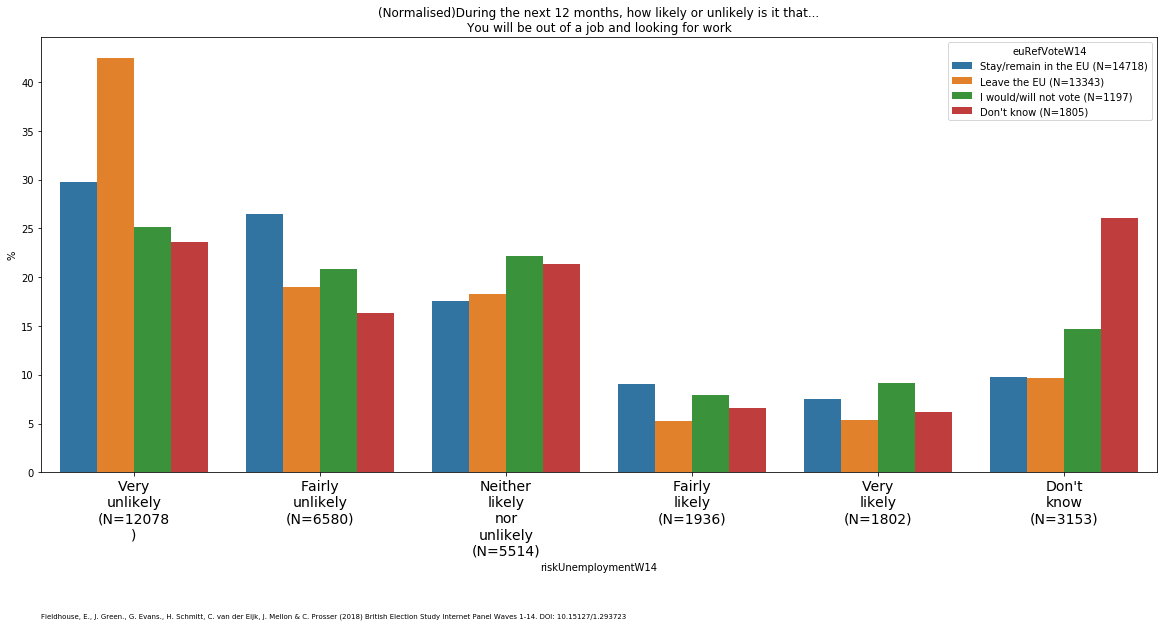

In [53]:
var2 ="riskUnemploymentW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)During the next 12 months, how likely or unlikely is it that...\nYou will be out of a job and looking for work")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


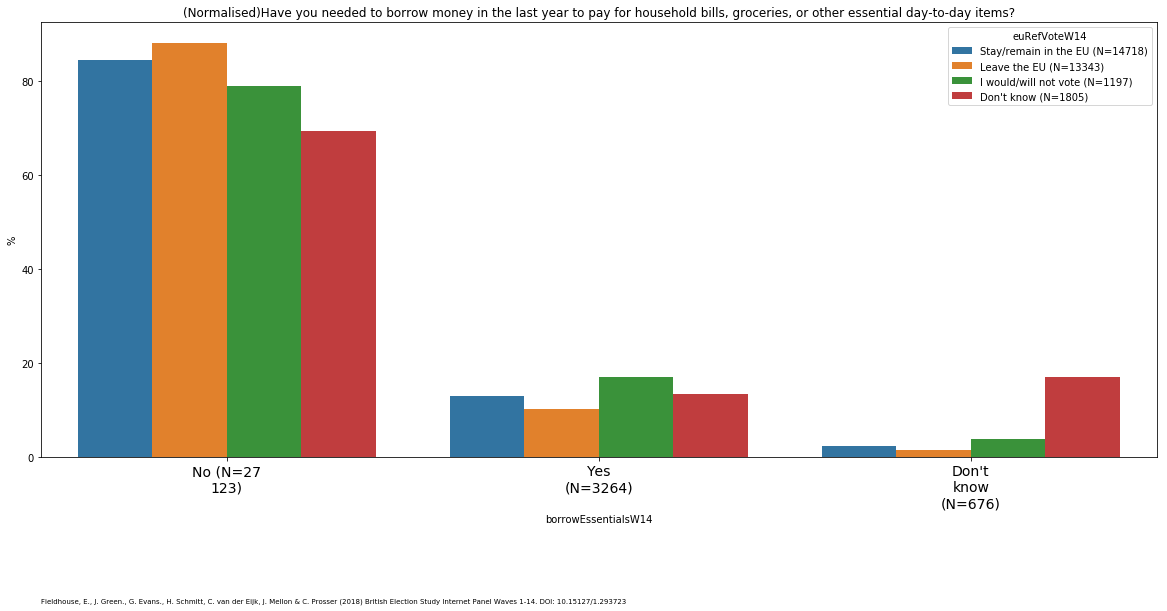

In [54]:
var2 ="borrowEssentialsW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)Have you needed to borrow money in the last year to pay for household bills, groceries, or other essential day-to-day items?")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


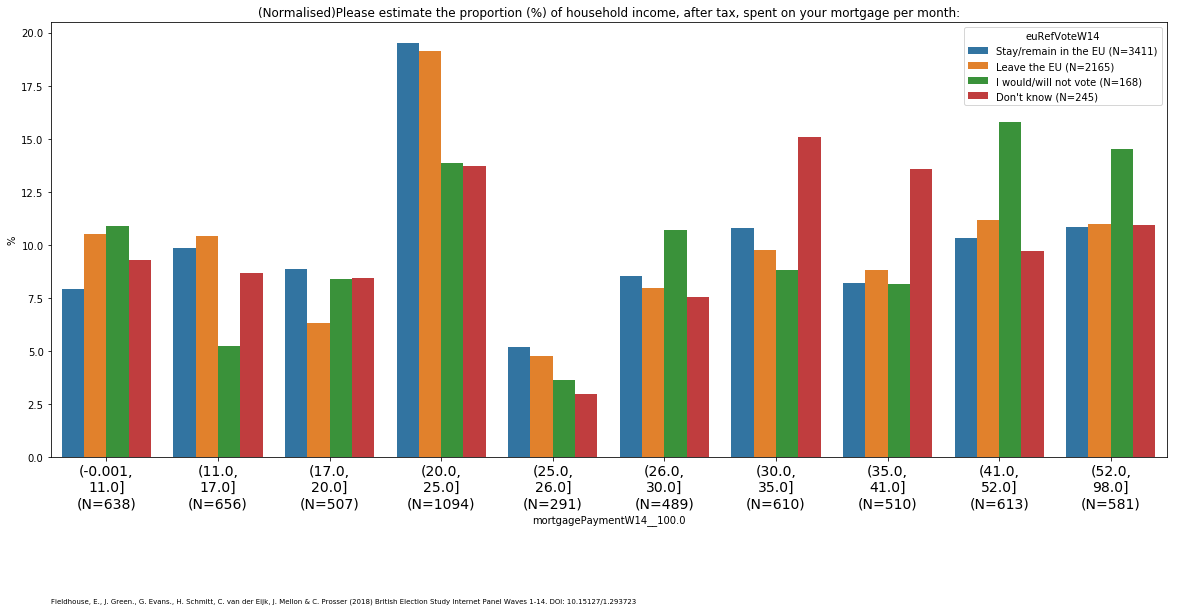

In [97]:
var2 ="mortgagePaymentW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = stringify_categories(df2)
df2 = pd.qcut(BES_reduced_with_na["mortgagePaymentW14__100.0"], q=10)
df2 = stringify_categories(df2)
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)Please estimate the proportion (%) of household income, after tax, spent on your mortgage per month:")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


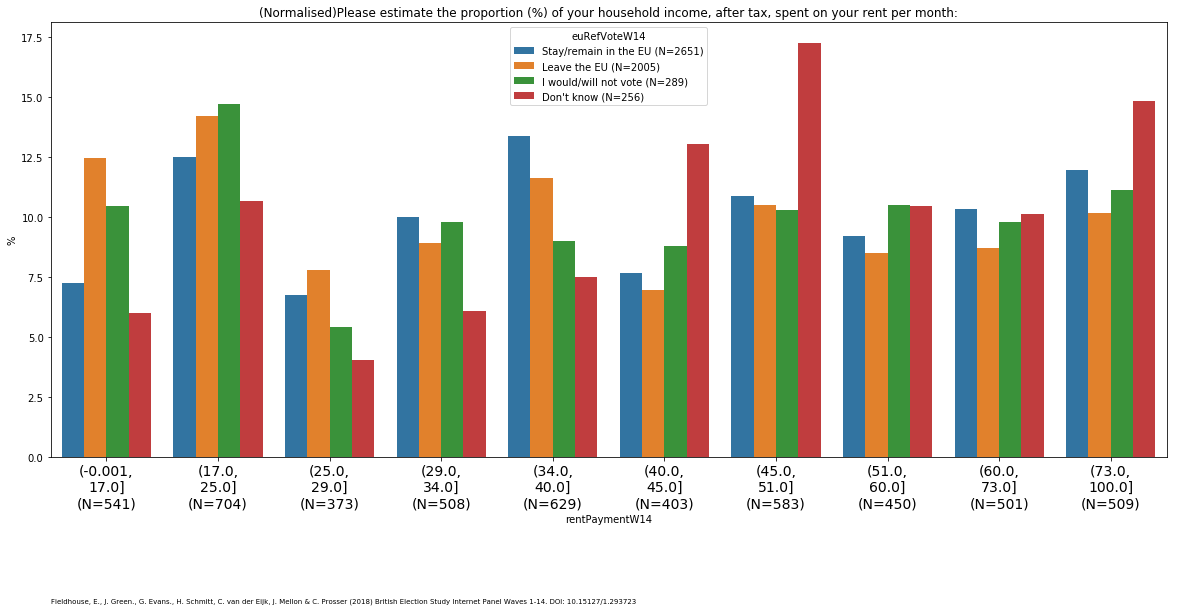

In [100]:
var2 ="rentPaymentW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = stringify_categories(df2)
df2 = pd.qcut(BES_reduced_with_na["rentPaymentW14"], q=10)
df2 = stringify_categories(df2)
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)Please estimate the proportion (%) of your household income, after tax, spent on your rent per month:")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


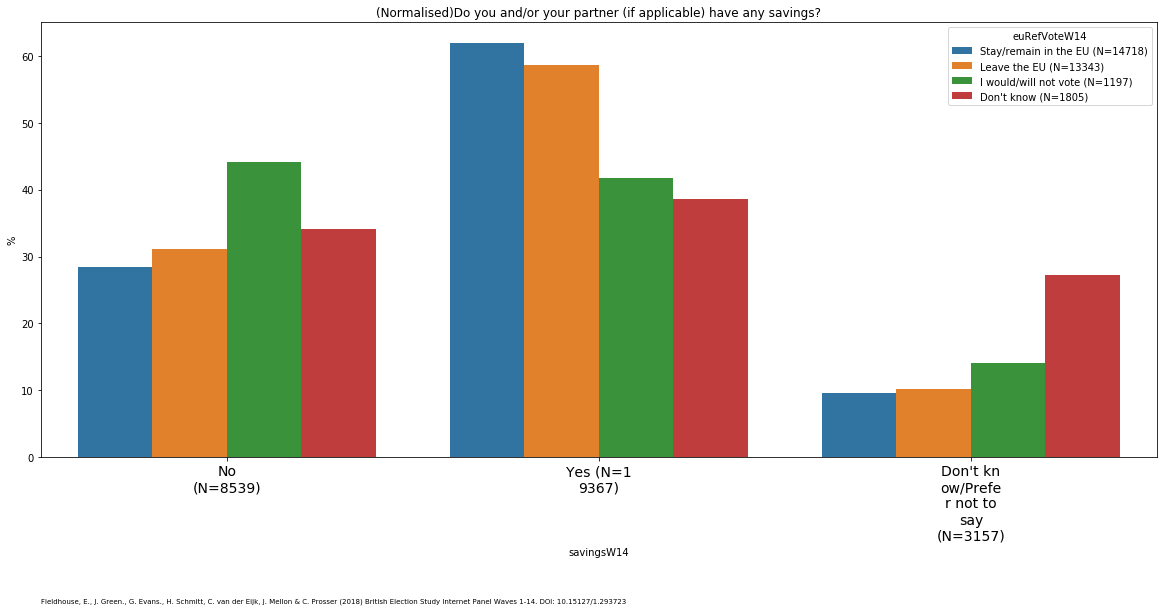

In [103]:
var2 ="savingsW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)Do you and/or your partner (if applicable) have any savings?")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


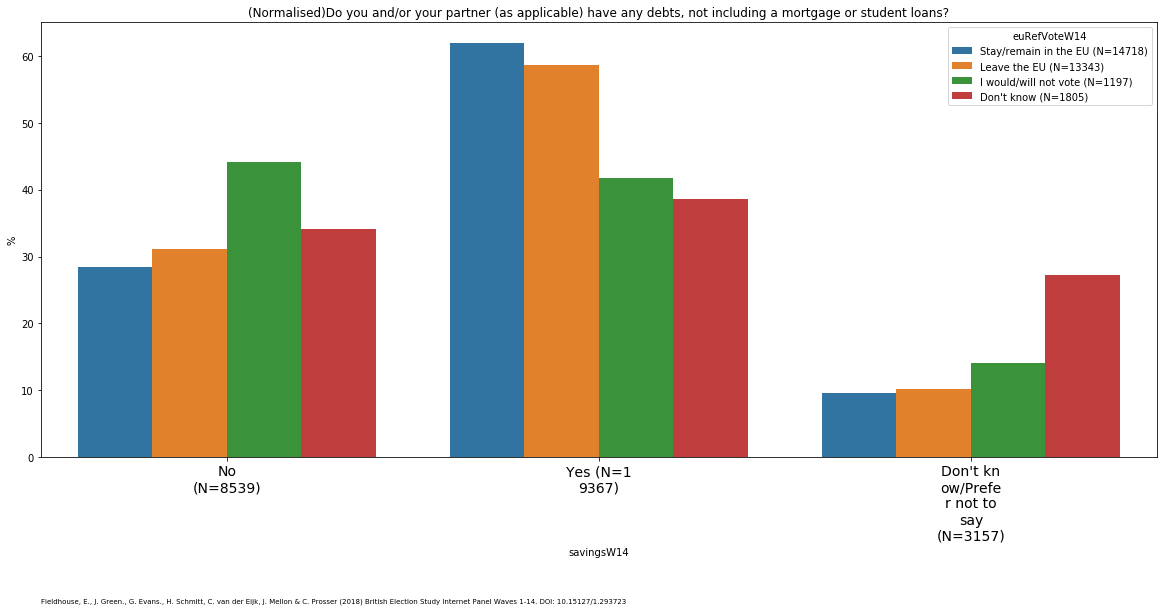

In [104]:
var2 ="savingsW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)Do you and/or your partner (as applicable) have any debts, not including a mortgage or student loans?")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


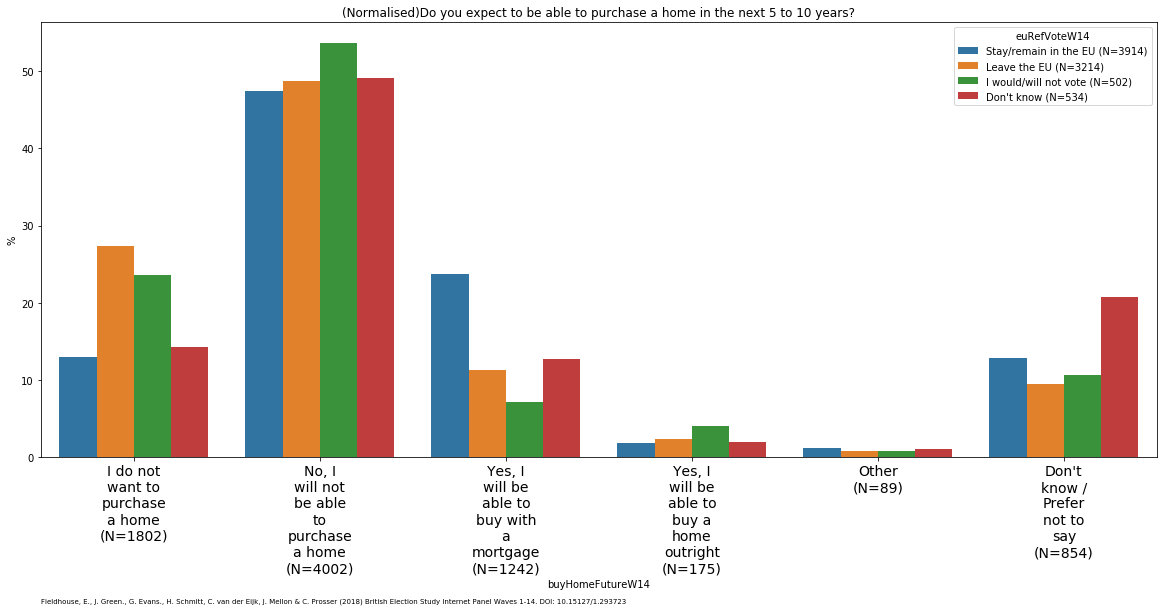

In [113]:
var2 ="buyHomeFutureW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)Do you expect to be able to purchase a home in the next 5 to 10 years?")



Warning, filename truncated because it was over 30. Filenames may no longer be unique


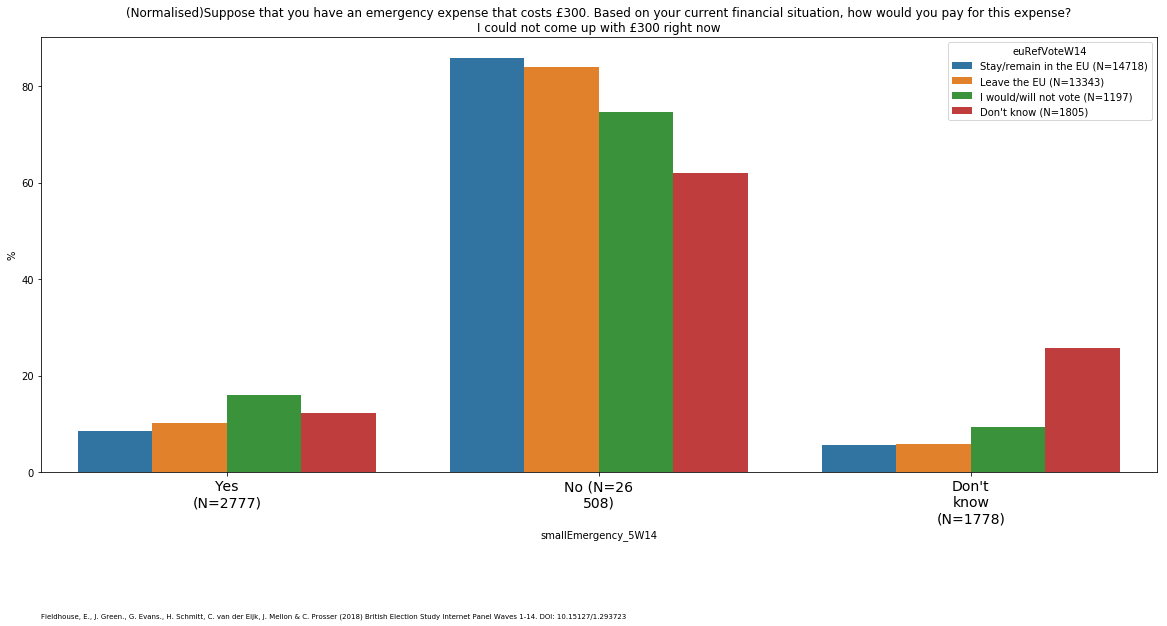

In [119]:
var2 ="smallEmergency_5W14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
df2 = df2.cat.rename_categories(["Yes","No","Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)Suppose that you have an emergency expense that costs £300. Based on your current financial situation, how would you pay for this expense?\nI could not come up with £300 right now")



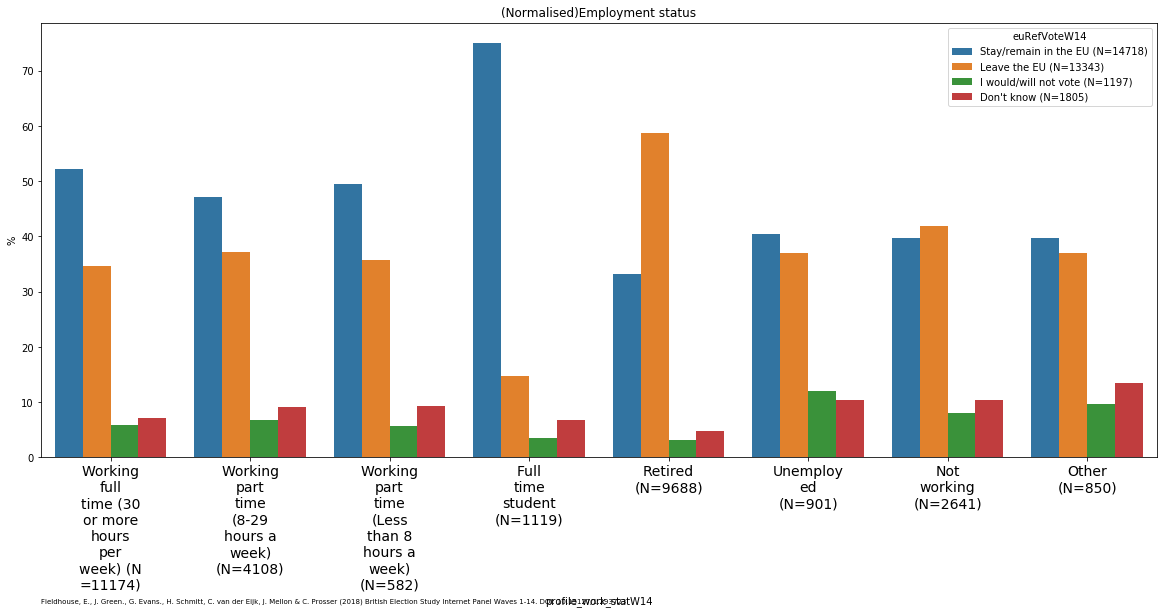

In [124]:
var2 ="profile_work_statW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(["Yes","No","Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)Employment status")



In [121]:
search(BES_Panel,"profile_work")

profile_work_organisationW1_W3    32383
profile_work_statW7               30895
profile_work_typeW7W10            38008
profile_work_statW11              30956
profile_work_typeW11              30956
profile_work_statW12              34394
profile_work_statW13              31136
profile_work_industryW14          22174
profile_work_organisationW14      26125
profile_work_responsibilityW14    20943
profile_work_statW14              31063
profile_work_typeW14              31063
profile_work_typeW2_W4             8592
profile_work_statW1_W10            9962
dtype: int64

In [114]:
df2

0                                               NaN
1                                               NaN
2                                               NaN
3                                               NaN
4                                               NaN
5                                               NaN
6                                               NaN
7                                               NaN
8                                               NaN
9                                               NaN
10                                              NaN
11                                              NaN
12                                              NaN
13                                              NaN
14                                              NaN
15                                              NaN
16                                              NaN
17                                              NaN
18                                              NaN
19          

Warning, filename truncated because it was over 30. Filenames may no longer be unique


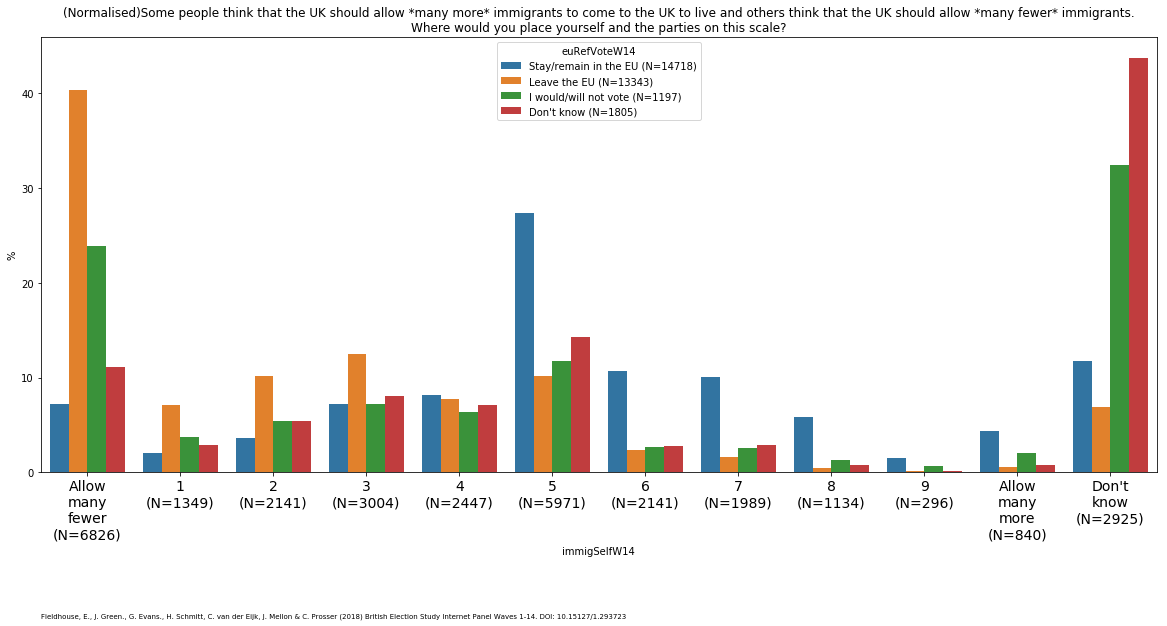

In [102]:
var2 ="immigSelfW14"
var1 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = stringify_categories(df2)
# df2 = pd.qcut(BES_reduced_with_na["rentPaymentW14"], q=10)
# df2 = stringify_categories(df2)
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              #fuckErrors=False,
              title="(Normalised)Some people think that the UK should allow *many more* immigrants to come to the UK to live and others think that the UK should allow *many fewer* immigrants.\nWhere would you place yourself and the parties on this scale?")



In [ ]:
# howToReduceDeficit


In [42]:
# %%time

pattern = "worryEconSecurity"
name = "borrowEssentialsW14_Yes"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
riskPovertyW14__Very likely,0.53,0.00,28578
riskUnemploymentW14__Very likely,0.36,0.00,27027
borrowEssentialsW14_Yes,0.31,0.00,29332
"buyHomeFutureW14_No, I will not be able to[...]",0.31,0.00,6882
cutsTooFarNationalW6__Gone much too far,0.29,0.00,12303
bestPMW8_Jeremy Corbyn,0.29,0.00,8160
mortgagePaymentW14__100.0,0.28,0.00,5928
changeCostLiveW14__Getting a lot higher,0.28,0.00,28952
lr3W14__Strongly agree,0.28,0.00,28787
cutsTooFarLocalW6__Gone much too far,0.27,0.00,11775


In [99]:
search(BES_reduced_with_na,"rentPayment")
# ERROR search(BES_reduced_with_na,"rentPayment") -> not treated as categorical!

rentPaymentW14    5201
dtype: int64

In [13]:
search(BES_reduced_with_na,"likeCorbyn")

likeCorbynW7__Strongly like     28788
likeCorbynW8__Strongly like     31377
likeCorbynW9__Strongly like     28432
likeCorbynW10__Strongly like    27784
likeCorbynW11__Strongly like    28858
likeCorbynW12__Strongly like    32400
likeCorbynW13__Strongly like    29752
likeCorbynW14__Strongly like    29228
dtype: int64

In [ ]:
ethno1amal = amalgamate_waves(BES_reduced_with_na, "likeCorbyn")

In [14]:
BES_reduced_with_na["al_scaleW14__Authoritarian"].corr(BES_reduced_with_na["likeCorbynW14__Strongly like"])

-0.3478475109713518

In [15]:
BES_reduced_with_na["al_scaleW7W8W9__Authoritarian"].corr(BES_reduced_with_na["likeCorbynW7__Strongly like"])

-0.42221932098136505

In [22]:
OnceLabour = BES_reduced_with_na["profile_past_vote_2005_Labour Party"]==1.0

In [23]:
(BES_reduced_with_na["al_scaleW14__Authoritarian"][OnceLabour]).corr(BES_reduced_with_na["likeCorbynW14__Strongly like"][OnceLabour])

-0.2518067084935157

In [24]:
BES_reduced_with_na["al_scaleW7W8W9__Authoritarian"][OnceLabour].corr(BES_reduced_with_na["likeCorbynW7__Strongly like"][OnceLabour])

-0.3423709929660632

In [37]:
search(BES_Panel,"gayMarriage", mask=BES_Panel["gayEqualityW6_W12"].notnull())

gayMarriageW10    30237
dtype: int64

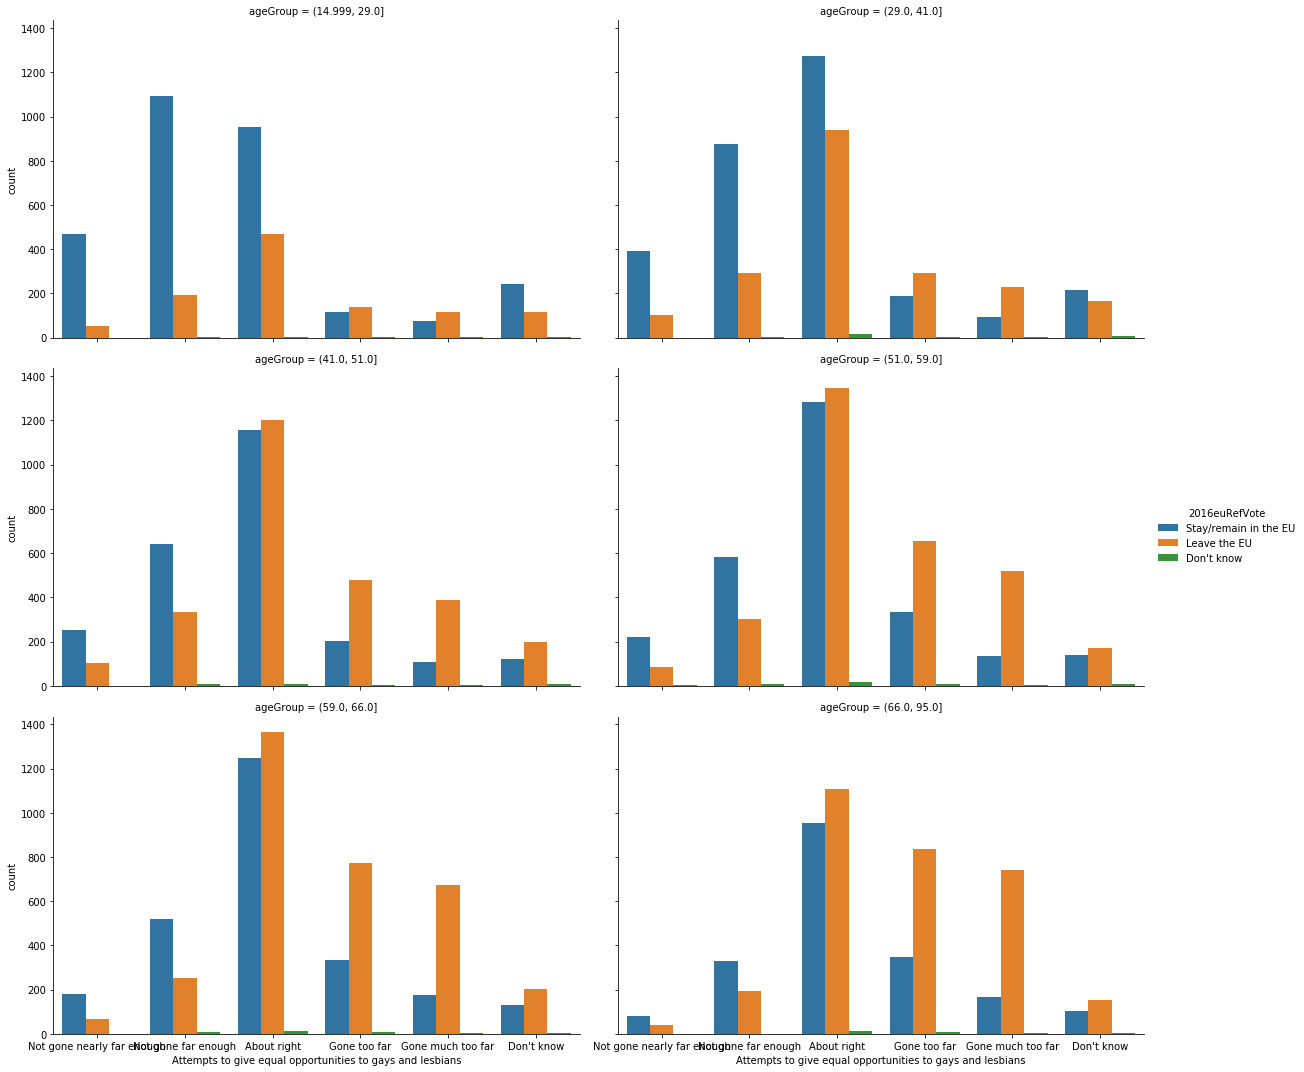

In [36]:
# all_source_inc_vars = list(search(BES_Panel,"allSourceIncome_\d+W11").index)
all_source_inc_vars = list(["gayEqualityW6_W12"])
euref_var_name = "profile_eurefvote"
euref_var = [euref_var_name]
new_euref_var_name = "2016euRefVote"

ageGroup = pd.qcut(BES_Panel["Age"],q=6)

# mask = (BES_Panel[all_source_inc_vars].notnull().all(axis=1))
mask = BES_Panel["gayEqualityW6_W12"].notnull()
mask = mask & (BES_Panel[euref_var].notnull())[euref_var_name]
mask = mask & ageGroup.notnull()

allSource_df = BES_Panel[all_source_inc_vars+euref_var][mask].copy()
allSource_df = pd.concat([allSource_df,ageGroup[mask]], axis=1)
answers = "Attempts to give equal opportunities to gays and lesbians"
allSource_df.columns = [answers,new_euref_var_name,"ageGroup"]
# allSource_df.columns = ["Earnings from employment (own or spouse / partner’s)",
#                         "Occupational pension(s) – from previous employer(s)",
#                         "State retirement or widow’s pension(s)",
#                         "Jobseeker’s Allowance / Unemployment benefit",
#                         "Income Support or family credit",
#                         "Invalidity, sickness or disabled pension or benefit(s)",
#                         "Other state benefit",
#                         "Interest from savings or investments",
#                         "Student grant or loan",
#                         "Dependent on parents/other relatives",
#                         "Other source",
#                         "Don’t know",
#                         new_euref_var_name]

# allSource_df = allSource_df.set_index(new_euref_var_name).stack().reset_index()
# ques_stub = "Please say whether you think these things have gone too far or have not gone far enough in Britain."
# allSource_df.columns = [new_euref_var_name,
#                         ques_stub,
#                         "answers"]



sns.catplot(x=answers, hue=new_euref_var_name, col_wrap=2,
            col = "ageGroup",
            data=allSource_df,
            kind='count', orient='h', aspect=1.6);

Treatment = "gay_rights_by_age_by_eurefvote"
output_subfolder = create_subdir(BES_output_folder,Treatment)
fname = output_subfolder +Treatment + ".png"
plt.savefig( fname, bbox_inches='tight' )

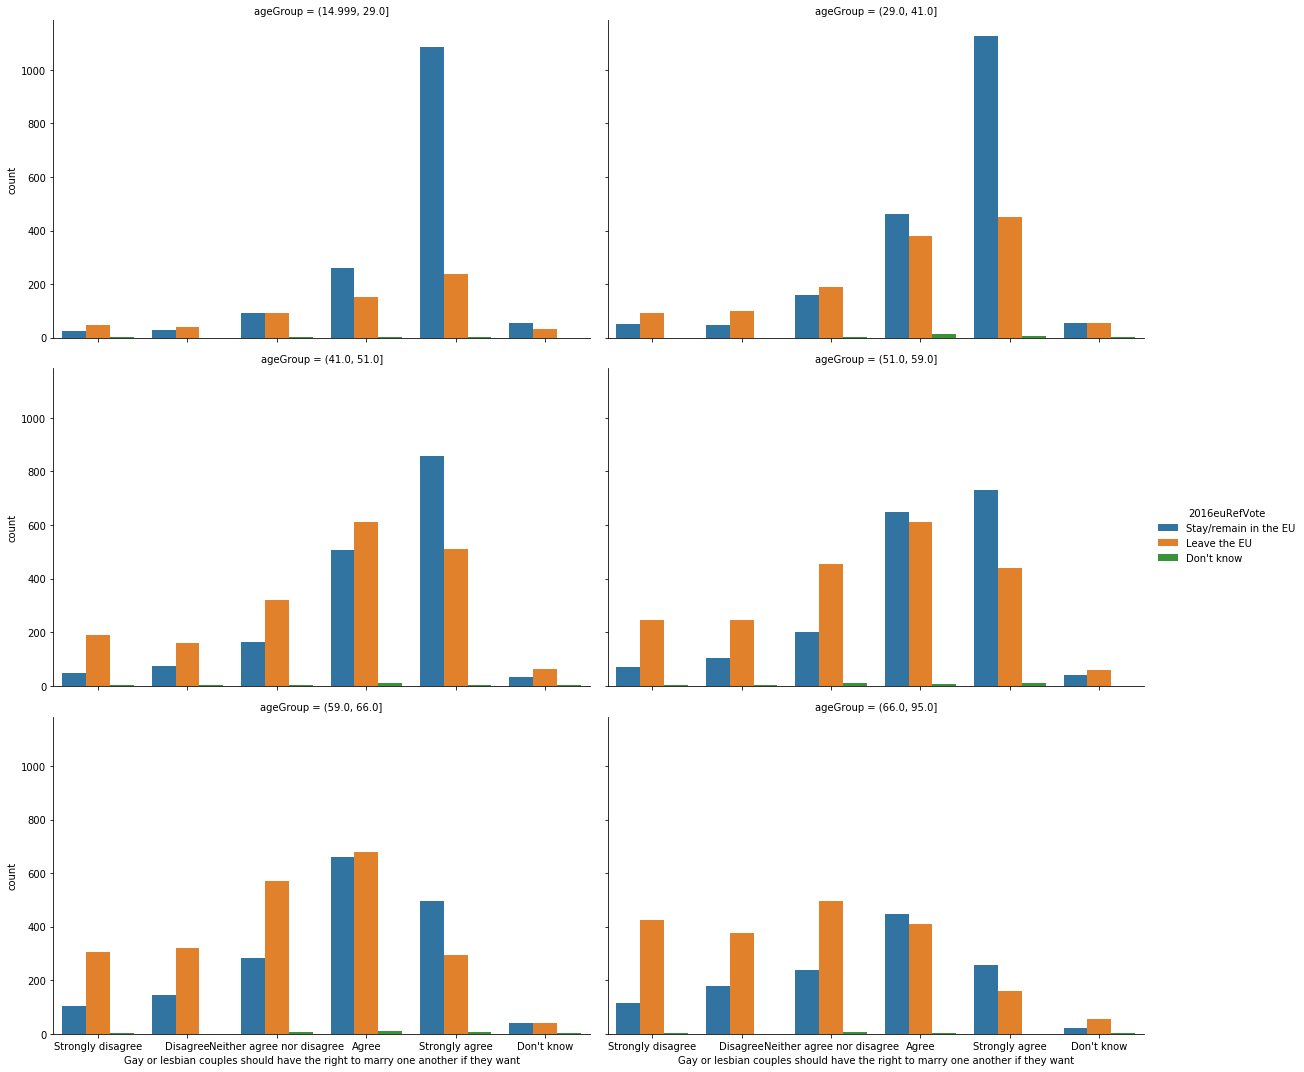

In [38]:
# all_source_inc_vars = list(search(BES_Panel,"allSourceIncome_\d+W11").index)
all_source_inc_vars = list(["gayMarriageW10"])
euref_var_name = "profile_eurefvote"
euref_var = [euref_var_name]
new_euref_var_name = "2016euRefVote"

ageGroup = pd.qcut(BES_Panel["Age"],q=6)

# mask = (BES_Panel[all_source_inc_vars].notnull().all(axis=1))
mask = BES_Panel["gayMarriageW10"].notnull()
mask = mask & (BES_Panel[euref_var].notnull())[euref_var_name]
mask = mask & ageGroup.notnull()

allSource_df = BES_Panel[all_source_inc_vars+euref_var][mask].copy()
allSource_df = pd.concat([allSource_df,ageGroup[mask]], axis=1)
answers = "Gay or lesbian couples should have the right to marry one another if they want"
allSource_df.columns = [answers,new_euref_var_name,"ageGroup"]
# allSource_df.columns = ["Earnings from employment (own or spouse / partner’s)",
#                         "Occupational pension(s) – from previous employer(s)",
#                         "State retirement or widow’s pension(s)",
#                         "Jobseeker’s Allowance / Unemployment benefit",
#                         "Income Support or family credit",
#                         "Invalidity, sickness or disabled pension or benefit(s)",
#                         "Other state benefit",
#                         "Interest from savings or investments",
#                         "Student grant or loan",
#                         "Dependent on parents/other relatives",
#                         "Other source",
#                         "Don’t know",
#                         new_euref_var_name]

# allSource_df = allSource_df.set_index(new_euref_var_name).stack().reset_index()
# ques_stub = "Please say whether you think these things have gone too far or have not gone far enough in Britain."
# allSource_df.columns = [new_euref_var_name,
#                         ques_stub,
#                         "answers"]



sns.catplot(x=answers, hue=new_euref_var_name, col_wrap=2,
            col = "ageGroup",
            data=allSource_df,
            kind='count', orient='h', aspect=1.6);

Treatment = "gay_marriage_by_age_by_eurefvote"
output_subfolder = create_subdir(BES_output_folder,Treatment)
fname = output_subfolder +Treatment + ".png"
plt.savefig( fname, bbox_inches='tight' )

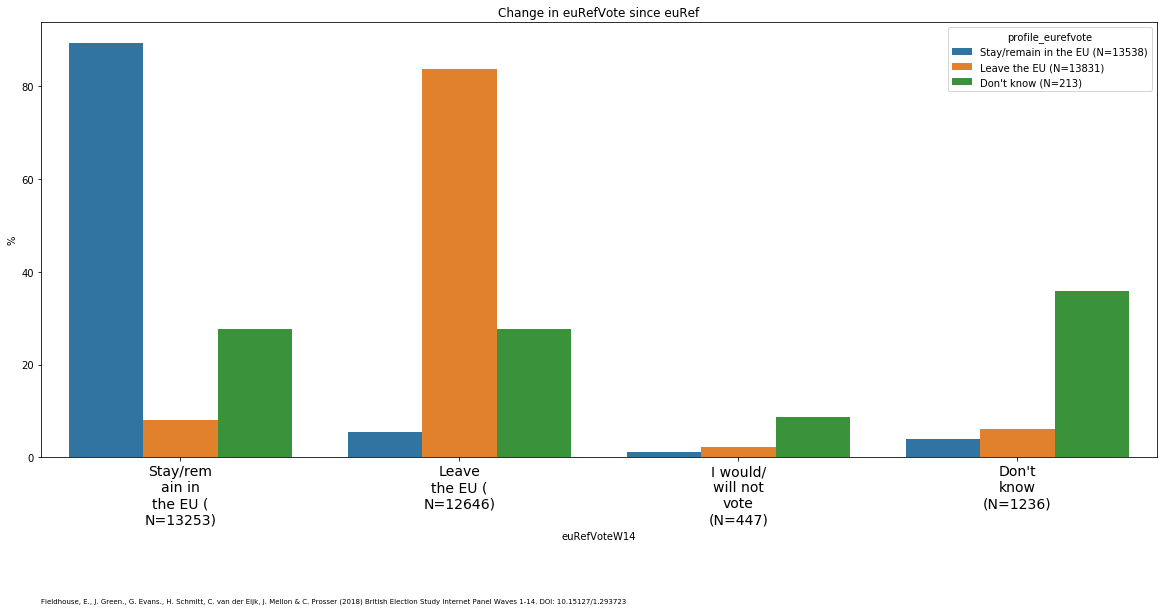

In [16]:
var1 ="profile_eurefvote"
var2 ="euRefVoteW14"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              title="Change in euRefVote since euRef")



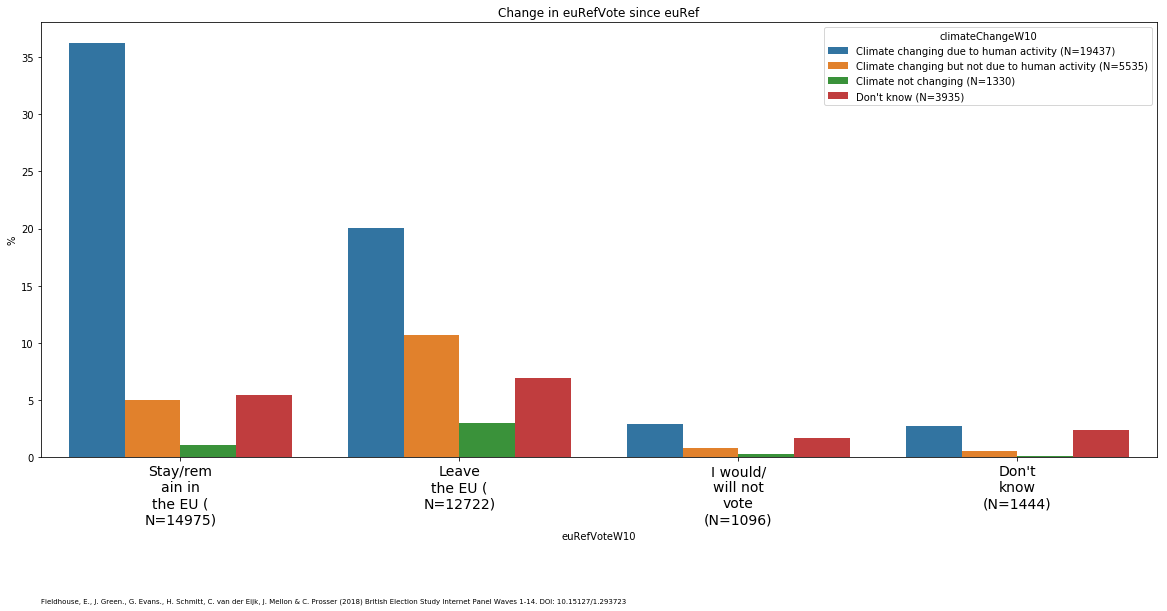

In [23]:
var1 ="climateChangeW10"
var2 ="euRefVoteW10"
# amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              title="Change in euRefVote since euRef")



In [143]:
search(BES_Panel, "hous", mask = BES_Panel["houseBuildW12"].notnull()&BES_Panel["houseBuildW12"].notnull())

headHouseholdPastW1               14255
headHouseholdPastW2                 943
headHouseholdPastW3                 883
headHouseholdPastW4                1688
headHouseholdPastW7                3763
headHouseholdPastW9               18353
headHouseholdPastW10              19222
headHouseholdPastW11              22253
councilHouseW12                   34394
houseBuildW12                     34394
headHouseholdPastW13              23460
preschoolKidsInHouseW14           20741
schoolKidsInHouseW14              20741
sickElderlyInHouseW14             20741
noDependentsInHouseW14            20741
headHouseholdPast                 31871
housing                           15518
profile_house_tenureW10           21719
profile_household_sizeW10         21718
profile_gross_householdW10        21719
profile_gross_householdW11        25018
profile_house_tenureW11           24943
profile_gross_householdW12        33641
profile_house_tenureW12           33478
profile_gross_householdW13        26253


In [144]:
BES_Panel["profile_house_tenure"].value_counts()

Own outright                                                                          18753
Own with a mortgage                                                                   15936
Rent from a private landlord                                                           8431
Rent from a housing association                                                        3328
Rent from my local authority                                                           3143
Neither I live rent-free with my parents, family or friends                            2734
Neither I live with my parents, family or friends but pay some rent to them            2273
Other                                                                                  1066
Own (part-own) through shared ownership scheme (i.e. pay part mortgage, part rent)      400
Name: profile_house_tenure, dtype: int64

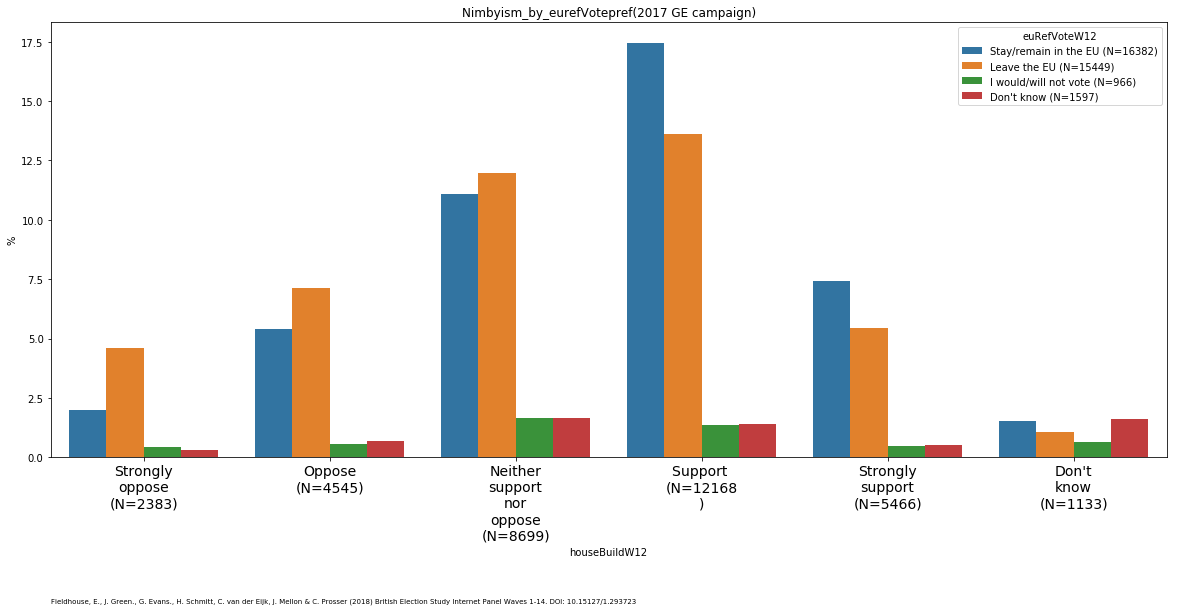

In [141]:
var1 ="euRefVoteW12"
var2 ="houseBuildW12"
# amal_al_3cat.name = var2

# mask = (BES_reduced_with_na["Age"]>15) & (BES_reduced_with_na["Age"]<=64)

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              title="Nimbyism_by_eurefVotepref(2017 GE campaign)" )



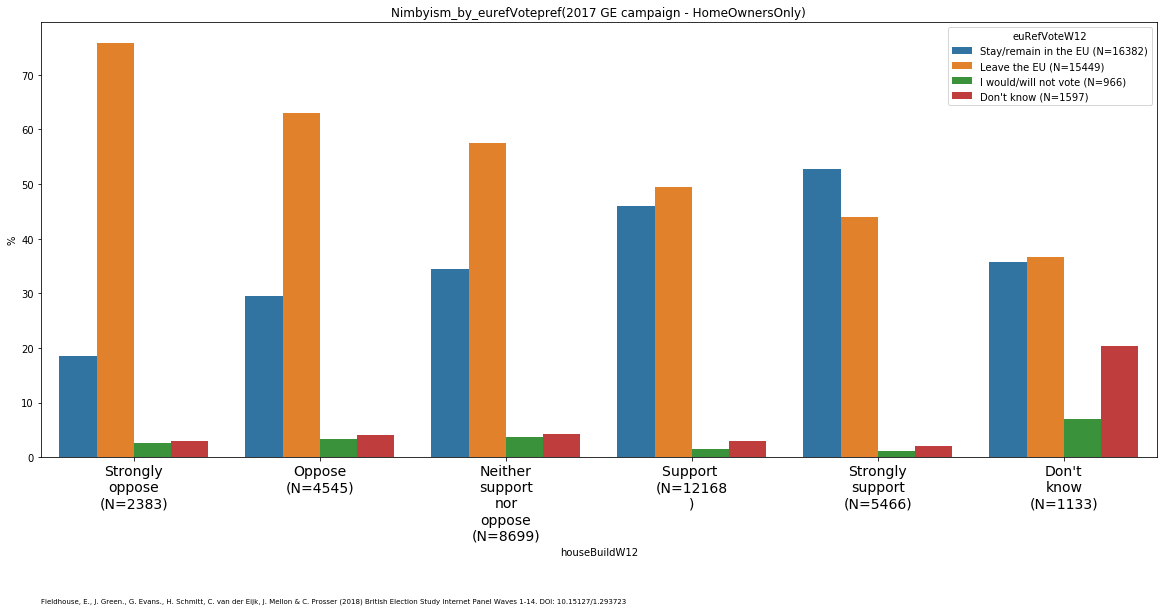

In [155]:
var1 ="euRefVoteW12"
var2 ="houseBuildW12"
# amal_al_3cat.name = var2

mask = (BES_Panel["profile_house_tenure"]=="Own outright")# | (BES_Panel["profile_house_tenure"]=="Own with a mortgage")

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              title="Nimbyism_by_eurefVotepref(2017 GE campaign - HomeOwnersOnly)", mask=mask )



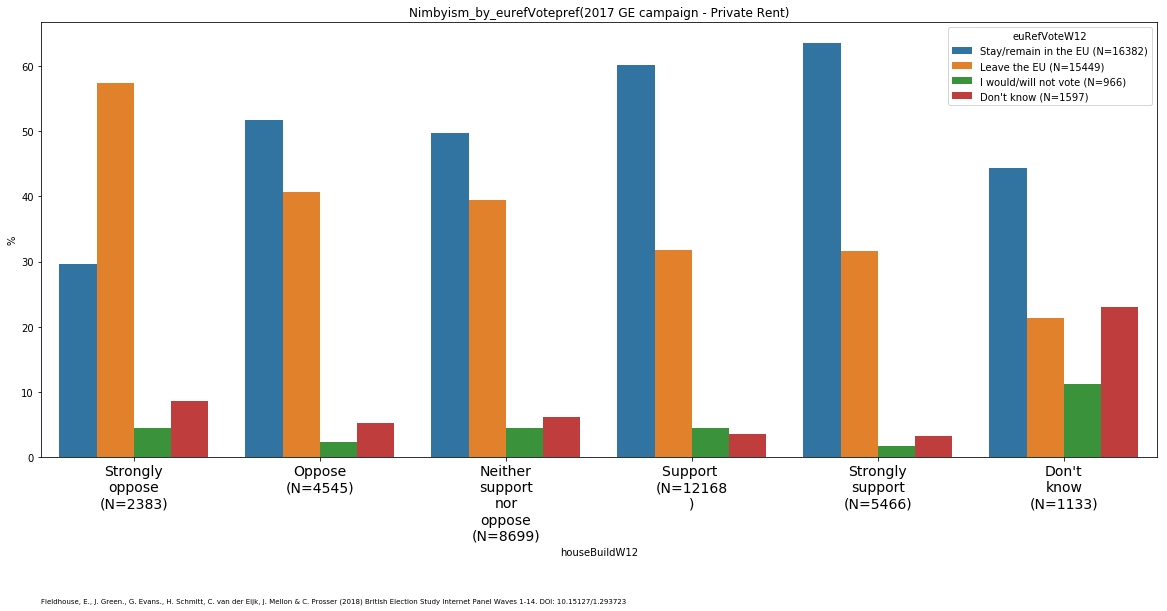

In [151]:
var1 ="euRefVoteW12"
var2 ="houseBuildW12"
# amal_al_3cat.name = var2

mask = (BES_Panel["profile_house_tenure"]=="Rent from a private landlord")# | (BES_Panel["profile_house_tenure"]=="Own with a mortgage")

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              title="Nimbyism_by_eurefVotepref(2017 GE campaign - Private Rent)", mask=mask )



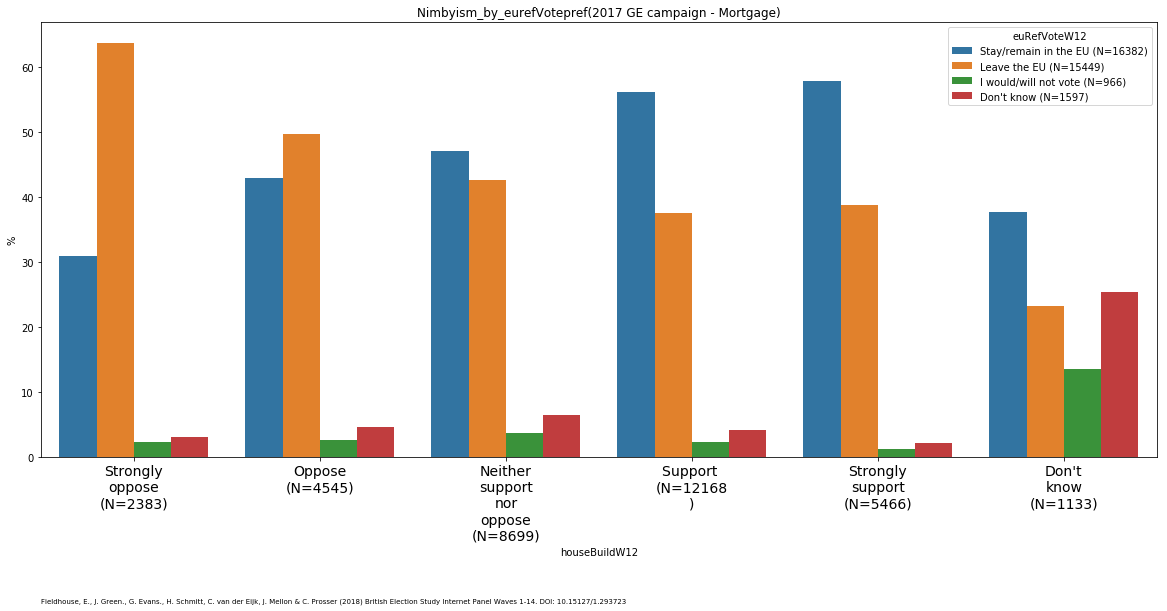

In [153]:
var1 ="euRefVoteW12"
var2 ="houseBuildW12"
# amal_al_3cat.name = var2

mask = (BES_Panel["profile_house_tenure"]=="Own with a mortgage")# | (BES_Panel["profile_house_tenure"]=="Own with a mortgage")

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              title="Nimbyism_by_eurefVotepref(2017 GE campaign - Mortgage)", mask=mask )



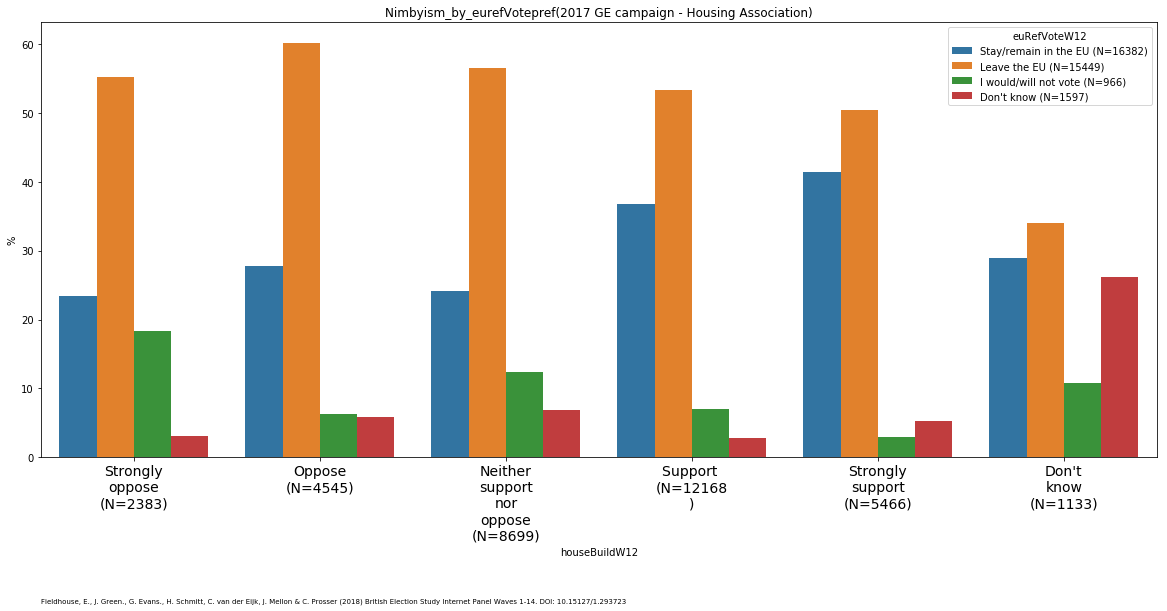

In [156]:
var1 ="euRefVoteW12"
var2 ="houseBuildW12"
# amal_al_3cat.name = var2

mask = (BES_Panel["profile_house_tenure"]=="Rent from a housing association")# | (BES_Panel["profile_house_tenure"]=="Own with a mortgage")

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              title="Nimbyism_by_eurefVotepref(2017 GE campaign - Housing Association)", mask=mask )



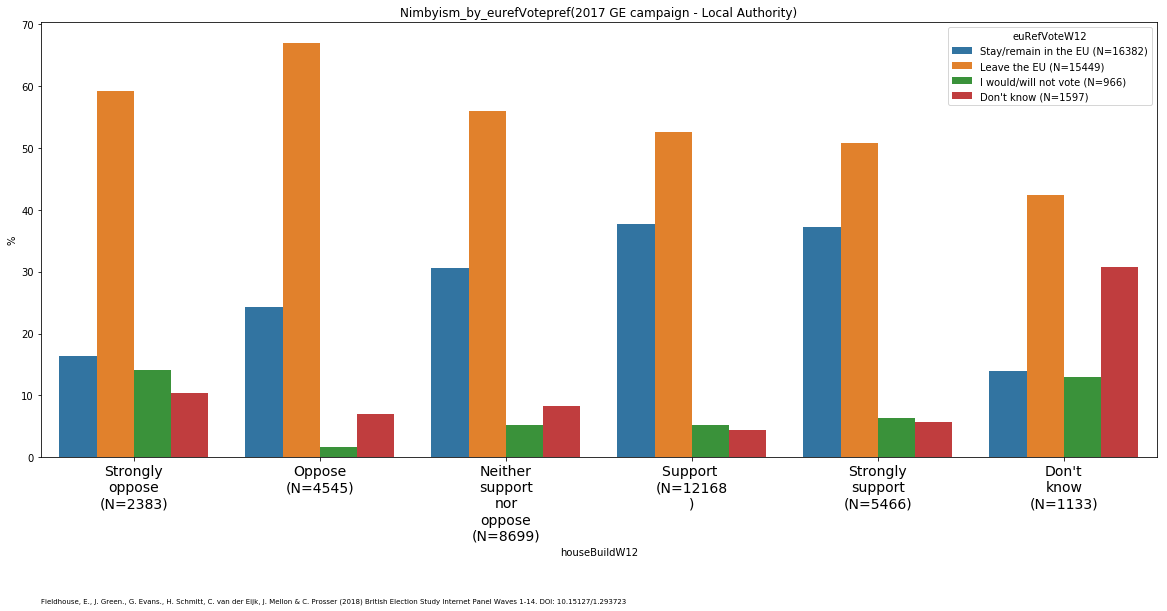

In [160]:
var1 ="euRefVoteW12"
var2 ="houseBuildW12"
# amal_al_3cat.name = var2

mask = (BES_Panel["profile_house_tenure"]=="Rent from my local authority")# | (BES_Panel["profile_house_tenure"]=="Own with a mortgage")

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              title="Nimbyism_by_eurefVotepref(2017 GE campaign - Local Authority)", mask=mask )



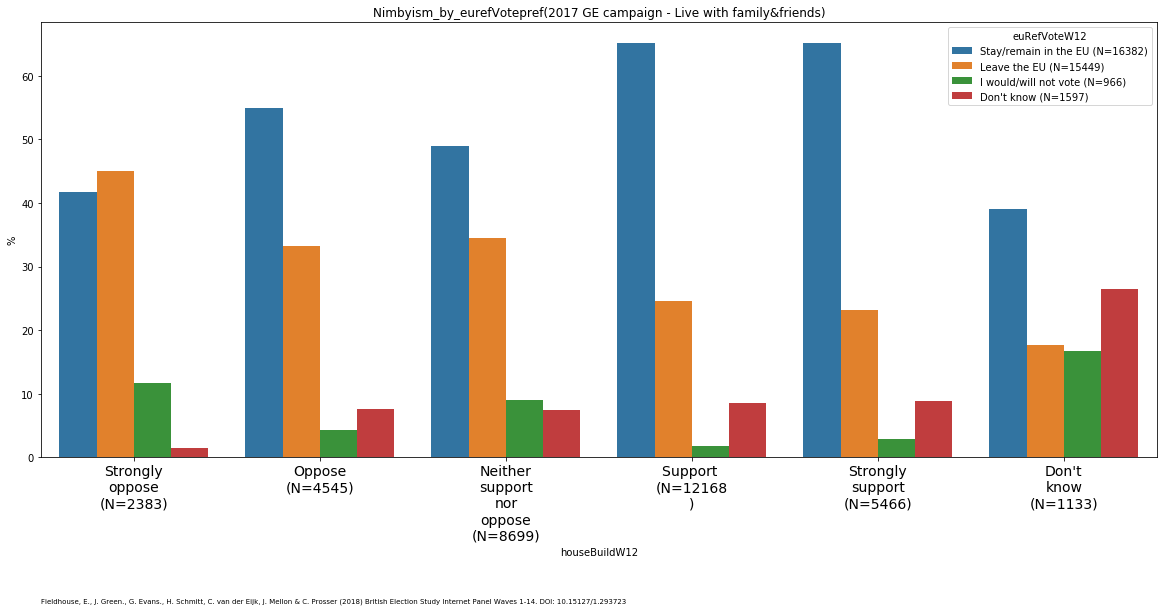

In [161]:
var1 ="euRefVoteW12"
var2 ="houseBuildW12"
# amal_al_3cat.name = var2

mask = (BES_Panel["profile_house_tenure"]=="Neither I live rent-free with my parents, family or friends")# | (BES_Panel["profile_house_tenure"]=="Own with a mortgage")

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              title="Nimbyism_by_eurefVotepref(2017 GE campaign - Live with family&friends)", mask=mask )



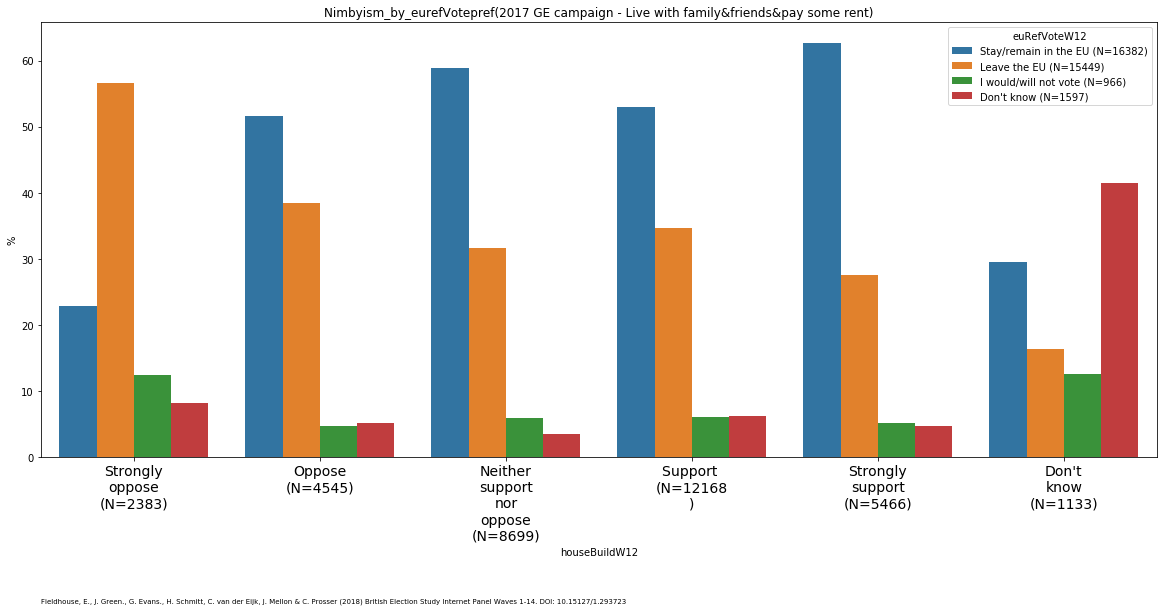

In [163]:
var1 ="euRefVoteW12"
var2 ="houseBuildW12"
# amal_al_3cat.name = var2

mask = (BES_Panel["profile_house_tenure"]=="Neither I live with my parents, family or friends but pay some rent to them")# | (BES_Panel["profile_house_tenure"]=="Own with a mortgage")

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              title="Nimbyism_by_eurefVotepref(2017 GE campaign - Live with family&friends&pay some rent)", mask=mask )



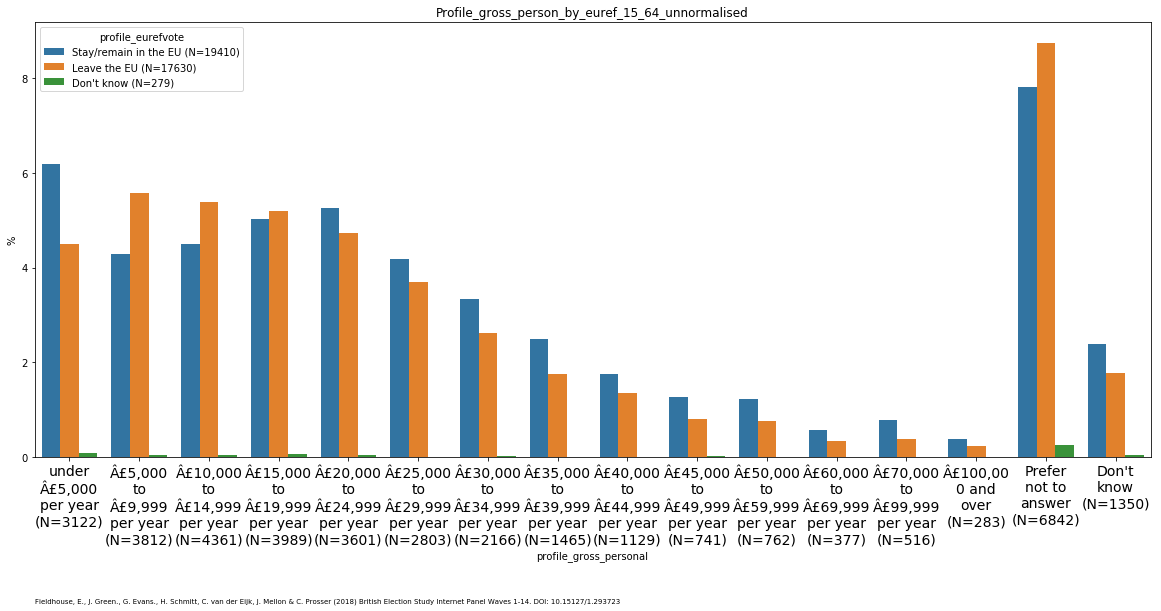

In [137]:
var1 ="profile_eurefvote"
var2 ="profile_gross_personal"
# amal_al_3cat.name = var2

mask = (BES_reduced_with_na["Age"]>15) & (BES_reduced_with_na["Age"]<=64)

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              title="Profile_gross_person_by_euref_15_64_unnormalised", mask=mask)



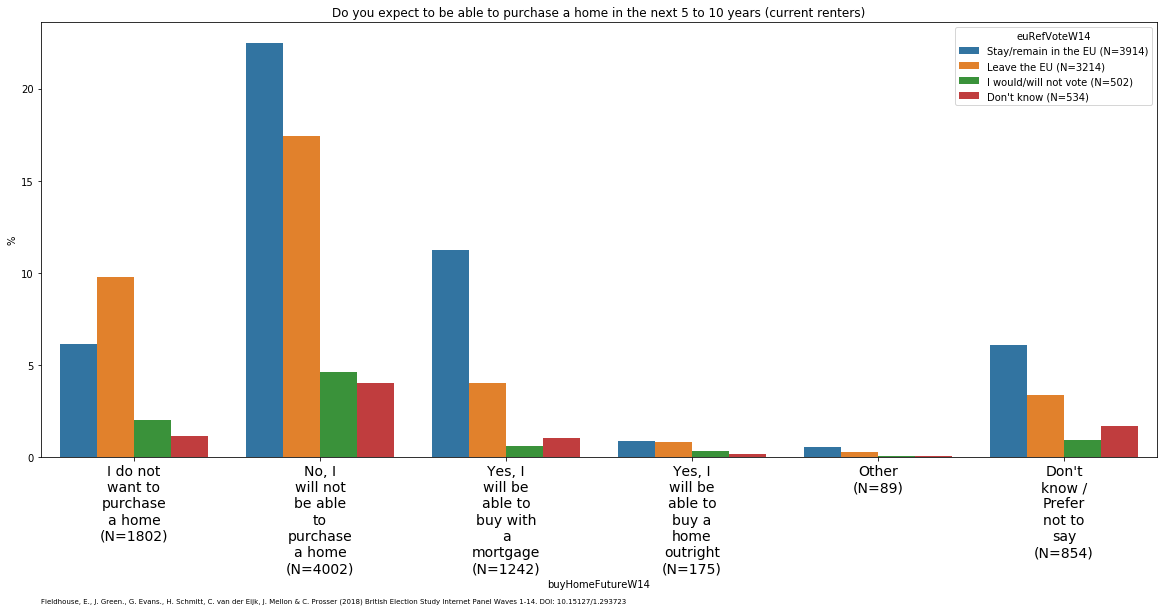

In [100]:
var1 ="euRefVoteW14"
var2 ="buyHomeFutureW14"
# amal_al_3cat.name = var2

# mask = (BES_reduced_with_na["ageW12"]>=30) & (BES_reduced_with_na["ageW12"]<=50)

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              title="Do you expect to be able to purchase a home in the next 5 to 10 years (current renters)")



In [109]:
var1 ="euRefVoteW14"
var2 ="mortgagePaymentW14"
# amal_al_3cat.name = var2

# mask = (BES_reduced_with_na["ageW12"]>=30) & (BES_reduced_with_na["ageW12"]<=50)

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              title="Please estimate the proportion (%) of household income, after tax, spent on your mortgage per month")



TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [103]:
search(BES_reduced_with_na,"mortgage", mask = BES_Panel["euRefVoteW14"].notnull())

mortgagePaymentW14__100.0                                                                                        5989
secondHomeW14__Yes: I/we own another property outright (without a mortgage)                                     21679
homeOwnW14_Own with a mortgage                                                                                  30076
buyHomeFutureW14_Yes, I will be able to buy with a mortgage                                                      7221
housing_Buying leasehold/freehold on a mortgage                                                                 12101
profile_house_tenureW10_Own with a mortgage                                                                     17649
profile_house_tenureW10_Own (part-own) through shared ownership scheme (i.e. pay part mortgage, part rent)      17649
profile_house_tenureW11_Own - with a mortgage                                                                   19068
profile_house_tenureW11_Own (part-own) - through shared 

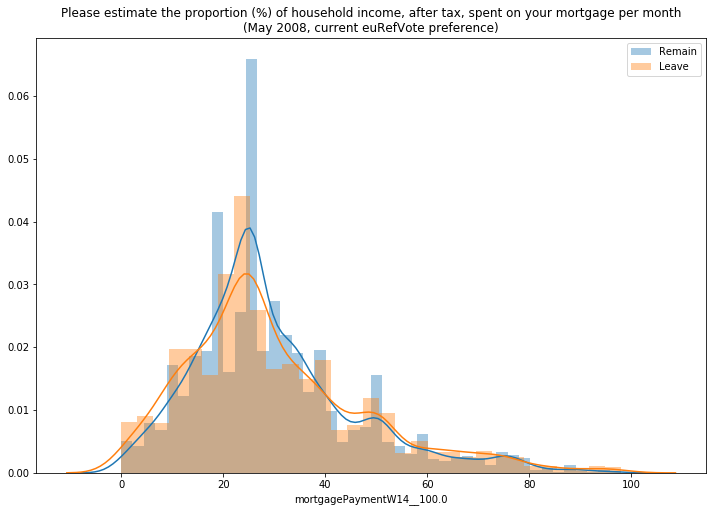

In [131]:
plt.figure(figsize=(12,8))
sns.distplot(BES_reduced_with_na["mortgagePaymentW14__100.0"][df1=='Stay/remain in the EU'].dropna(), label="Remain");
sns.distplot(BES_reduced_with_na["mortgagePaymentW14__100.0"][df1=='Leave the EU'].dropna(), label="Leave");
plt.legend();
plt.title("Please estimate the proportion (%) of household income, after tax, spent on your mortgage per month\n(May 2008, current euRefVote preference)");

In [121]:
plt.figure(figsize=(12,8))
sns.distplot(BES_reduced_with_na["mortgagePaymentW14__100.0"][df1=='Stay/remain in the EU'].dropna(), label="Remain");
sns.distplot(BES_reduced_with_na["mortgagePaymentW14__100.0"][df1=='Leave the EU'].dropna(), label="Leave");
plt.legend();
plt.title("Please estimate the proportion (%) of household income, after tax, spent on your mortgage per month\n(May 2008, current euRefVote preference)");

Index(['Stay/remain in the EU', 'Leave the EU', 'I would/will not vote',
       'Don't know'],
      dtype='object')

In [75]:
gc.collect()

44

In [79]:
all_source_inc_vars

['allSourceIncome_1W11',
 'allSourceIncome_2W11',
 'allSourceIncome_3W11',
 'allSourceIncome_4W11',
 'allSourceIncome_5W11',
 'allSourceIncome_6W11',
 'allSourceIncome_7W11',
 'allSourceIncome_8W11',
 'allSourceIncome_9W11']

In [72]:
flat_euref_ethno = euref_ethno.set_index("euRef").stack().reset_index()
ques_stub = "How much do you agree or disagree with the following statements?\n"
flat_euref_ethno.columns = ["euRef",ques_stub,"answers"]
flat_euref_ethno["answers"] = flat_euref_ethno["answers"].replace("Neither agree nor disagree","Neither")
order  = list(ethno1amal.cat.categories)
order = ["Neither" if x=="Neither agree nor disagree" else x for x in order] 

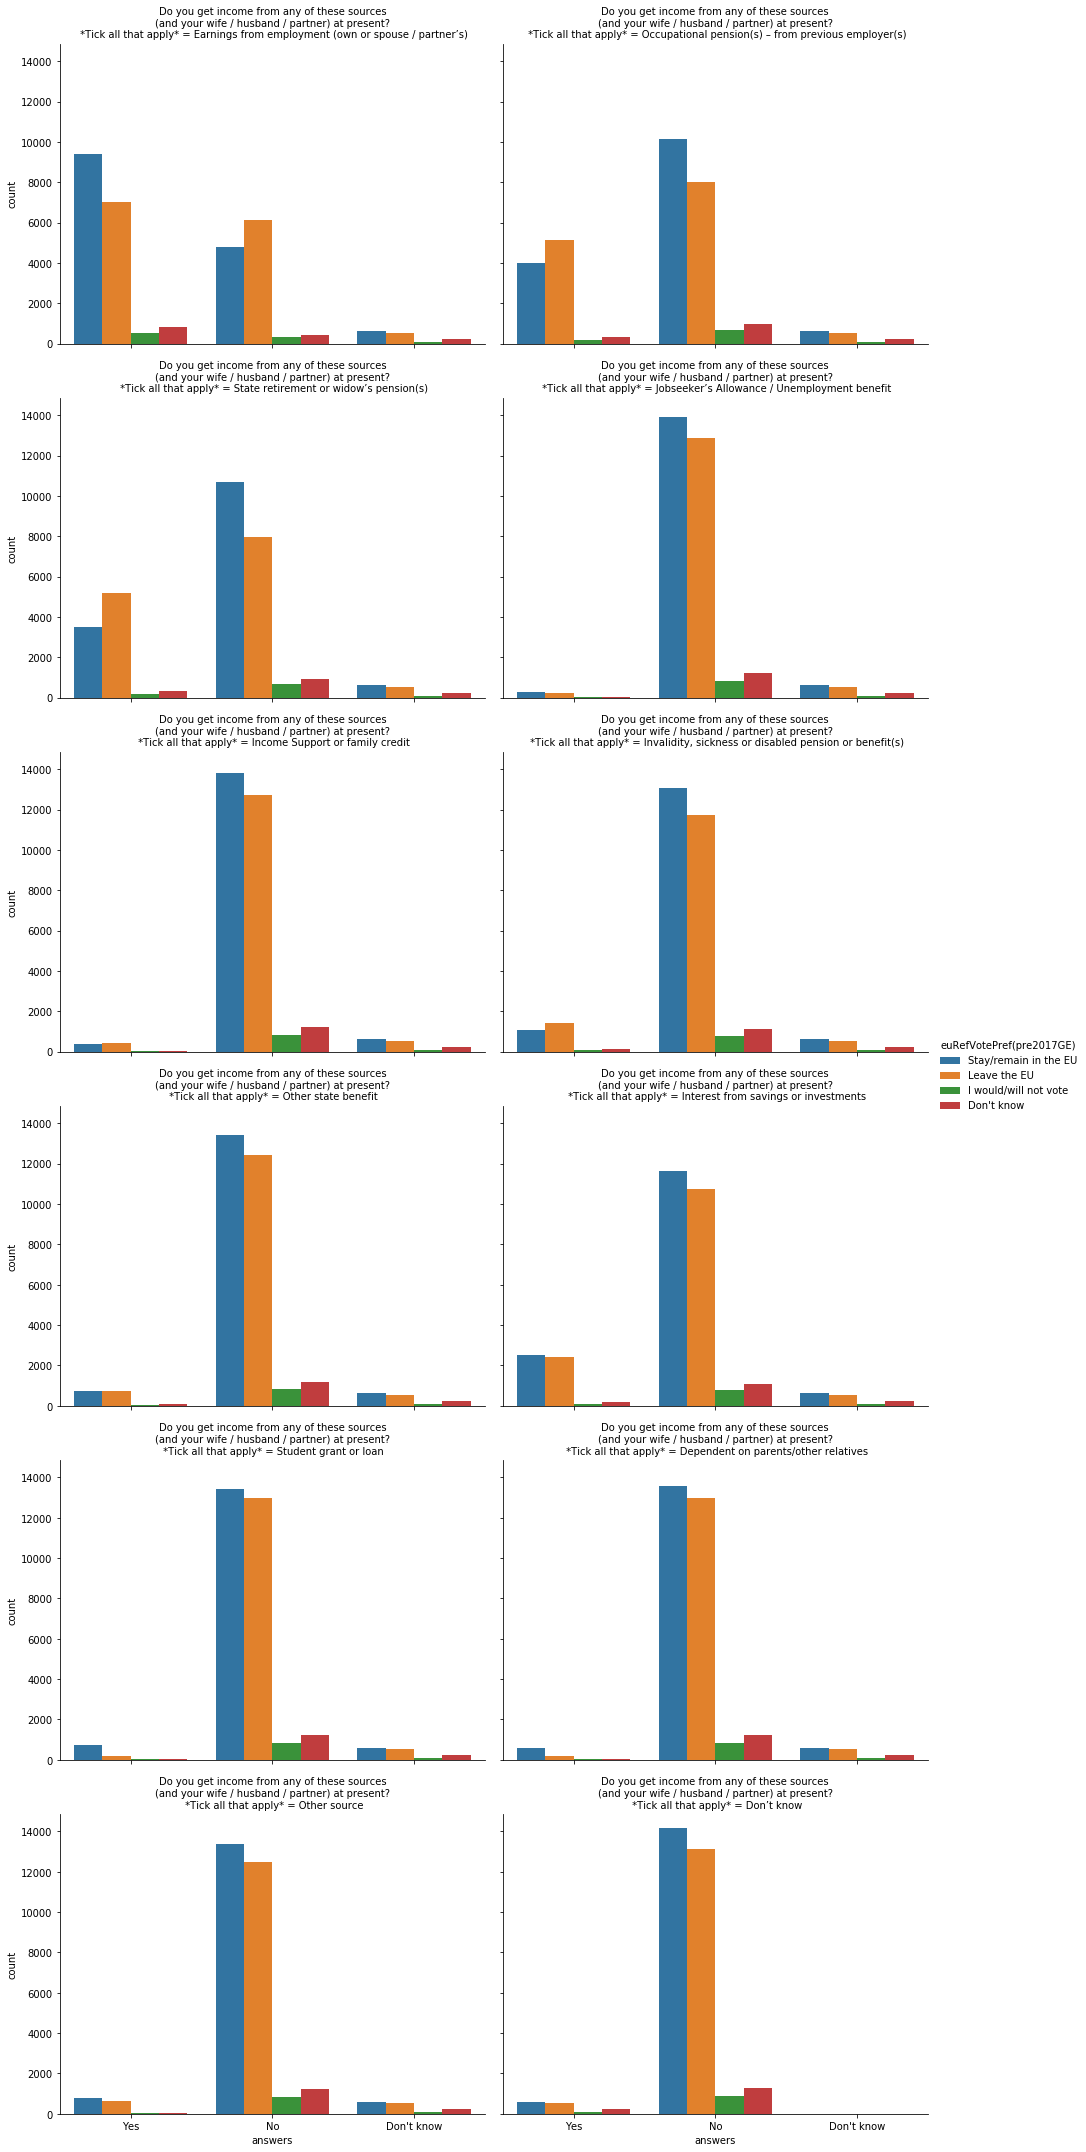

In [93]:
all_source_inc_vars = list(search(BES_Panel,"allSourceIncome_\d+W11").index)
euref_var_name = "euRefVoteW11"
euref_var = [euref_var_name]
new_euref_var_name = "euRefVotePref(pre2017GE)"

mask = (BES_Panel[all_source_inc_vars].notnull().all(axis=1))
mask = mask & (BES_Panel[euref_var].notnull())[euref_var_name]

allSource_df = BES_Panel[all_source_inc_vars+euref_var][mask].copy()
allSource_df.columns = ["Earnings from employment (own or spouse / partner’s)",
                        "Occupational pension(s) – from previous employer(s)",
                        "State retirement or widow’s pension(s)",
                        "Jobseeker’s Allowance / Unemployment benefit",
                        "Income Support or family credit",
                        "Invalidity, sickness or disabled pension or benefit(s)",
                        "Other state benefit",
                        "Interest from savings or investments",
                        "Student grant or loan",
                        "Dependent on parents/other relatives",
                        "Other source",
                        "Don’t know",
                        new_euref_var_name]

allSource_df = allSource_df.set_index(new_euref_var_name).stack().reset_index()
ques_stub = "Do you get income from any of these sources\n(and your wife / husband / partner) at present?\n *Tick all that apply*"
allSource_df.columns = [new_euref_var_name,
                        ques_stub,
                        "answers"]


sns.catplot(x="answers", hue=new_euref_var_name, col_wrap=2,
            col = ques_stub,
            data=allSource_df,
            kind='count', orient='h', aspect=1.3);
Treatment = "allSourceIncome_by_eurefvote"
output_subfolder = create_subdir(BES_output_folder,Treatment)
fname = output_subfolder +Treatment + ".png"
plt.savefig( fname, bbox_inches='tight' )


In [90]:
allSource_df["euRefVotePref(pre2017GE)"].value_counts()

Stay/remain in the EU    177276
Leave the EU             164436
Don't know                18036
I would/will not vote     11724
Name: euRefVotePref(pre2017GE), dtype: int64

In [33]:
search(BES_Panel,"personal", mask = BES_Panel["profile_eurefvote"].notnull())

econPersonalRetroW1              18792
econPersonalProspW1               3393
econPersonalRetroW2              19773
econPersonalProspW2               3714
econPersonalRetroW3              19596
econPersonalRetroW4              22589
econPersonalRetroW6               5663
econPersonalProspW6               5662
econPersonalRetroW7              25992
econPersonalRetroW8              13083
econPersonalRetroW10             27246
econPersonalProspW10             27237
econPersonalRetroW11             28321
econPersonalRetroW12              8051
econPersonalRetroW13             28546
econPersonalRetroW14             27582
profile_gross_personal           37319
personality_agreeableness        34014
personality_conscientiousness    34014
personality_extraversion         34015
personality_neuroticism          34013
personality_openness             34013
dtype: int64

In [26]:
search(BES_Panel,"age", mask = BES_Panel["profile_eurefvote"].notnull())

ageW1                       18809
likeFarageW1                18790
likeFarageW2                19763
likeFarageW3                19597
likeFarageW4                22589
likeFarageW5                22585
likeFarageW6                22530
likeFarageW7                25992
ageW7                       25992
likeFarageW8                29464
languageSkillsW8            20101
languageSkillsWelshW8        1854
ageW8                       29464
ageW9                       28248
likeFarageW9                28248
likeFarageW10               27246
integrityFarageW10           6669
competentFarageW10           6669
gayMarriageW10              27246
likeFarageW11               28321
ageW11                      28321
ageW12                      31434
competentFarageW13          14376
ageW13                      28546
mortgagePaymentW14           7994
impAgeW14                    6898
ageW14                      27582
age                         12212
ageGroup                    13436
Age           

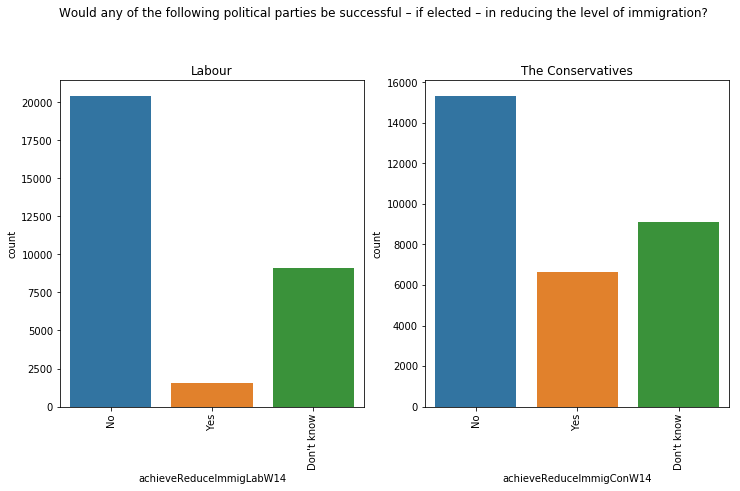

In [76]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
sns.countplot( BES_Panel["achieveReduceImmigLabW14"] , ax=ax1);
sns.countplot( BES_Panel["achieveReduceImmigConW14"] , ax=ax2);

plt.suptitle("Would any of the following political parties be successful – if elected – in reducing the level of immigration?", y=1.05);
ax1.set_title("Labour")
ax2.set_title("The Conservatives")

for ax in (ax1, ax2):
    plt.sca(ax)
    plt.xticks(rotation=90)

Treatment = "Immigration_Perception_Lab_Con"
output_subfolder = create_subdir(BES_output_folder,Treatment)
fname = output_subfolder + "AchieveReduceImmig_Lab_Con" + ".png"
plt.savefig( fname, bbox_inches='tight' )

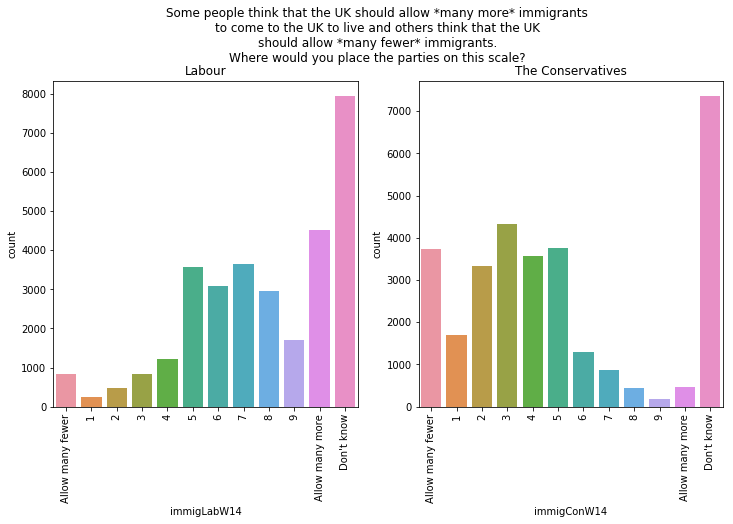

In [74]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
sns.countplot( BES_Panel["immigLabW14"] , ax=ax1);
sns.countplot( BES_Panel["immigConW14"] , ax=ax2);

plt.suptitle("Some people think that the Uf, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
sns.countplot( BES_Panel["immigLabW14"] , ax=ax1);
sns.countplot( BES_Panel["immigConW14"] , ax=ax2);

plt.suptitle("Some people think that the UK should allow *many more* immigrants\nto come to the UK to live and others think that the UK\nshould allow *many fewer* immigrants.\nWhere would you place the parties on this scale?", y=1.05);
ax1.set_title("Labour")
ax2.set_title("The Conservatives")

for ax in (ax1, ax2):
    plt.sca(ax)
    plt.xticks(rotation=90)

Treatment = "Immigration_Perception_Lab_Con"
output_subfolder = create_subdir(BES_output_folder,Treatment)
fname = output_subfolder + "Immigration_Perception_Lab_Con" + ".png"
plt.savefig( fname, bbox_inches='tight' )K should allow *many more* immigrants\nto come to the UK to live and others think that the UK\nshould allow *many fewer* immigrants.\nWhere would you place the parties on this scale?", y=1.05);
ax1.set_title("Labour")
ax2.set_title("The Conservatives")

for ax in (ax1, ax2):
    plt.sca(ax)
    plt.xticks(rotation=90)

Treatment = "Immigration_Perception_Lab_Con"
output_subfolder = create_subdir(BES_output_folder,Treatment)
fname = output_subfolder + "Immigration_Perception_Lab_Con" + ".png"
plt.savefig( fname, bbox_inches='tight' )

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

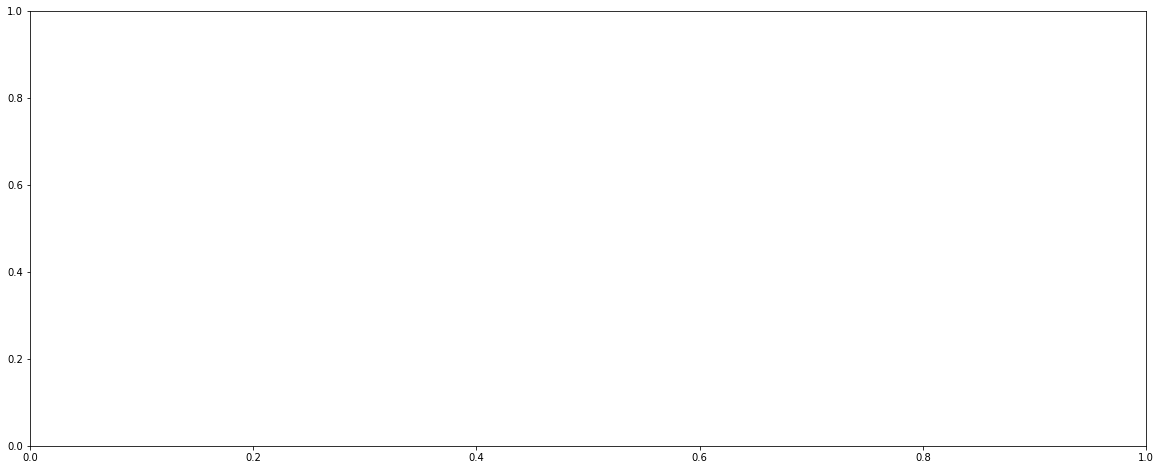

In [17]:
var1 ="profile_eurefvote"
var2 ="ethno"
# amal_al_3cat.name = var2

df1 = BES_Panel["profile_house_tenure"]
df2 = BES_Panel["profile_house_tenure"]  #amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=True,
              title="Social Liberalism-Conservativism vs Housing Tenure")



In [11]:
search(BES_Panel,"ethno")

ethno1W7     30895
ethno2W7     30895
ethno3W7     30895
ethno4W7     30895
ethno5W7     30895
ethno6W7     30895
ethno1W9      7482
ethno2W9      7482
ethno3W9      7482
ethno4W9      7482
ethno5W9      7482
ethno6W9      7482
ethno1W10    30237
ethno2W10    30237
ethno3W10    30237
ethno4W10    30237
ethno5W10    30237
ethno6W10    30237
dtype: int64

In [15]:
ethno1amal = amalgamate_waves(BES_Panel, "ethno1")
ethno2amal = amalgamate_waves(BES_Panel, "ethno2")
ethno3amal = amalgamate_waves(BES_Panel, "ethno3")
ethno4amal = amalgamate_waves(BES_Panel, "ethno4")
ethno5amal = amalgamate_waves(BES_Panel, "ethno5")
ethno6amal = amalgamate_waves(BES_Panel, "ethno6")

amalgamated_eurefvote = amalgamate_waves(BES_Panel, "euRefVoteW\d+$")

Amalgamating variables: 
{7: 'ethno1W7', 9: 'ethno1W9', 10: 'ethno1W10'}
Amalgamating variables: 
{7: 'ethno2W7', 9: 'ethno2W9', 10: 'ethno2W10'}
Amalgamating variables: 
{7: 'ethno3W7', 9: 'ethno3W9', 10: 'ethno3W10'}
Amalgamating variables: 
{7: 'ethno4W7', 9: 'ethno4W9', 10: 'ethno4W10'}
Amalgamating variables: 
{7: 'ethno5W7', 9: 'ethno5W9', 10: 'ethno5W10'}
Amalgamating variables: 
{7: 'ethno6W7', 9: 'ethno6W9', 10: 'ethno6W10'}
Amalgamating variables: 
{1: 'euRefVoteW1', 2: 'euRefVoteW2', 3: 'euRefVoteW3', 4: 'euRefVoteW4', 6: 'euRefVoteW6', 7: 'euRefVoteW7', 8: 'euRefVoteW8', 9: 'euRefVoteW9', 10: 'euRefVoteW10', 11: 'euRefVoteW11', 12: 'euRefVoteW12', 13: 'euRefVoteW13', 14: 'euRefVoteW14'}


In [ ]:
# g = sns.catplot("alive", col="deck", col_wrap=4,
#                 data=titanic[titanic.deck.notnull()],
#                 kind="count", height=2.5, aspect=.8)

In [55]:
euref_ethno = pd.concat([amalgamated_eurefvote, ethno1amal, ethno2amal, ethno3amal, ethno4amal, ethno5amal, ethno6amal], axis=1).dropna()
euref_ethno.columns = ["euRef",
                       "Britain has a lot to learn from other countries in running its affairs",
                       "I would rather be a citizen of Britain than of any other country in the world",
                       "There are some things about Britain today that make me ashamed to be British",
                       "People in Britain are too ready to criticise their country",
                       "The world would be a better place if people from other countries were more like the British",
                       "I am often less proud of Britain than I would like to be"]

flat_euref_ethno = euref_ethno.set_index("euRef").stack().reset_index()
ques_stub = "How much do you agree or disagree with the following statements?\n"
flat_euref_ethno.columns = ["euRef",ques_stub,"answers"]
flat_euref_ethno["answers"] = flat_euref_ethno["answers"].replace("Neither agree nor disagree","Neither")
order  = list(ethno1amal.cat.categories)
order = ["Neither" if x=="Neither agree nor disagree" else x for x in order]

# flat_euref_ethno

['Strongly disagree',
 'Disagree',
 'Neither',
 'Agree',
 'Strongly agree',
 "Don't know"]

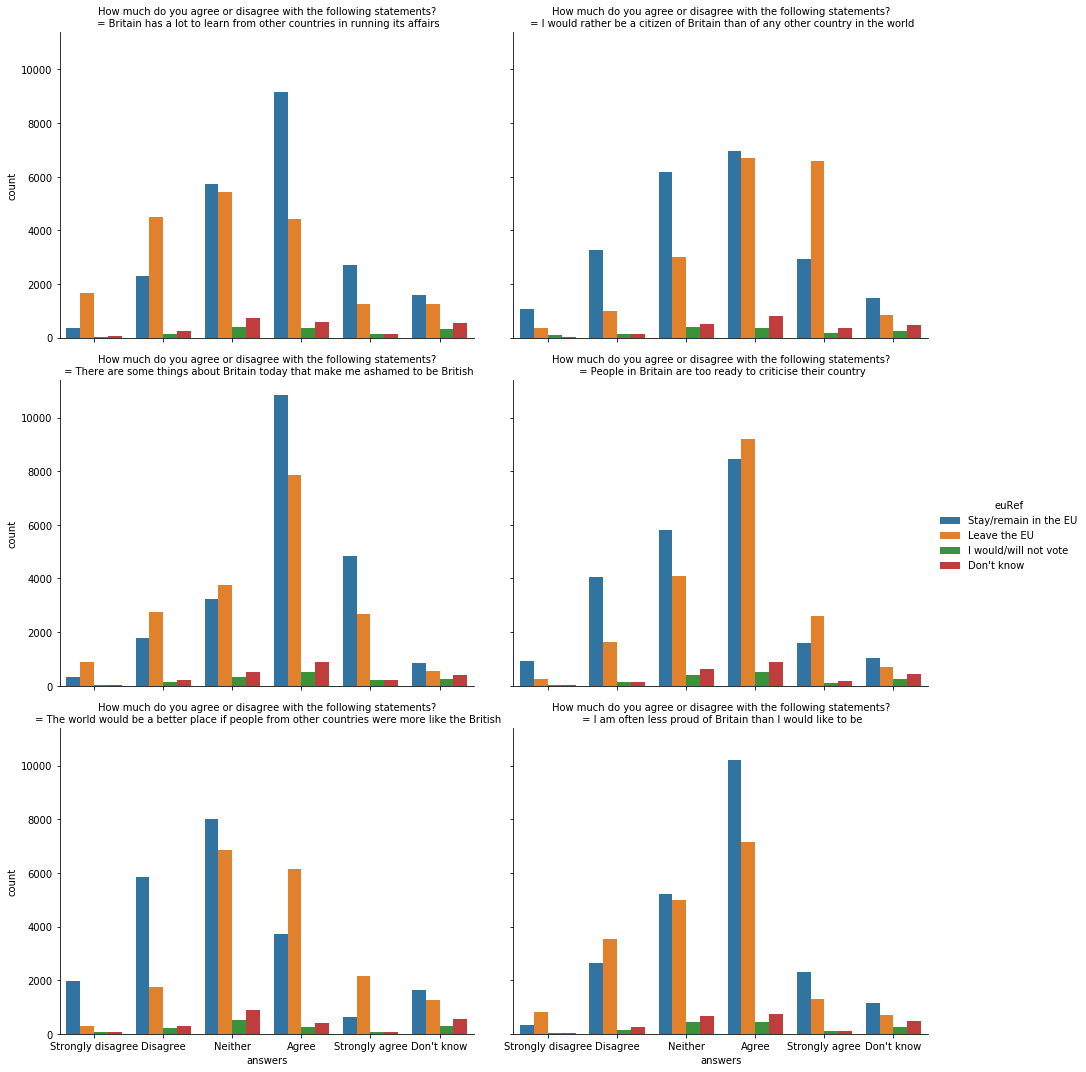

In [58]:
sns.catplot(x="answers", hue="euRef", col_wrap=2,
            col = ques_stub,
            data=flat_euref_ethno,
            kind='count', order = order, orient='h', aspect=1.3);
Treatment = "ethno_by_eurefvote"
output_subfolder = create_subdir(BES_output_folder,Treatment)
fname = output_subfolder + "ethno_by_eurefvote" + ".png"
plt.savefig( fname, bbox_inches='tight' )

In [10]:
amalgamated_eurefvote = amalgamate_waves(BES_Panel, "euRefVoteW(7|8)$", forward_fill=True)
amalgamated_eurefvote.notnull().sum()

Amalgamating variables: 
{7: 'euRefVoteW7', 8: 'euRefVoteW8'}


39964

In [10]:
amalgamated_eurefvote = amalgamate_waves(BES_Panel, "euRefVoteW", forward_fill=False)
amalgamated_eurefvote.notnull().sum()

Amalgamating variables: 
{1: 'euRefVoteW1', 2: 'euRefVoteW2', 3: 'euRefVoteW3', 4: 'euRefVoteW4', 6: 'euRefVoteW6', 7: 'euRefVoteW7', 8: 'euRefVoteW8', 9: 'euRefVoteW9', 10: 'euRefVoteW10', 11: 'euRefVoteW11', 12: 'euRefVoteW12', 13: 'euRefVoteW13', 14: 'euRefVoteW14'}


73683

In [11]:
amalgamated_age = amalgamate_waves(BES_Panel, 'age(W\d+)')
amalgamated_age.notnull().sum()

Amalgamating variables: 
{1: 'ageW1', 7: 'ageW7', 8: 'ageW8', 9: 'ageW9', 11: 'ageW11', 12: 'ageW12', 13: 'ageW13', 14: 'ageW14'}


67193

ValueError: low >= high

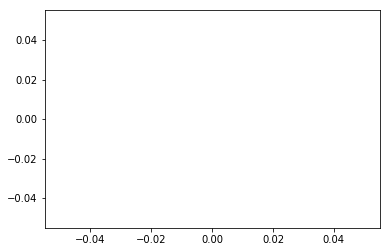

In [15]:
sns.lineplot(x=amalgamated_age, y=(amalgamated_eurefvote=="Leave the EU"))

In [19]:
amalgamated_eurefvote_minus_dk = amalgamated_eurefvote.replace("I would/will not vote",np.nan).replace("Don't know",np.nan)
mask = amalgamated_eurefvote_minus_dk.notnull()&amalgamated_age.notnull()

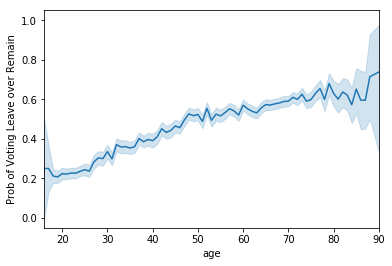

In [26]:
amal_leave = amalgamated_eurefvote_minus_dk[mask] =="Leave the EU"
sns.lineplot(x=amalgamated_age[mask].astype('float'), y=amal_leave);
plt.xlim([16,90]);
plt.xlabel('age');
plt.ylabel('Prob of Voting Leave over Remain');
Treatment = "Age_by_leave_vote"
output_subfolder = create_subdir(BES_output_folder,Treatment)
fname = output_subfolder + "Age_by_leave_vote" + ".png"
plt.savefig( fname, bbox_inches='tight' )

In [27]:
mask.sum()

57707

In [36]:
amalgamated_al_scale = amalgamate_waves(BES_Panel, "al_scale", forward_fill=False)

amal_al_3cat = pd.qcut(amalgamated_al_scale.cat.codes.replace(-1, np.nan),3)
amal_al_3cat.cat.rename_categories(["Liberal","Centrist","Authoritarian"],inplace=True)
amal_al_3cat.value_counts()

Amalgamating variables: 
{7: 'al_scaleW7W8W9', 6: 'al_scaleW6', 1: 'al_scaleW1W2W3W4W5', 10: 'al_scaleW10W11W12', 13: 'al_scaleW13', 14: 'al_scaleW14'}


Liberal          24916
Centrist         24888
Authoritarian    19392
dtype: int64

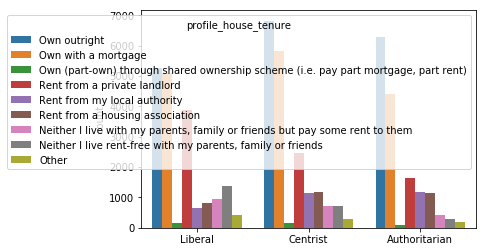

In [35]:
sns.countplot(x = amal_al_3cat, hue = BES_Panel["profile_house_tenure"])

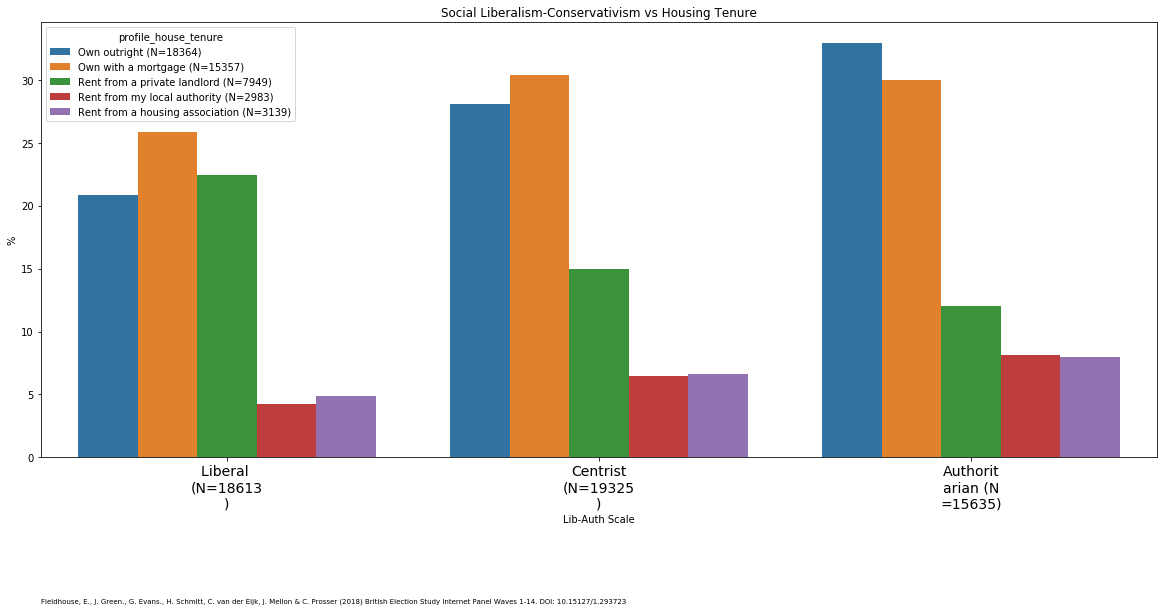

In [60]:
var1 ="profile_house_tenure"
var2 ="Lib-Auth Scale"
amal_al_3cat.name = var2

df1 = BES_Panel["profile_house_tenure"]
df2 = amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=True,
              title="Social Liberalism-Conservativism vs Housing Tenure")



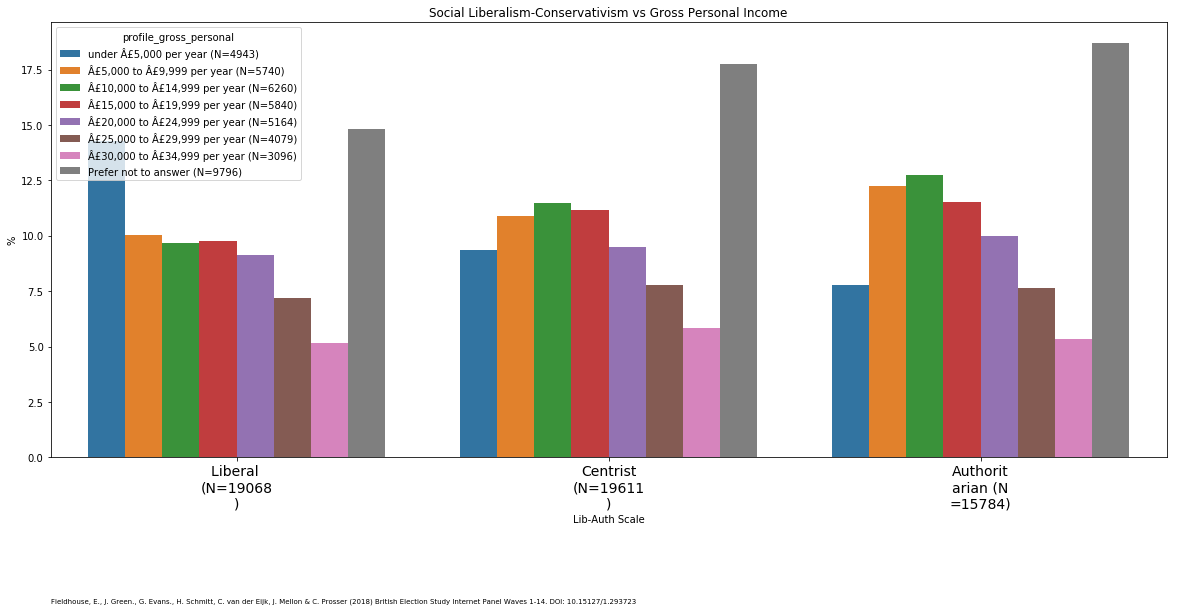

In [65]:
var1 ="profile_gross_personal"
var2 ="Lib-Auth Scale"
amal_al_3cat.name = var2

df1 = BES_Panel[var1]
df2 = amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=True,
              title="Social Liberalism-Conservativism vs Gross Personal Income")



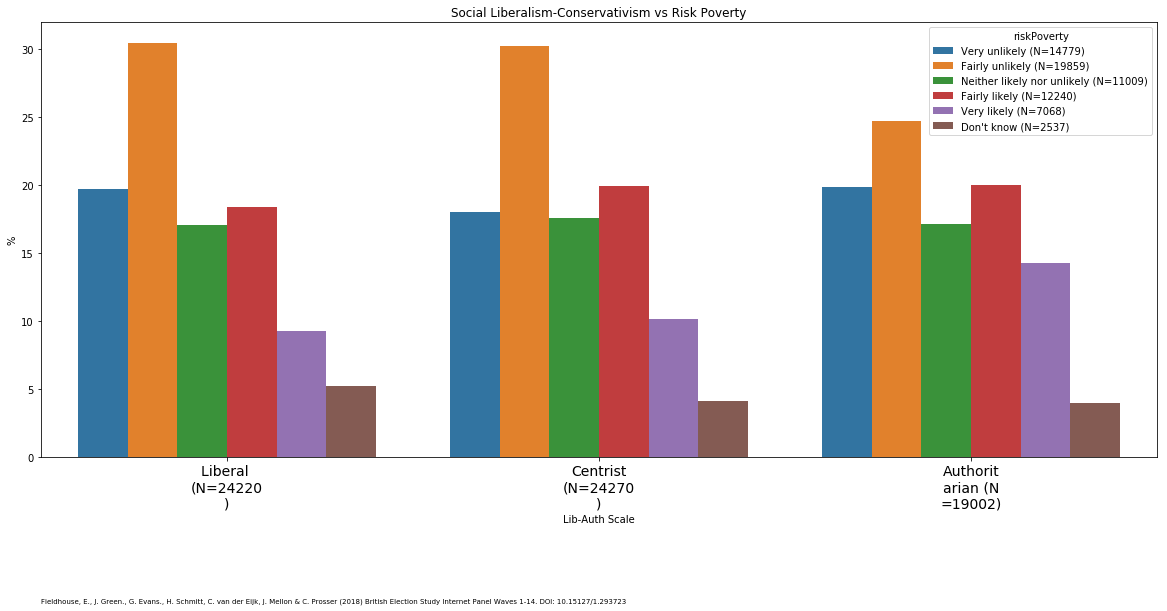

In [68]:
var1 ="riskPoverty"
var2 ="Lib-Auth Scale"
amal_al_3cat.name = var2
amalgamated_riskPoverty.name=var1

df1 = amalgamated_riskPoverty
df2 = amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=True,
              title="Social Liberalism-Conservativism vs Risk Poverty")



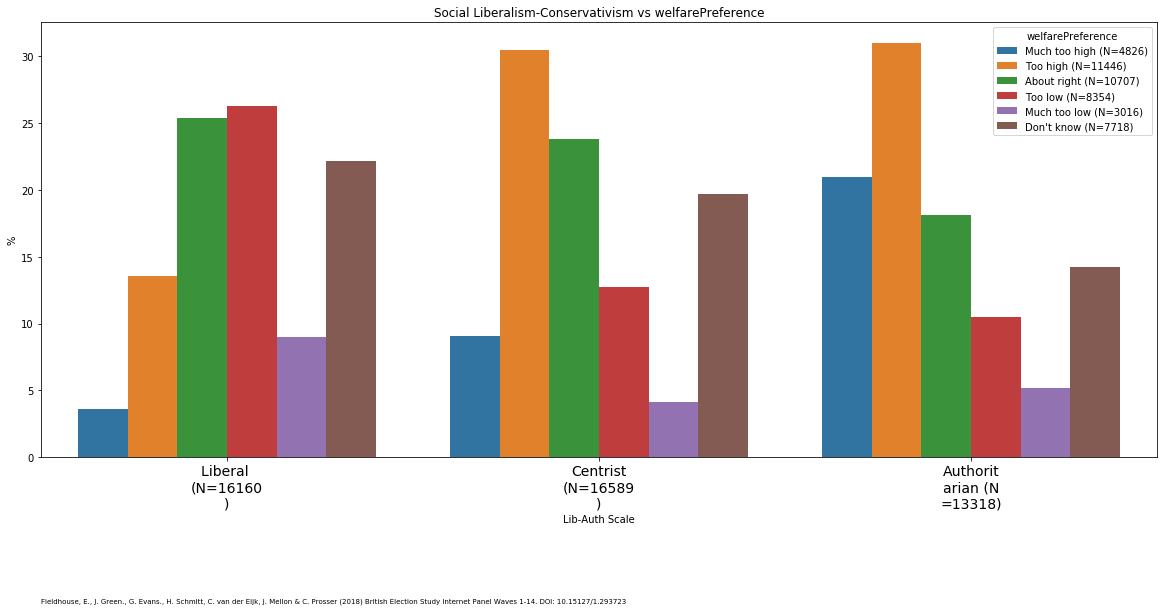

In [76]:
var1 ="welfarePreference"
var2 ="Lib-Auth Scale"
amal_al_3cat.name = var2
amalgamated_welfarePreference.name=var1

df1 = amalgamated_welfarePreference
df2 = amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              title="Social Liberalism-Conservativism vs welfarePreference")



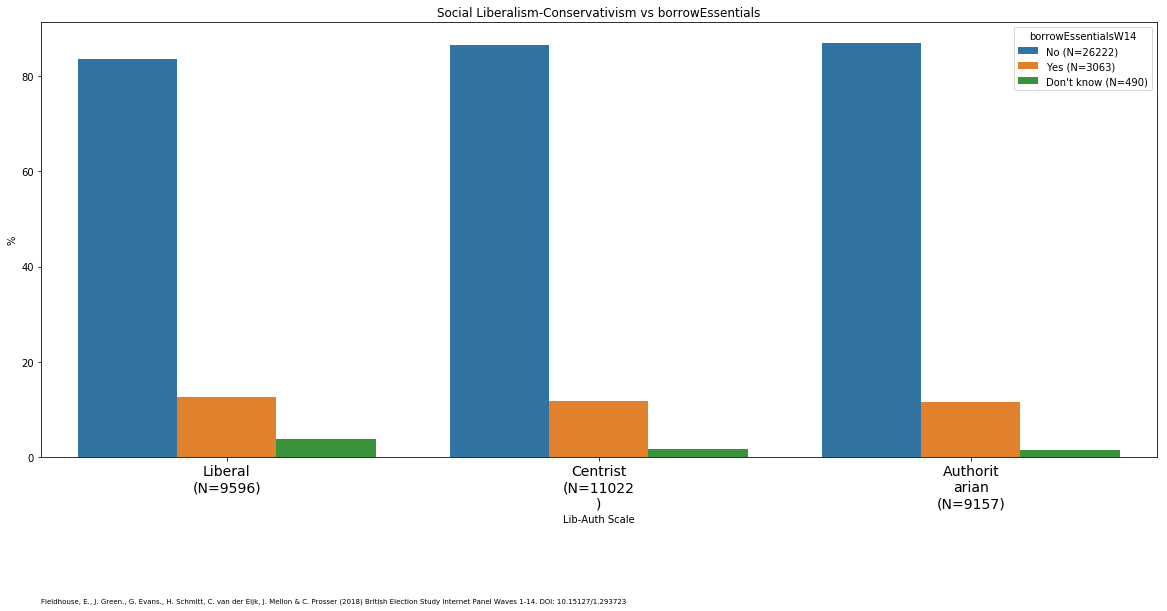

In [40]:
var1 ="borrowEssentialsW14"
var2 ="Lib-Auth Scale"
amal_al_3cat.name = var2
# amalgamated_welfarePreference.name=var1

df1 = BES_Panel[var1]
df2 = amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              title="Social Liberalism-Conservativism vs borrowEssentials")



In [75]:
BES_Panel['welfarePreferenceW2'][amal_al_3cat.notnull()].value_counts()

Too high         1630
About right      1142
Don't know        887
Too low           796
Much too high     767
Much too low      252
Name: welfarePreferenceW2, dtype: int64

In [21]:
%%time
# BES_reduced_with_na["amalgamated_riskPoverty"] = amalgamated_riskPoverty
pattern = "riskPoverty"
name = "riskPovertyW1__Very likely"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,r,p,N
riskUnemploymentW1__Very likely,0.48,0.00,26733
worryEconSecurityW14__10.0,0.43,0.00,10452
polForTheRichW1__Strongly agree,0.3,0.00,28360
profile_socgradeW7__E,0.27,0.00,15943
debtW14_Yes,0.26,0.00,10157
changeCostLiveW4__Getting a lot higher,0.26,0.00,20608
lr3W1W2W3W4W5__Strongly agree,0.25,0.00,28556
cutsTooFarNationalW1__Gone much too far,0.25,0.00,27314
lr4W1W2W3W4W5__Strongly agree,0.25,0.00,28726
cutsTooFarLocalW1__Gone much too far,0.25,0.00,26155


Wall time: 1min 3s


In [ ]:
# borrowEssentials
# 

In [48]:
search(BES_Panel,"profile_past").index

Index(['profile_past_vote_2005', 'profile_past_vote_2010',
       'profile_past_vote_2017', 'profile_past_vote_2015'],
      dtype='object')

In [49]:
prof_past = ['profile_past_vote_2005', 'profile_past_vote_2010',
       'profile_past_vote_2015']

In [60]:
search(BES_Panel,"generalElectionVote")
# euRefVoteW14    31063
# generalElectionVoteW14
Remain = BES_Panel["euRefVoteW14"]=="Stay/remain in the EU"
Conservative = BES_Panel["generalElectionVoteW14"]=="Conservative"
England = BES_Panel["country"]=="England"
ppv = BES_Panel[Conservative&Remain&England][prof_past]

In [61]:
ppv[prof_past[1]].value_counts()

Conservative Party                          1114
Liberal Democrats                            208
Did not vote                                 157
Labour Party                                 124
Don't know                                    29
United Kingdom Independence Party (UKIP)      11
Green Party                                   11
Some other party                               6
British National Party (BNP)                   2
Respect                                        0
Plaid Cymru                                    0
Scottish National Party                        0
Name: profile_past_vote_2010, dtype: int64

In [64]:
search(BES_reduced_with_na,'ptv.*ExpW14').index

Index(['ptvConExpW14__Very likely', 'ptvLabExpW14__Very likely',
       'ptvLDExpW14__Very likely', 'ptvUKIPExpW14__Very likely',
       'ptvGrnExpW14__Very likely'],
      dtype='object')

In [66]:
BES_reduced_with_na[Conservative&Remain&England][search(BES_reduced_with_na,'ptv.*ExpW14').index].describe()

,ptvConExpW14__Very likely,ptvLabExpW14__Very likely,ptvLDExpW14__Very likely,ptvUKIPExpW14__Very likely,ptvGrnExpW14__Very likely
count,412.000000,400.0000,396.000000,400.000000,389.000000
mean,8.674757,1.1125,2.881313,0.665000,1.424165
std,1.859032,2.0568,2.846906,1.730682,2.246996
min,0.000000,0.0000,0.000000,0.000000,0.000000
25%,8.000000,0.0000,0.000000,0.000000,0.000000
50%,10.000000,0.0000,2.500000,0.000000,0.000000
75%,10.000000,1.0000,5.000000,0.000000,2.000000
max,10.000000,10.0000,10.000000,10.000000,10.000000


In [33]:
BES_Panel["smallEmergency_2W14"].value_counts()

2.0           28311
Don't know     1778
Yes             974
Name: smallEmergency_2W14, dtype: int64

In [ ]:
%%time
BES_reduced_with_na["amalgamated_riskPoverty"] = amalgamated_riskPoverty
pattern = "riskPoverty"
name = "amalgamated_riskPoverty"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


'riskPovertyW1&2&3&4&6&7&8&9&10&11&14'

In [18]:
amalgamated_riskPoverty = amalgamate_waves(BES_reduced_with_na, "riskPoverty", forward_fill=False)
amalgamated_riskPoverty.name

Amalgamating variables: 
{1: 'riskPovertyW1__Very likely', 2: 'riskPovertyW2__Very likely', 3: 'riskPovertyW3__Very likely', 4: 'riskPovertyW4__Very likely', 6: 'riskPovertyW6__Very likely', 7: 'riskPovertyW7__Very likely', 8: 'riskPovertyW8__Very likely', 9: 'riskPovertyW9__Very likely', 10: 'riskPovertyW10__Very likely', 11: 'riskPovertyW11__Very likely', 14: 'riskPovertyW14__Very likely'}


In [70]:
amalgamated_welfarePreference = amalgamate_waves(BES_Panel, "welfarePreference", forward_fill=False)

Amalgamating variables: 
{2: 'welfarePreferenceW2', 3: 'welfarePreferenceW3', 4: 'welfarePreferenceW4', 6: 'welfarePreferenceW6', 7: 'welfarePreferenceW7', 11: 'welfarePreferenceW11', 14: 'welfarePreferenceW14'}


In [17]:
search(BES_reduced_with_na,"riskPoverty")

riskPovertyW1__Very likely     29069
riskPovertyW2__Very likely     28939
riskPovertyW3__Very likely     26659
riskPovertyW4__Very likely     30031
riskPovertyW6__Very likely     28790
riskPovertyW7__Very likely     29611
riskPovertyW8__Very likely      5922
riskPovertyW9__Very likely     28042
riskPovertyW10__Very likely    28539
riskPovertyW11__Very likely    29446
riskPovertyW14__Very likely    29507
dtype: int64

In [40]:
search(BES_reduced_with_na,"euRefVoteW\d+_")

euRefVoteW4_Leave the EU     26312
euRefVoteW10_Leave the EU    27697
euRefVoteW9_Leave the EU     28069
euRefVoteW7_Leave the EU     28044
euRefVoteW6_Leave the EU     25266
euRefVoteW8_Leave the EU     31008
euRefVoteW2_Leave the EU     21661
euRefVoteW13_Leave the EU    28805
euRefVoteW14_Leave the EU    28061
euRefVoteW1_Leave the EU     25130
euRefVoteW11_Leave the EU    28476
euRefVoteW3_Leave the EU     23358
euRefVoteW12_Leave the EU    31831
dtype: int64

In [63]:
eurefcorrs = BES_reduced_with_na.corrwith(BES_reduced_with_na["euRefVoteW8_Leave the EU"])

In [64]:
eurefcorrs.sort_values()

approveEUW9__Strongly approve                                           -0.707062
euUKRichW8__Strongly agree                                              -0.699203
euScepticismW7__Work towards single European government                 -0.689121
approveEUW7__Strongly approve                                           -0.678462
euLawsLevelW8__Strongly agree                                           -0.669226
euUKRichW7__Strongly agree                                              -0.666262
euRefDoOverW10_Yes                                                      -0.663029
euRefDoOverW14_Yes                                                      -0.658313
euRefDoOverW11_Yes                                                      -0.656222
euRefFinalPostW9_Yes                                                    -0.653816
euLeaveBigBusinessW8__Much more likely                                  -0.645867
euPreventWarW8__Strongly agree                                          -0.644986
euRefDoOverW13_Y

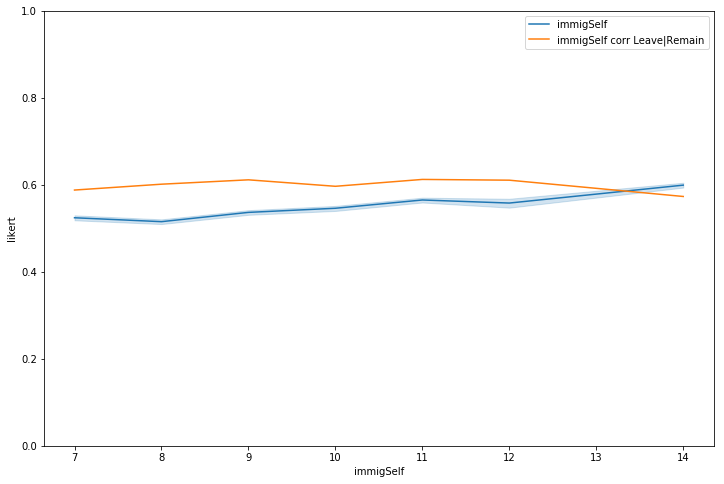

In [68]:
Treatment = "immigSelf_by_wave_and_corr_with_eurefVote"
output_subfolder = create_subdir(BES_output_folder, Treatment)

plt.figure(figsize=(12,8))
# immigSelfW7__Allow many more
# imvar = "immigSelf"
cols = search(BES_reduced_with_na,"immigSelf").index
waves = [int(re.match("immigSelfW(\d+)__",x).groups()[0]) for x in cols]
df= BES_reduced_with_na[cols]/6
df.columns = waves
stacked = df.stack().reset_index().rename(columns={0:'likert',"level_1":"immigSelf"})
stacked["immigSelf"] = stacked["immigSelf"].astype('category').cat.reorder_categories(waves)
ax = sns.lineplot(data = stacked, x = "immigSelf", y="likert", label="immigSelf");
plt.ylim(stacked["likert"].min(),stacked["likert"].max());

corrs = []
for wave in waves:
#     print(BES_reduced_with_na["euRefVoteW"+str(wave)+"_Leave the EU"].mean())
#     print(BES_reduced_with_na["immigEconW"+str(wave)+"__Good for economy"].mean())
    corrs.append(-BES_reduced_with_na["euRefVoteW"+str(wave)+"_Leave the EU"].corr(BES_reduced_with_na["immigSelfW"+str(wave)+"__Allow many more"]))
#     print(BES_reduced_with_na["euRefVoteW"+str(wave)+"_Leave the EU"].corr(BES_reduced_with_na["immigEconW"+str(wave)+"__Good for economy"]))
sns.lineplot(ax=ax, x=waves, y=corrs, label="immigSelf corr Leave|Remain");
plt.ylim([0,1]);
title = "immigSelf: Some people think that the UK should allow *many more* immigrants to come to the UK to live and others think that the UK should allow *many fewer* immigrants. Where would you place yourself and the parties on this scale?"

fname = output_subfolder + "immigSelf_by_wave_and_corr_with_eurefVote" + ".png"
plt.savefig( fname, bbox_inches='tight' )

In [48]:
plt.figure(figsize=(12,8))

cols = search(BES_reduced_with_na,"immigEcon").index
waves = [int(re.match("immigEconW(\d+)__",x).groups()[0]) for x in cols]
df= BES_reduced_with_na[cols]/6
df.columns = waves
stacked = df.stack().reset_index().rename(columns={0:'likert',"level_1":"immigEcon"})
stacked["immigEcon"] = stacked["immigEcon"].astype('category').cat.reorder_categories(waves)
ax = sns.lineplot(data = stacked, x = "immigEcon", y="likert", label="immigEcon");
plt.ylim(stacked["likert"].min(),stacked["likert"].max());

corrs = []
for wave in waves:
#     print(BES_reduced_with_na["euRefVoteW"+str(wave)+"_Leave the EU"].mean())
#     print(BES_reduced_with_na["immigEconW"+str(wave)+"__Good for economy"].mean())
    corrs.append(-BES_reduced_with_na["euRefVoteW"+str(wave)+"_Leave the EU"].corr(BES_reduced_with_na["immigEconW"+str(wave)+"__Good for economy"]))
#     print(BES_reduced_with_na["euRefVoteW"+str(wave)+"_Leave the EU"].corr(BES_reduced_with_na["immigEconW"+str(wave)+"__Good for economy"]))
sns.lineplot(ax=ax, x=waves, y=corrs, label="immigEcon corr Leave|Remain");
plt.ylim([0,1]);

[-0.5486133330870787,
 -0.5854394887936015,
 -0.5681409454748365,
 -0.5637465953235029,
 -0.564375345795741,
 -0.5736370921074672,
 -0.5264728290960424,
 -0.5290646428639084,
 -0.5482372086744626,
 -0.5106039556485504]

In [30]:
waves

['1', '2', '3', '4', '7', '8', '10', '11', '13', '14']

In [21]:
def display_corr(df, name, corr_type, top_num = 20, round_places = 2,
                 correlation_text = "r", p_value_text = "p", sample_size_text = "N",
                 text_wrap_length=50):
#     df.index = [x[0:60] for x in df.index]
    df.index =  [trim_strings(x) for x in df.index.str.wrap(width = text_wrap_length)]
    
    df[correlation_text] = df[correlation_text].round(round_places)
    
    df1 = df.sort_values(by=correlation_text, ascending=False)[0:top_num][[correlation_text,p_value_text,sample_size_text]]
    df2 = df.sort_values(by=correlation_text)[0:top_num][[correlation_text,p_value_text,sample_size_text]]
    
    df1[p_value_text]     = df1[p_value_text].apply(lambda x: "{0:0.2f}".format(x))
    df2[p_value_text]     = df2[p_value_text].apply(lambda x: "{0:0.2f}".format(x))

    df1_caption = "Top "+str(top_num)+ " positive "+"("+corr_type+")"+" correlations for "+name
    df2_caption = "Top "+str(top_num)+ " negative "+"("+corr_type+")"+" correlations for "+name

    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption(df1_caption)
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption(df2_caption)

    display_html(df1_styler._repr_html_().replace("\\n","<br />")+df2_styler._repr_html_().replace("\\n","<br />"), raw=True)


In [18]:
def trim_strings(x):
    if len( x.split("\n") )>1:
        return x.split("\n")[0] + "[...]"
    else:
        return x

In [19]:
def make_corr_summary(input_df, name, corr_type = "spearman", sample_size_text = "N", correlation_text = "r",
                      abs_correlation_text = "abs_r", p_value_text = "p",
                      min_p_value = 0.01, min_variance = 0.0, min_sample_size = 500):

    df1 = input_df.copy()
    focal_var = df1[name]
    focal_mask = focal_var.notnull()


    pattern_list = [x for x in df1.columns if re.search(pattern,x)]

    variances = df1[focal_mask].var()
    low_var_list = list(variances[variances<min_variance].index)
    sample_sizes = df1[focal_mask].notnull().sum()
    low_sample_size_list = list(sample_sizes[sample_sizes<min_sample_size].index)

    drop_list = pattern_list+low_var_list+low_sample_size_list
    df1.drop(drop_list,axis=1,inplace=True)

    if corr_type == "pearson":
        df = df1.apply(lambda x: corr_simple_pearsonr(x,focal_var)).apply(pd.Series)
    elif corr_type == "spearman":
        df = df1.apply(lambda x: corr_simple_spearmanr(x,focal_var)).apply(pd.Series)

    if len(df.columns)!=3:
        df=df.T
    df.columns = [correlation_text,p_value_text,sample_size_text]
 
    df[sample_size_text] = df[sample_size_text].astype('int')
    df[abs_correlation_text] = df[correlation_text].abs()

    zero_var_other_way_around_list = list(df[df[correlation_text].isnull()].index)
    df.dropna(inplace=True)

    insignificant_list = df[df[p_value_text]>min_p_value].index
    df.drop(insignificant_list,inplace=True)

    df.sort_values(by=abs_correlation_text,ascending=False,inplace=True)


    stub_dict = {}
    drop_list = []
    # drop repeated references to same variable in different waves???
    # so, what about different categories??? eg. blahWX_subcat
    # how about, just replace wave match as "X"
    # create a dictionary keyed on the top corr variable with all the drops inside
    for ind in df.index:
        waveless = remove_wave(ind)
        if waveless in stub_dict.keys():
            drop_list.append(ind)
            stub_dict[waveless].append(ind)
        else:
            stub_dict[waveless] = [ind]
    df.drop(drop_list,inplace=True)
    return df, corr_type

In [27]:
search(BES_Panel,"profile_past")

profile_past_vote_2005    58280
profile_past_vote_2010    64996
profile_past_vote_2017    37245
profile_past_vote_2015    57064
dtype: int64

In [47]:
search(BES_Panel,"pano")

panoW11    48507
panoW12    34393
panoW13    30985
panoW14    32578
panoW2     30467
panoW3     27837
panoW6     28582
dtype: int64

In [36]:
cat_dictionary["profile_past_vote_2017"]

Index(['Conservative', 'Labour', 'Liberal Democrat',
       'Scottish National Party (SNP)', 'Plaid Cymru',
       'United Kingdom Independence Party (UKIP)', 'Green Party',
       'British National Party (BNP)'],
      dtype='object')

In [44]:

# df1[NotLabour2015&Labour2017].value_counts()

NameError: name 'Labour2017' is not defined

In [45]:
df1 = BES_Panel["profile_past_vote_2017"].replace(9999.0, np.nan).astype('category').cat.rename_categories(cat_dictionary["profile_past_vote_2017"])
NotLabour2015 = BES_Panel["profile_past_vote_2015"]!="Labour"
Labour2017 = df1=="Labour"
England = BES_Panel["country"] =="England"

In [ ]:
    mask = ser1.notnull() & ser2.notnull()
    ct = pd.crosstab( ser1, ser2,
                      values= get_all_weights(mask), aggfunc=sum, normalize=normalize)*100

In [65]:
100*BES_Panel["profile_eurefvote"][NotLabour2015&Labour2017&England].value_counts()/BES_Panel["profile_eurefvote"][NotLabour2015&Labour2017&England].value_counts().sum()

Stay/remain in the EU    61.322043
Leave the EU             38.104343
Don't know                0.573614
Name: profile_eurefvote, dtype: float64

In [68]:
100*BES_Panel["euRefVoteW14"][NotLabour2015&Labour2017&England].value_counts()/BES_Panel["euRefVoteW14"][NotLabour2015&Labour2017&England].value_counts().sum()

Stay/remain in the EU    60.867966
Leave the EU             30.305259
Don't know                6.693637
I would/will not vote     2.133137
Name: euRefVoteW14, dtype: float64

In [66]:
100*BES_Panel["profile_eurefvote"][NotLabour2015&Labour2017&England&One_of_the_seats_Labour_gained].value_counts()/BES_Panel["profile_eurefvote"][NotLabour2015&Labour2017&England&One_of_the_seats_Labour_gained].value_counts().sum()

Stay/remain in the EU    61.187215
Leave the EU             36.529680
Don't know                2.283105
Name: profile_eurefvote, dtype: float64

In [69]:
100*BES_Panel["euRefVoteW14"][NotLabour2015&Labour2017&England&One_of_the_seats_Labour_gained].value_counts()/BES_Panel["euRefVoteW14"][NotLabour2015&Labour2017&England&One_of_the_seats_Labour_gained].value_counts().sum()

Stay/remain in the EU    62.111801
Leave the EU             29.813665
Don't know                6.832298
I would/will not vote     1.242236
Name: euRefVoteW14, dtype: float64

In [52]:
pano_where_lab_gained = [ 38,  41,  97, 100, 111, 125, 127, 158, 169, 170, 181, 238, 273,
       314, 332, 338, 340, 368, 451, 453, 458, 464, 536, 546, 588, 600,
       601, 607]

In [56]:
search(BES_Panel,'euRefVote')

euRefVoteW1                30327
euRefVoteW2                25798
euRefVoteW3                27830
euRefVoteW4                31442
euRefVoteW6                30150
euRefVoteW7                30895
euRefVoteSqueezeW7          4717
euRefVoteUnsqueezeW7       30895
euRefVotePostW8             4326
euRefVoteW8                33501
euRefVoteSqueezeW8          3818
euRefVoteUnsqueezeW8       29175
euRefVote2W8               29175
euRefVoteHypotheticalW9     1788
euRefVoteW9                28248
euRefVoteW10               30237
euRefVoteW11               30956
euRefVoteW12               34394
euRefVoteW13               31136
euRefVoteW14               31063
profile_eurefvote          49745
dtype: int64

In [53]:
amalgamate_pano = amalgamate_waves(BES_Panel, "pano", forward_fill=True)

Amalgamating variables: 
{11: 'panoW11', 12: 'panoW12', 13: 'panoW13', 14: 'panoW14', 2: 'panoW2', 3: 'panoW3', 6: 'panoW6'}


In [61]:
One_of_the_seats_Labour_gained = amalgamate_pano.apply(lambda x: x in pano_where_lab_gained)
One_of_the_seats_Labour_gained.name = "One_of_the_seats_Labour_gained"

In [36]:
# One_of_the_seats_Labour_gained

In [26]:
# pd.crosstab( df1, df2 )

euRefInterestW8,Not at all interested,Not very interested,Somewhat interested,Very interested,Don't know
profile_eurefturnout,,,,,
"No, did not vote",324,271,590,520,92
"Yes, voted",399,1349,8117,19354,245
Don't know,12,21,44,47,51


ValueError: err must be [ scalar | N, Nx1 or 2xN array-like ]

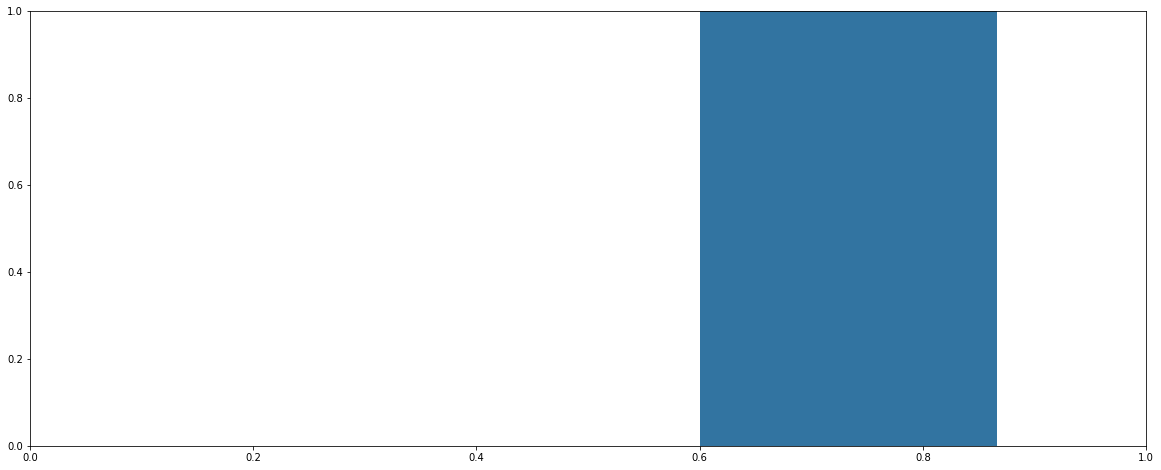

In [30]:
var1 ="profile_eurefturnout"
var2 ="euRefInterestW8"

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              title="How interested are you in the EU referendum that will be held on June 23rd?")



In [ ]:
%debug


> c:\programdata\anaconda3\envs\bes_analysis\lib\site-packages\matplotlib\axes\_axes.py(3186)extract_err()
   3184                 fe = safe_first_element(err)
   3185                 if len(err) != len(data) or np.size(fe) > 1:
-> 3186                     raise ValueError("err must be [ scalar | N, Nx1 "
   3187                                      "or 2xN array-like ]")
   3188             # using list comps rather than arrays to preserve units

ipdb> up
> c:\programdata\anaconda3\envs\bes_analysis\lib\site-packages\matplotlib\axes\_axes.py(3245)errorbar()
   3243 
   3244         if yerr is not None:
-> 3245             lower, upper = extract_err(yerr, y)
   3246             # select points without upper/lower limits in y and
   3247             # draw normal errorbars for these points

ipdb> up
> c:\programdata\anaconda3\envs\bes_analysis\lib\site-packages\matplotlib\__init__.py(1805)inner()
   1803                         "the Matplotlib list!)" % (label_namer, func.__name__),
   

ipdb> stacked
         profile_eurefturnout                euRefInterestW8          %
0   No, did not vote (N=1797)  Not at all interested (N=735)  57.492584
1   No, did not vote (N=1797)   Not very interested (N=1641)  22.982514
2   No, did not vote (N=1797)   Somewhat interested (N=8751)   9.477409
3   No, did not vote (N=1797)      Very interested (N=19921)   3.937203
4   No, did not vote (N=1797)             Don't know (N=388)  27.963375
5        Yes, voted (N=29464)  Not at all interested (N=735)  40.776556
6        Yes, voted (N=29464)   Not very interested (N=1641)  74.829872
7        Yes, voted (N=29464)   Somewhat interested (N=8751)  89.799154
8        Yes, voted (N=29464)      Very interested (N=19921)  95.741144
9        Yes, voted (N=29464)             Don't know (N=388)  55.274130
10         Don't know (N=175)  Not at all interested (N=735)   1.730861
11         Don't know (N=175)   Not very interested (N=1641)   2.187614
12         Don't know (N=175)   Somewhat intereste

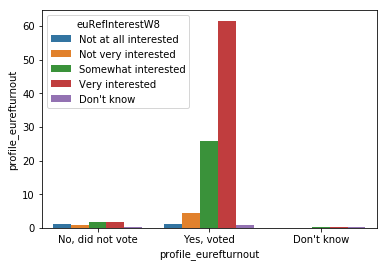

In [26]:
var1 ="profile_eurefturnout"
var2 ="euRefInterestW8"

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]
mask = df1.notnull()&df2.notnull()

# sns.barplot(x=var1,hue=var2,data=BES_Panel[[var1,var2]][mask], orient='v')
ax = sns.barplot(x=var1, y=var1, hue=var2, data=BES_Panel[[var1,var2]][mask],
                 estimator=lambda x: len(x) / sum(mask) * 100, orient='v')
# ax.set(ylabel="Percent")

In [348]:
search(BES_reduced_with_na,"Amtb")

homeAmtbW14__£1 million or above     18139
savingsAmtbW14__£200,000 or above    12850
debtAmtbW14__£200,000 or above        6937
dtype: int64

In [383]:
%%time

pattern = "debtAmtbW14"
name = "debtAmtbW14__£200,000 or above"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
"profile_gross_householdW10__£150,000 and over",0.26,0.00,3300
"profile_gross_personal__£100,000 and over",0.22,0.00,4155
profile_house_tenure_Own with a mortgage,0.2,0.00,4202
mainSourceIncomeW6_Earnings from employment (own[...],0.19,0.00,620
profile_house_tenureW13_Own - with a mortgage,0.19,0.00,4070
allSourceIncome_1W6_Yes,0.18,0.00,2513
housing_Buying leasehold/freehold on a mortgage,0.18,0.00,2320
homeOwnW14_Own with a mortgage,0.17,0.00,6816
workingStatusW1W2W3W4W5_Working full time (30 or[...],0.16,0.00,2817
profile_work_statW11_Working full time (30 or more[...],0.16,0.00,3826


Wall time: 31.6 s


In [351]:
%%time

pattern = "homeAmtbW14"
name = "homeAmtbW14__£1 million or above"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type)


,r,p,N
mapMiddleClassW3,0.42,0.00,3862
"profile_gross_householdW11__£150,000 and over",0.39,0.00,10241
mapConW3,0.38,0.00,3734
gorW2_London,0.37,0.00,7593
"savingsAmtbW14__£200,000 or above",0.37,0.00,10018
"subjClassW2_W4W7W9_Yes, middle class",0.33,0.00,11953
"subjClassW12W14_Yes, middle class",0.32,0.00,14550
winConstituencyConW4__100 - Very likely to win,0.29,0.00,8160
localEconNowW12__Very good,0.28,0.00,5849
gorW14_South East,0.26,0.00,18139


Wall time: 49.1 s


In [384]:
%%time

pattern = "savingsAmtbW14"
name = "savingsAmtbW14__£200,000 or above"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
homeOwnW14_Owned outright,0.48,0.00,12685
profile_house_tenureW10_Own outright,0.47,0.00,7666
profile_house_tenureW12_Own - outright,0.47,0.00,8823
allSourceIncome_8W11_Yes,0.47,0.00,8314
housing_Own the leasehold/freehold outright,0.41,0.00,5390
homeAmtbW14__£1 million or above,0.37,0.00,10018
ageW14,0.36,0.00,12850
ageGroup__66+,0.35,0.00,3109
allSourceIncome_2W11_Yes,0.35,0.00,8314
mainSourceIncomeW11_Occupational pension(s) - from[...],0.32,0.00,8231


Wall time: 44.1 s


In [387]:
%%time

pattern = "strongLeader"
name = "strongLeaderW14__Strongly agree"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
al_scaleW14__Authoritarian,0.5,0.00,26095
nhsEUW14__Strongly agree,0.46,0.00,24634
al2W14__Strongly agree,0.46,0.00,27599
overseasAidW14__Strongly agree,0.45,0.00,27895
immigrantsWelfareStateW7__Strongly agree,0.43,0.00,14134
immigContributeTakeW8__Get more than they pay,0.42,0.00,13846
euPriorityBalanceW14__Control immigration,0.41,0.00,25731
taxSpendUKIPW14__Government should increase taxes[...],0.4,0.00,15074
aom7W7__Strongly agree,0.39,0.00,3531
authLong2W10__Strongly agree,0.39,0.00,4043


Wall time: 1min


In [388]:
search(BES_reduced_with_na,"euRefVoteW14")

euRefVoteW14_Leave the EU    28061
dtype: int64

In [390]:
search(BES_reduced_with_na,"strongLeader",mask=BES_Panel[var1].notnull())

strongLeaderW10__Strongly agree    25020
strongLeaderW11__Strongly agree    26051
strongLeaderW14__Strongly agree    25758
dtype: int64

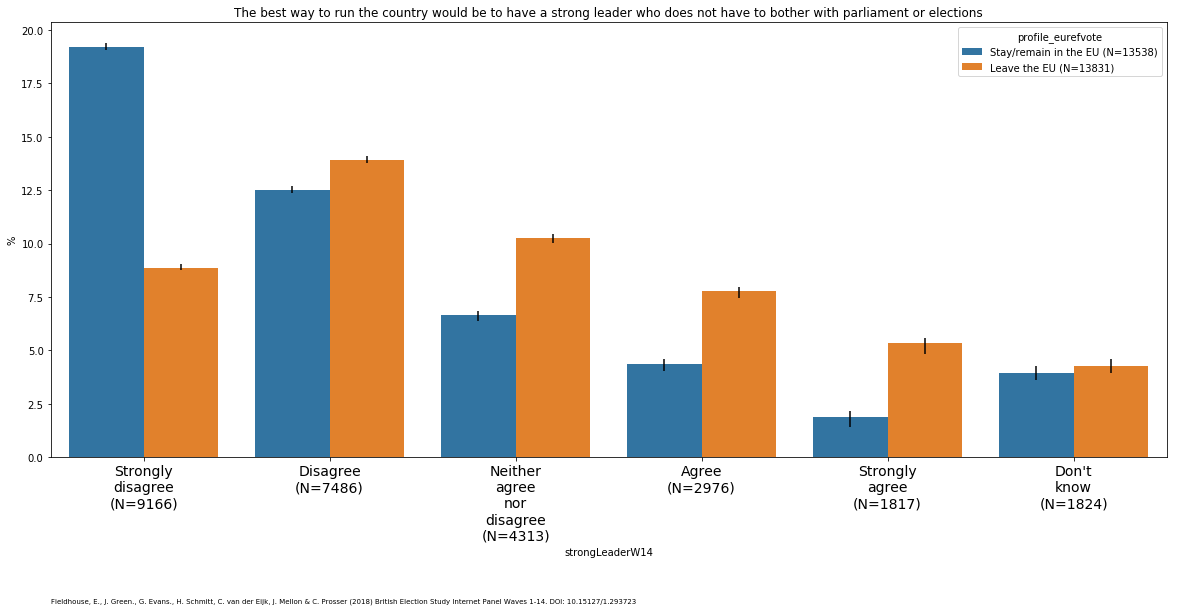

In [442]:
var1 ="profile_eurefvote"
var2 ="strongLeaderW14"

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=100, normalize='all', title="The best way to run the country would be to have a strong leader who does not have to bother with parliament or elections")



In [424]:
ct

strongLeaderW14,Strongly disagree,Disagree,Neither agree nor disagree,Agree,Strongly agree,Don't know
profile_eurefvote,,,,,,
Stay/remain in the EU,19.195689,12.528686,6.651277,4.372655,1.898113,3.942277
Leave the EU,8.881913,13.922983,10.267811,7.767514,5.334059,4.287151
Don't know,0.144244,0.194044,0.256554,0.104004,0.052247,0.198781


In [425]:
errors

strongLeaderW14,Strongly disagree,Disagree,Neither agree nor disagree,Agree,Strongly agree,Don't know
profile_eurefvote,,,,,,
Stay/remain in the EU,0.242112,0.214581,0.166804,0.139324,0.091429,0.136265
Leave the EU,0.166813,0.219402,0.198562,0.175004,0.144006,0.138874
Don't know,0.021503,0.027442,0.036651,0.022696,0.013963,0.034091


ValueError: err must be [ scalar | N, Nx1 or 2xN array-like ]

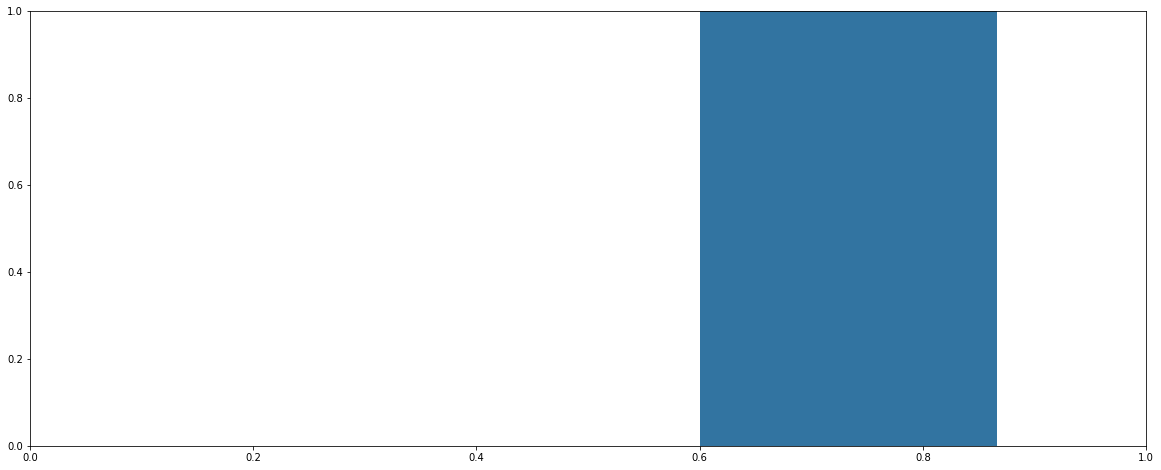

In [434]:
var1 ="profile_eurefvote"
var2 ="debtAmtbW14"

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]
df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=100)


In [429]:
# %debug

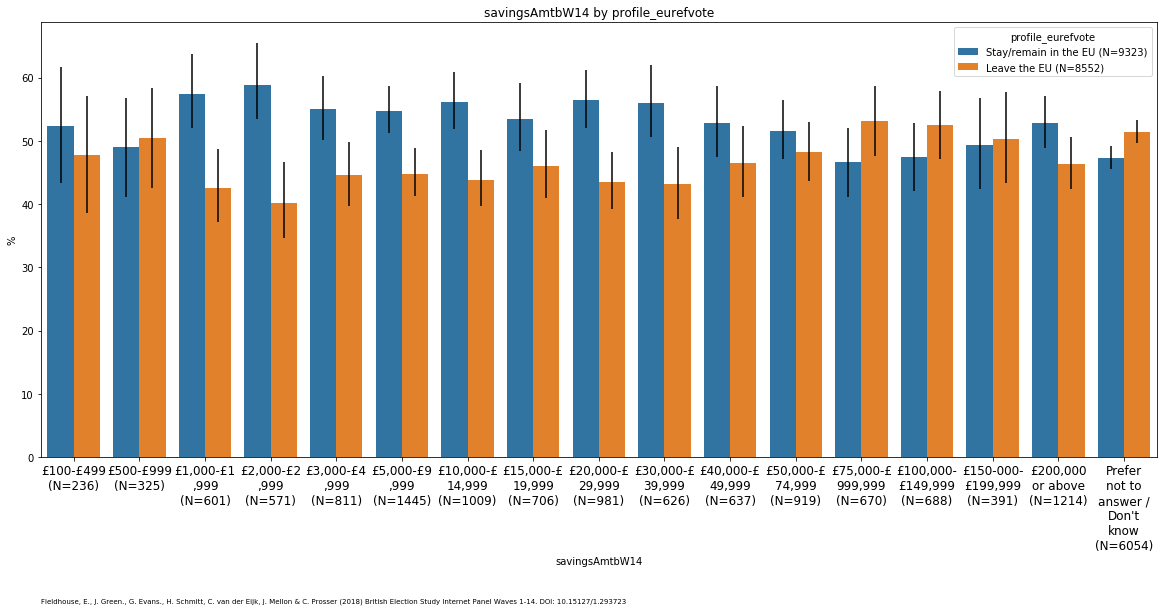

In [267]:
var1 ="profile_eurefvote"
var2 ="savingsAmtbW14"

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]
df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=100, text_width=9, text_fontsize=12)


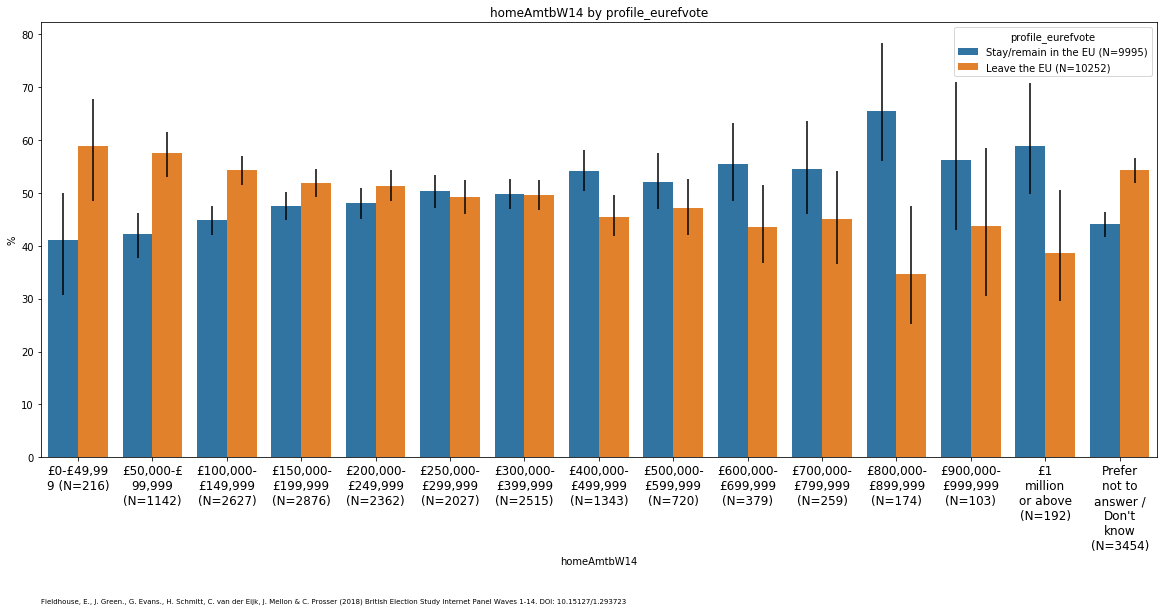

In [284]:
var1 ="profile_eurefvote"
var2 ="homeAmtbW14"

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]
df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=100, text_width=9, text_fontsize=12)


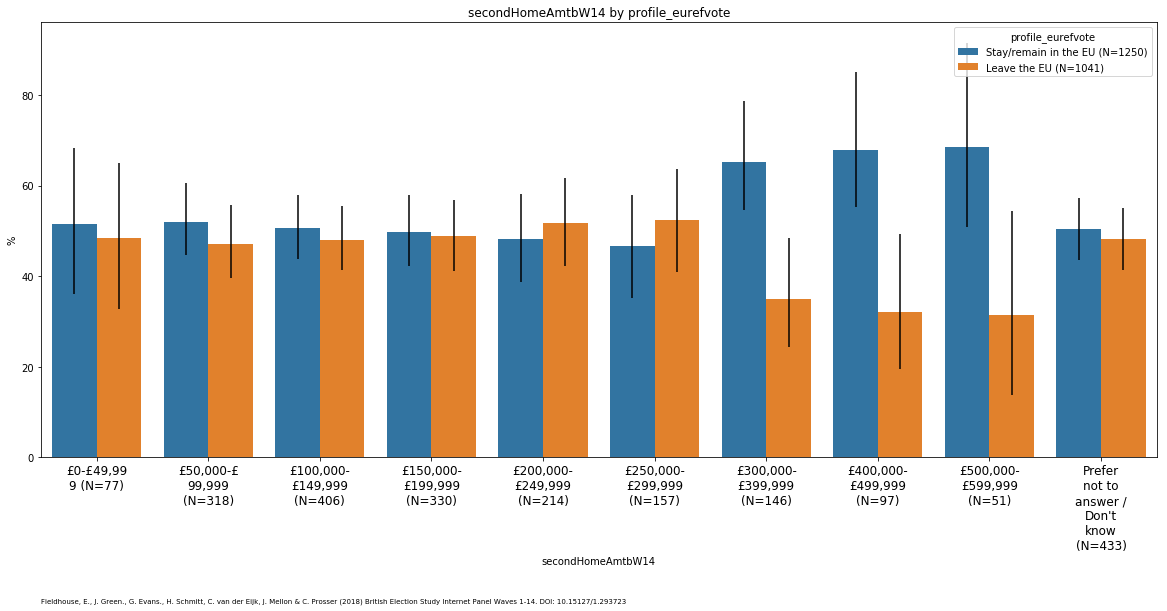

In [340]:
var1 ="profile_eurefvote"
var2 ="secondHomeAmtbW14"

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]
df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


nice_bar_plot(df1, df2, min_sample_size=50, text_width=9, text_fontsize=12)


In [100]:
search(BES_Panel,"amtb",case_sensitive=False)

homeAmtbW14          21912
secondHomeAmtbW14     2501
savingsAmtbW14       19367
debtAmtbW14           8650
dtype: int64

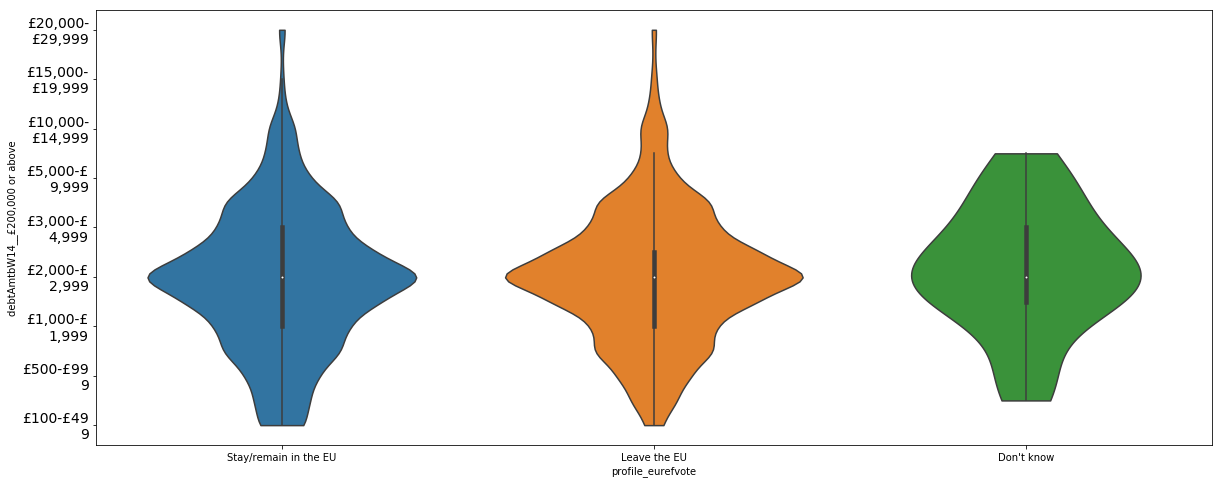

In [49]:
var1 ="profile_eurefvote"
# var2 ="profile_gross_household"
var2 = "debtAmtbW14__£200,000 or above"
sorted_labels = cat_dictionary["debtAmtbW14"]

text_width =8
import textwrap 

wrapper = textwrap.TextWrapper(width=text_width)  

fig = plt.figure(figsize=(20, 8))
ax = fig.subplots()
sns.violinplot( BES_Panel[var1], BES_reduced_with_na[var2], cut = 0, ax=ax );
ax.set_yticklabels([ wrapper.fill(text=x) for x in sorted_labels], rotation=0, fontsize=14);

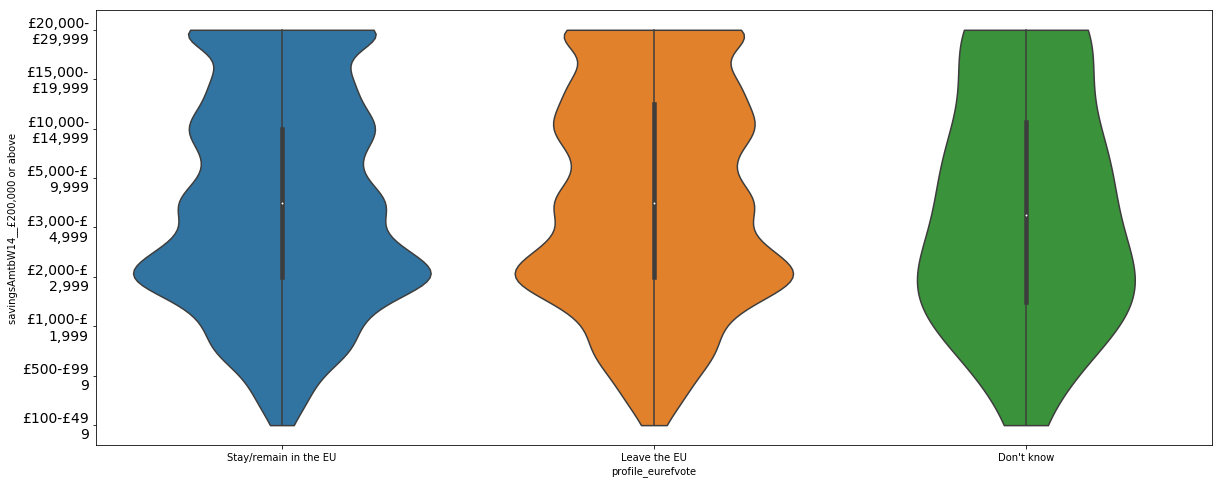

In [51]:
var1 ="profile_eurefvote"
# var2 ="profile_gross_household"
var2 = "savingsAmtbW14__£200,000 or above"
sorted_labels = cat_dictionary["savingsAmtbW14"]

text_width =8
import textwrap 

wrapper = textwrap.TextWrapper(width=text_width)  

fig = plt.figure(figsize=(20, 8))
ax = fig.subplots()
sns.violinplot( BES_Panel[var1], BES_reduced_with_na[var2], cut = 0, ax=ax );
ax.set_yticklabels([ wrapper.fill(text=x) for x in sorted_labels], rotation=0, fontsize=14);

Index(['£0-£99', '£100-£499', '£500-£999', '£1,000-£1,999', '£2,000-£2,999',
       '£3,000-£4,999', '£5,000-£9,999', '£10,000-£14,999', '£15,000-£19,999',
       '£20,000-£29,999', '£30,000-£39,999', '£40,000-£49,999',
       '£50,000-£74,999', '£75,000-£999,999', '£100,000-£149,999',
       '£150-000-£199,999', '£200,000 or above'],
      dtype='object')

In [50]:
search(BES_reduced_with_na,"Amtb")

homeAmtbW14__£1 million or above     18139
savingsAmtbW14__£200,000 or above    12850
debtAmtbW14__£200,000 or above        6937
dtype: int64

In [109]:
# amalgamated_eurefvote

In [108]:
wts = get_all_weights(amalgamated_eurefvote.notnull())
((amalgamated_eurefvote=="Leave the EU")*wts).mean(), ((amalgamated_eurefvote=="Stay/remain in the EU")*wts).mean()

(0.44765342122869417, 0.43558521771775943)

In [75]:
wts = get_all_weights(BES_Panel["euRefVoteW8"].notnull())
((BES_Panel["euRefVoteW8"]=="Leave the EU")*wts).mean(), ((BES_Panel["euRefVoteW8"]=="Stay/remain in the EU")*wts).mean()

(0.4626339769186727, 0.42543007882371064)

In [93]:
wts = get_all_weights(BES_Panel["profile_eurefvote"].notnull())
((BES_Panel["profile_eurefvote"]=="Leave the EU")*wts).mean(), ((BES_Panel["profile_eurefvote"]=="Stay/remain in the EU")*wts).mean()


(0.4774822873568766, 0.5119516808933413)

In [69]:
((BES_Panel["profile_eurefvote"]=="Leave the EU")).mean(), ((BES_Panel["profile_eurefvote"]=="Stay/remain in the EU")).mean()

(0.31583517631575375, 0.35340488175515244)

In [60]:
# BES_Panel["profile_eurefvote"].cat.categories

((BES_Panel["profile_eurefvote"]=="Don't know")*wts).mean()

0.006409827988762454

In [61]:
BES_Panel["profile_eurefvote"].notnull().sum()

# how to get the fullest version possible?

49745

In [49]:
((BES_Panel["profile_eurefvote"]=="Leave the EU")*wts).mean()

0.28996800077594587

In [51]:
((BES_Panel["profile_eurefvote"]=="Stay/remain in the EU")*wts).mean()


0.3110076224066323

In [52]:
((BES_Panel["profile_eurefvote"]=="Leave the EU")).mean()

0.31583517631575375

In [53]:
((BES_Panel["profile_eurefvote"]=="Stay/remain in the EU")).mean()

0.35340488175515244

In [ ]:
BES_Panel["profile_eurefvote"]

In [ ]:
# ageGroup, profile_eurefvote
# edlevel

In [113]:
amalgamated_edlevel = amalgamate_waves(BES_Panel, "edlevel")
amalgamated_edlevel.notnull().sum()

Amalgamating variables: 
{1: 'edlevelW1_W6', 7: 'edlevelW7', 8: 'edlevelW8W9W10', 11: 'edlevelW11', 12: 'edlevelW12', 13: 'edlevelW13', 14: 'edlevelW14'}


69141

In [128]:
wts = get_all_weights(BES_Panel["profile_eurefvote"].notnull()&amalgamated_edlevel.notnull())

ct = pd.crosstab( amalgamated_edlevel, BES_Panel["profile_eurefvote"],
             values= wts, aggfunc=sum, normalize='index')*100

sorted_labels = list(amalgamated_edlevel.cat.categories)

In [140]:
# search(BES_Panel,'profile')

In [138]:
BES_Panel[match(BES_Panel,'age(W\d+|Group|$)')].notnull().sum()

ageW1       30386
ageW7       30895
ageW8       33502
ageW9       30036
ageW11      30956
ageW12      34394
ageW13      31136
ageW14      31063
age         18059
ageGroup    18108
dtype: int64

In [ ]:
amalgamated_edlevel = amalgamate_waves(BES_Panel, "edlevel")
amalgamated_edlevel.notnull().sum()

In [143]:
amalgamated_age = amalgamate_waves(BES_Panel, 'age(W\d+)')
amalgamated_age.notnull().sum()

Amalgamating variables: 
{1: 'ageW1', 7: 'ageW7', 8: 'ageW8', 9: 'ageW9', 11: 'ageW11', 12: 'ageW12', 13: 'ageW13', 14: 'ageW14'}


67193

In [145]:
BES_Panel['ageGroup'].cat.categories

Index(['Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', '66+'], dtype='object')

In [155]:
amalgamated_age_group = pd.cut(amalgamated_age,[0,18,26,36,46,56,66,200], right=False, labels=BES_Panel['ageGroup'].cat.categories)
amalgamated_age_group.name = "ageGroup"

In [157]:
Treatment = "euRefVote_by_edlevel"
output_subfolder = create_subdir(BES_output_folder, Treatment)

In [158]:
# amalgamated_age_group

In [5]:
## climate change?


In [6]:
[x for x in BES_Panel.columns if "climate" in x]

['climateChangeW7', 'climateChangeW10', 'climateChangeW11']

In [7]:
climateChange = amalgamate_waves(BES_Panel, "climate")

Amalgamating variables: 
{7: 'climateChangeW7', 10: 'climateChangeW10', 11: 'climateChangeW11'}


In [8]:
Notebook_Treatment = "RandomFunPlots_December"
output_subfolder = BES_output_folder + os.sep + "RandomFunPlots_December" + os.sep
notebook_subfolder = create_subdir(BES_output_folder,Notebook_Treatment)

In [9]:
Treatment = "ClimateChange"
output_subfolder = create_subdir(notebook_subfolder,Treatment)

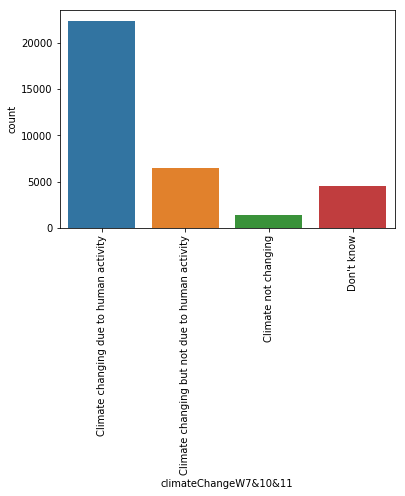

In [10]:
sns.countplot(climateChange);
plt.xticks(rotation=90);
fname = output_subfolder + "climate_change_raw_numbers" + ".png"
plt.savefig( fname, bbox_inches='tight' )

In [11]:
[x for x in BES_Panel.columns if "enviro" in x]

['enviroProtectionW1',
 'enviroProtectionW2',
 'enviroProtectionW3',
 'enviroProtectionW4',
 'enviroGrowthW4',
 'enviroProtectionW6',
 'enviroProtectionW7',
 'enviroGrowthW7',
 'enviroProtectionW12',
 'enviroProtectionW14']

In [21]:
enviroGrowth = amalgamate_waves(BES_Panel, "enviroGrowth")

Amalgamating variables: 
{4: 'enviroGrowthW4', 7: 'enviroGrowthW7'}


In [37]:
enviroGrowth.value_counts().sum()

41264

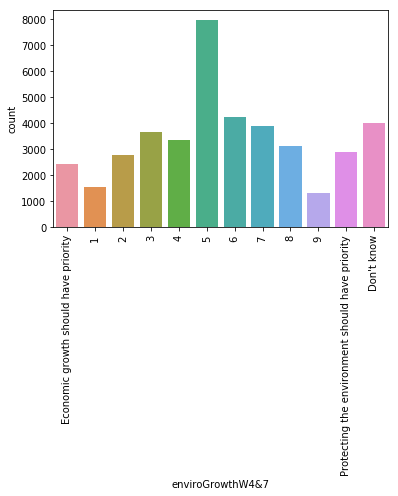

In [26]:
sns.countplot(enviroGrowth);
plt.xticks(rotation=90);
fname = output_subfolder + "enviroGrowth_raw_numbers" + ".png"
plt.savefig( fname, bbox_inches='tight' )

In [23]:
enviroProtection = amalgamate_waves(BES_Panel, "enviroProtection")

Amalgamating variables: 
{1: 'enviroProtectionW1', 2: 'enviroProtectionW2', 3: 'enviroProtectionW3', 4: 'enviroProtectionW4', 6: 'enviroProtectionW6', 7: 'enviroProtectionW7', 12: 'enviroProtectionW12', 14: 'enviroProtectionW14'}


In [39]:
enviroProtection.value_counts()

Not gone far enough           22066
About right                   18841
Not gone nearly far enough    10850
Don't know                     7234
Gone too far                   6560
Gone much too far              2966
Name: enviroProtectionW1&2&3&4&6&7&12&14, dtype: int64

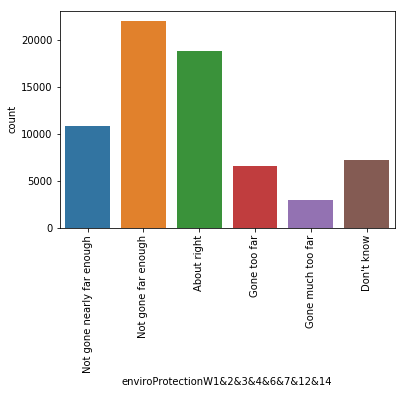

In [27]:
sns.countplot(enviroProtection);
plt.xticks(rotation=90);
fname = output_subfolder + "enviroProtection_raw_numbers" + ".png"
plt.savefig( fname, bbox_inches='tight' )

In [35]:
pd.crosstab(index = climateChange, columns = enviroProtection, normalize='all', margins=True).round(2)

enviroProtectionW1&2&3&4&6&7&12&14,Not gone nearly far enough,Not gone far enough,About right,Gone too far,Gone much too far,Don't know,All
climateChangeW7&10&11,,,,,,,
Climate changing due to human activity,0.14,0.25,0.15,0.04,0.01,0.04,0.64
Climate changing but not due to human activity,0.01,0.03,0.08,0.04,0.02,0.01,0.19
Climate not changing,0.00,0.01,0.02,0.01,0.01,0.00,0.04
Don't know,0.00,0.02,0.04,0.01,0.00,0.04,0.13
All,0.16,0.31,0.29,0.09,0.04,0.10,1.00


In [44]:
enviroProtection_hardcore = (climateChange=="Climate changing due to human activity") & (enviroProtection == "Not gone nearly far enough")
enviroProtection_softcore = (climateChange=="Climate changing due to human activity") & (enviroProtection == "Not gone far enough")

In [279]:
# ep_hardcore_corrs = BES_reduced_with_na[enviroProtection_hardcore|enviroProtection_softcore].corrwith(enviroProtection_hardcore)
# ep_hardcore_corrs.drop([x for x in BES_reduced_with_na.columns if re.match("enviroProtection|climateChange", x)]).dropna().sort_values()

In [278]:
# ep_hardcore_corrs = BES_reduced_with_na.corrwith(enviroProtection_hardcore)
# ep_hardcore_corrs.drop([x for x in BES_reduced_with_na.columns if re.match("enviroProtection|climateChange", x)]).dropna().sort_values()

In [320]:
sample_size_text = "N"
correlation_text = "r"
abs_correlation_text = "abs_r"
p_value_text = "p"
corr_type = "spearman"#"pearson"

top_num = 20
round_places = 2

min_p_value = 0.01
min_variance = 0.0
min_sample_size = 500

pattern = "enviroProtection|climateChange"
name = "enviroProtection_hardcore"

In [321]:
%%time

df1 = BES_reduced_with_na

pattern_list = [x for x in df1.columns if re.match(pattern,x)]
focal_mask = enviroProtection_hardcore.notnull()
variances = df1[focal_mask].var()
low_var_list = list(variances[variances<min_variance].index)
sample_sizes = df1[focal_mask].notnull().sum()
low_sample_size_list = list(sample_sizes[sample_sizes<min_sample_size].index)

drop_list = pattern_list+low_var_list+low_sample_size_list
df1.drop(drop_list,axis=1,inplace=True)

Wall time: 47.2 s


In [322]:
%%time
if corr_type == "pearson":
    df = df1.apply(lambda x: corr_simple_pearsonr(x,enviroProtection_hardcore)).apply(pd.Series)
elif corr_type == "spearman":
    df = df1.apply(lambda x: corr_simple_spearmanr(x,enviroProtection_hardcore)).apply(pd.Series)
    
df.columns = [correlation_text,p_value_text,sample_size_text]
df[sample_size_text] = df[sample_size_text].astype('int')
df[abs_correlation_text] = df[correlation_text].abs()

Wall time: 1min


In [323]:
zero_var_other_way_around_list = list(df[df[correlation_text].isnull()].index)
df.dropna(inplace=True)

insignificant_list = df[df[p_value_text]>min_p_value].index
df.drop(insignificant_list,inplace=True)

df.sort_values(by=abs_correlation_text,ascending=False,inplace=True)
# df=df.round(round_places)

In [324]:
stub_dict = {}
drop_list = []
# drop repeated references to same variable in different waves???
# so, what about different categories??? eg. blahWX_subcat
# how about, just replace wave match as "X"
# create a dictionary keyed on the top corr variable with all the drops inside
for ind in df.index:
    waveless = remove_wave(ind)
    if waveless in stub_dict.keys():
        drop_list.append(ind)
        stub_dict[waveless].append(ind)
    else:
        stub_dict[waveless] = [ind]
df.drop(drop_list,inplace=True)

In [325]:
def display_corr():
    df.index = [x[0:60] for x in df.index]
    df[correlation_text] = df[correlation_text].round(round_places)
    
    df1 = df.sort_values(by=correlation_text, ascending=False)[0:top_num][[correlation_text,p_value_text,sample_size_text]]
    df2 = df.sort_values(by=correlation_text)[0:top_num][[correlation_text,p_value_text,sample_size_text]]
    
    df1[p_value_text]     = df1[p_value_text].apply(lambda x: "{0:0.2f}".format(x))
    df2[p_value_text]     = df2[p_value_text].apply(lambda x: "{0:0.2f}".format(x))
#     df1[[correlation_text,p_value_text]] = df1[[correlation_text,p_value_text]].apply(lambda x: "{0:0.2f}".format(x))
#     df2[[correlation_text,p_value_text]] = df2[[correlation_text,p_value_text]].apply(lambda x: "{0:0.2f}".format(x))

    df1_caption = "Top "+str(top_num)+ " positive "+"("+corr_type+")"+" correlations for "+name
    df2_caption = "Top "+str(top_num)+ " negative "+"("+corr_type+")"+" correlations for "+name

    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption(df1_caption)
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption(df2_caption)

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)


In [326]:
display_corr()

,r,p,N
enviroGrowthW7__Protecting the environment should have prior,0.31,0.00,27820
likeGrnW10__Strongly like,0.3,0.00,26548
likeLucasW10__Strongly like,0.3,0.00,17585
bestPMW10_Jeremy Corbyn,0.3,0.00,18699
ptvGrnW10__Very likely,0.3,0.00,26909
euScepticismW7__Work towards single European government,0.28,0.00,6784
successReduceInequalityGrnW12_Yes,0.28,0.00,6432
competentLucasW13__A great deal of competence,0.26,0.00,10517
euLeaveBigBusinessW10__Much more likely,0.23,0.00,26196
natSecuritySelfW7__Protect civil liberties,0.23,0.00,6593


In [169]:

# var_type.loc["turnoutUKGeneralW1","pruned"]
for ind in df.index:
    print(get_pruned(ind))

ptvGrn
enviroGrowth
likeLucas
euScepticism
likeGrn
ptvGrn
bestPM
ptvGrn
likeLucas
leftRight
likeNuttall
likeGrn
bestPM
approveUKGovt
successReduceInequalityGrn
likeGrn
effectsEUWorkers
ptvGrn
likeLucas
likeGrn
enviroGrowth
likeLucas
bestPM
ptvGrn
approveUKGovt
leftRight
likeGrn
effectsEUWorkers
ptvGrn
competentLucas
likeMay
likeCon
likeMay
competentLucas
natSecuritySpending
likeSEvans
bestPM
handleEUNegotiate
effectsEUEcon
climateChange
leftRight
likeGrn
handleEUNegotiate
likeCon
bestPM
effectsEUEcon
climateChange
ptvGrn
likeMay
conLookAfterBA
handleEUNegotiate
likeCon
euLeaveVoice
likeGrn
euLeaveVoice
keepNukes
leftRight
effectsEUNHS
ptvGrn
keepNukes
handleMIICon
leftRight
al_scale
effectsEUWorkers
likeLucas
al_scale
euPriorityBalance
ptvGrn
generalElectionVoteUnsqueeze
effectsEUNHS
EUIntegrationSelf
ptvGrn
asylumMore
natSecuritySelf
overseasAid
euLeaveVoice
handleMIIGrn
spendLeast
immigSelf
effectsEUNHS
immigrantsWelfareState
likeGrn
ptvCon
effectsEUEcon
ptvCon
euPriorityBalance
like

competentFarron
inequalityChangeLarger
participation
changeNHSLab
efficacyNotUnderstand
responsibleDebtGlobalBanks
labHandleLevelCrime
discrimWomen
negotiationSpecifics_none
tuSupport
satDemEU
resourceAccess
negotiationSpecifics
labHandleNHS
lrLab
ukipFear
profile_newspaper
warmGreece
likeFarron
small_mii_cat
partyContactLab
polAttention
small_mii_cat
efficacyUnderstand
britishness
scotFairShare
lrLD
fbInfo
natSecurityCon
ukCoopTrade
eesEUIntegrationCon
responsibleDebtConservatives
redistCon
efficacyNotUnderstand
populism
coalitionDontDeliver
conPriorities_nhs
bestOnMII
approveScotGovt
mii_cat
EUIntegrationLab
ldUnited
scotElectionVoteConst
partyContactGrn
econGenRetro
partyContact
empathy
mpSecondJob
efficacyNotUnderstand
ukipUnited
resourceAccess
spendMost
lrLD
partyContactOtherParty
grnUnited
small_mii_cat
immigLab
fbInfo
cutsTooFarNHS
achieveReduceImmigCon
discussPolDays
lrLD
euMIISmall
labHandleCostLive
conPartnerUKIP
participation
newspaper
britishness
LRAL_mii_cat
ldTone
busines

noChanceCoalitionPC
spendMost
selfRedistCertain
blameLeave
generalElectionVote
turnoutUKGeneral
partyIdSqueeze
profile_newspaper
econPersonalRetro
labPriorities_costLive
parliamentSupport
ukipPriorities_costLive
ukipPriorities_school
EUIntegrationLD
mii_cat
generalElectionVote
mii_cat
spendMost
euID
partyIdSqueeze
accessJobReference
partyContactOtherParty
immigGreen
ukipPriorities
profile_marital_stat
reasonForVote
partyIdSqueeze
partyId
conPriorities_econ
mii_cat
partyContactCon
dutyToVote
certaintyEUCon
partyIdSqueeze
mapEcon
certaintyEUUKIP
responsibleEducationLD
labUnited
responsibleEducationDontKnow
eesEUIntegrationLD
turnoutUKGeneral
achieveReduceImmigUKIP
discussantVoteName
scotRefExpectation
EUIntegrationUKIP
partyContactOtherParty
mii_cat
ukipPriorities_crime
infoSourceRadio
profile_socgrade
responsibleCostLiveCon
small_mii_cat
generalElectionVoteSqueeze
redistGreen
participation
mii_cat
csplRank
prefTradeoff
profile_sexuality
partyContactLab
blameLeave
participation
scotElect

profile_newspaper
euMIISmall
miilabel
mii_cat
redistLab
LRAL_mii_cat
small_mii_cat
gor
profile_newspaper
polKnowMay
socialDes_dk
ns_sec
gor
profile_past_vote
labAngry
profile_newspaper
profile_newspaper
mii_cat
registered
mii_cat
miilabel
education
EUMIICategory
gor
profile_ethnicity
redistLab
EUMIICategory
likeClegg
mii_cat
profile_religion
singlePartyEffective
miilabel
gor
miilabel
mii_cat
labUnited
fatherCountryBorn
EUMIICategory
euKnow
mii_cat
euroElectionVote
profile_religion
mainSourceIncome
ldUnited
miilabel
euRefTurnoutRetro
belongGroup
labUnited
mii_cat
efficacyPolCare
disability
gor
responsibleEconConservatives
profile_newspaper
schoolKidsInHouse
responsibleImmigDontKnow
gor
mii_cat
mii_cat
small_mii_cat
education
mii_cat
mii_cat
gor
certaintyScotUnion
profile_religion
partyId
gor
bestOnMII
polKnowAssad
noChanceCoalitionLD
labUnited
otherCitizen
mii_cat
generalElectionVote
gor
mii_cat
bestOnMII
achieveReduceImmigLab
ns_sec
education
polKnowMerkel
mii_cat
euKnow
profile_work_t

In [240]:
import six
def render_mpl_table(data, col_width=3.0, row_height=0.325, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(df1, header_columns=0, col_width=2.0);

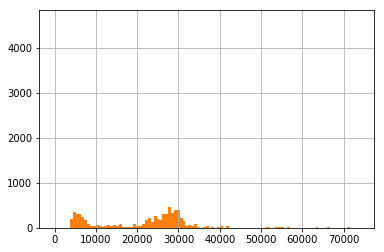

In [123]:
df["p-value"].hist(bins=100)
df["sample size"].hist(bins=100)

In [118]:
df1["blackEquality2W14__Gone much too far"][enviroProtection_hardcore.notnull()].var()
# enviroProtection_hardcore[df1["blackEquality2W14__Gone much too far"].notnull()].var()

1.1621054410934448

In [42]:
pd.crosstab(index = climateChange, columns = enviroGrowth, normalize='index', margins=True).round(2)

enviroGrowthW4&7,Economic growth should have priority,1,2,3,4,5,6,7,8,9,Protecting the environment should have priority,Don't know
climateChangeW7&10&11,,,,,,,,,,,,
Climate changing due to human activity,0.03,0.02,0.05,0.07,0.09,0.20,0.12,0.12,0.10,0.04,0.09,0.07
Climate changing but not due to human activity,0.14,0.08,0.12,0.12,0.09,0.19,0.07,0.06,0.04,0.01,0.02,0.05
Climate not changing,0.20,0.10,0.13,0.11,0.07,0.15,0.04,0.04,0.03,0.02,0.02,0.08
Don't know,0.05,0.04,0.07,0.09,0.06,0.19,0.06,0.05,0.03,0.01,0.02,0.33
All,0.06,0.04,0.07,0.09,0.08,0.20,0.10,0.09,0.08,0.03,0.07,0.10


In [ ]:
## immigSelf distribution by Leave/Remain

In [9]:
[x for x in BES_reduced_with_na.columns if re.match("immigSelf", x)]

['immigSelfW7__Allow many more',
 'immigSelfW8__Allow many more',
 'immigSelfW9__Allow many more',
 'immigSelfW10__Allow many more',
 'immigSelfW11__Allow many more',
 'immigSelfW12__Allow many more',
 'immigSelfW14__Allow many more']

In [54]:
Leavers = BES_Panel["profile_eurefvote"] =="Leave the EU"
Remainers = BES_Panel["profile_eurefvote"] =="Stay/remain in the EU"

In [11]:
amalg_imm = amalgamate_waves(BES_reduced_with_na,"immigSelf",forward_fill=False)
euref_imm = amalgamate_waves(BES_reduced_with_na,"euRefVoteW",forward_fill=False)

In [12]:
amalg_imm.notnull().sum(),euref_imm.notnull().sum()

(56639, 69801)

In [13]:
prof_euref_imm = (BES_Panel["profile_eurefvote"]=="Leave the EU")
prof_euref_imm[BES_Panel["profile_eurefvote"]=="Don't know"] = np.nan

In [14]:
amalg_imm[euref_imm.notnull()].notnull().sum(), amalg_imm[prof_euref_imm.notnull()].notnull().sum()

(55233, 56296)

In [15]:
output_subfolder = BES_output_folder + os.sep + "Immigration_sentiment_by_euref" + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


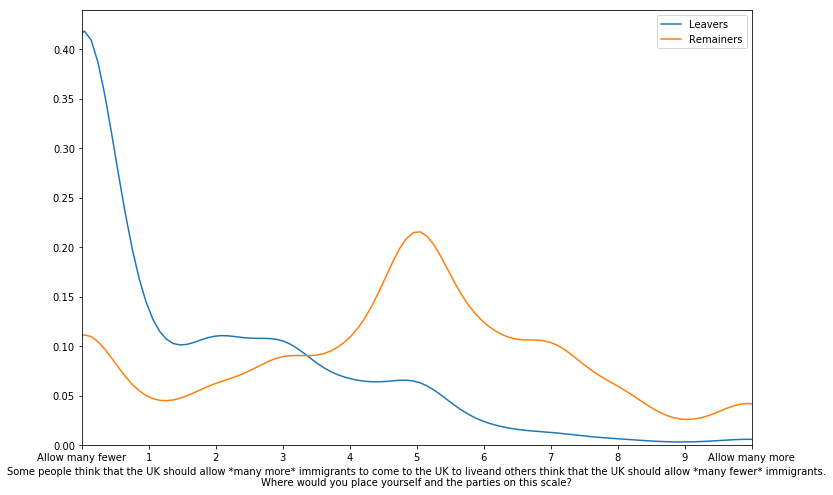

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))

Leave_imm =  amalg_imm[prof_euref_imm==1]
Remainer_imm = amalg_imm[prof_euref_imm==0]

sns.kdeplot(Leave_imm,     label="Leavers", bw=.5, ax = axes);#, cut=1);
sns.kdeplot(Remainer_imm,  label="Remainers", bw=.5, ax = axes);#, cut=1);

# ax.set_ylim([0,.2])
axes.set_xlim([0,10]);
axes.set_xticks(list(range(0,11)))
axes.set_xticklabels(BES_Panel["immigSelfW14"].cat.categories[0:11]);
axes.set_xlabel("Some people think that the UK should allow *many more* immigrants to come to the UK to live"+\
                "and others think that the UK should allow *many fewer* immigrants."+\
                "\nWhere would you place yourself and the parties on this scale?");

fname = output_subfolder + "Immigration_sentiment_by_euref" + ".png"
plt.savefig( fname, bbox_inches='tight' )

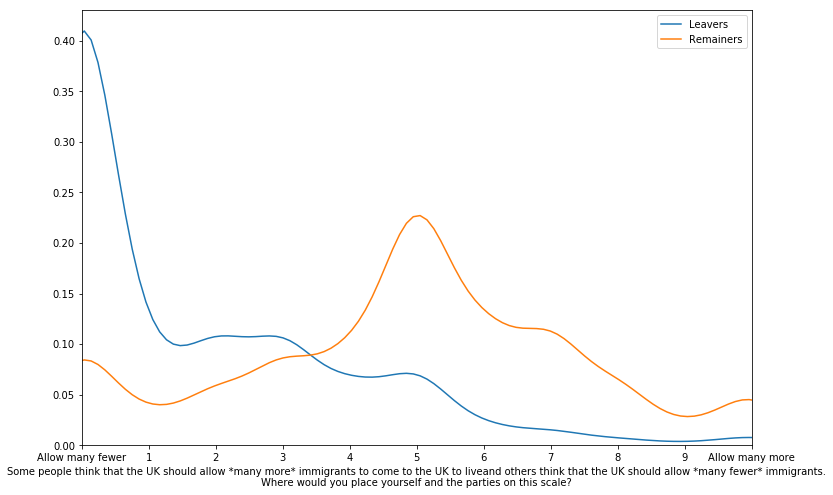

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))

Leave_imm =  amalg_imm[euref_imm==1]
Remainer_imm = amalg_imm[euref_imm==0]

sns.kdeplot(Leave_imm,     label="Leavers", bw=.5, ax = axes);#, cut=1);
sns.kdeplot(Remainer_imm,  label="Remainers", bw=.5, ax = axes);#, cut=1);

# ax.set_ylim([0,.2])
axes.set_xlim([0,10]);
axes.set_xticks(list(range(0,11)))
axes.set_xticklabels(BES_Panel["immigSelfW14"].cat.categories[0:11]);
axes.set_xlabel("Some people think that the UK should allow *many more* immigrants to come to the UK to live"+\
                "and others think that the UK should allow *many fewer* immigrants."+\
                "\nWhere would you place yourself and the parties on this scale?");

# fname = output_subfolder + "Immigration_sentiment_by_euref" + ".png"
# plt.savefig( fname, bbox_inches='tight' )

In [18]:
Leavers   = (BES_Panel['profile_eurefvote'] == "Leave the EU")
Remainers = (BES_Panel['profile_eurefvote'] == "Stay/remain in the EU")
amalgamated_euMIISmall = amalgamate_waves(BES_Panel, 'euMIISmallW', forward_fill=True)


In [ ]:

SovOrImmLeavers = Leavers&amalgamated_euMIISmall.notnull()

Sov = amalgamated_euMIISmall[SovOrImmLeavers]
BES_sov = BES_reduced[SovOrImmLeavers]
drop_vars = [x for x in BES_reduced.columns if ("euRefVote" in x) or ("profile_eurefvote" in x)\
             or ("euMII" in x) or ("EUMII" in x)]
BES_sov = BES_sov.drop(drop_vars , axis=1)


In [20]:
sovereignty = "Sovereignty/EU bureaucracy"
immigration = "Immigration"
Sov = (amalgamated_euMIISmall==sovereignty)
Imm = (amalgamated_euMIISmall==immigration)
Oth = amalgamated_euMIISmall.notnull() & ~Imm & ~Sov


In [24]:
Sov[Leavers].sum(), Imm[Leavers].sum(), Oth[Leavers].sum()

(3933, 3391, 4088)

In [ ]:
economy = "Economy"
cosmopolitanism = "Cosmopolitanism"
Eco = (amalgamated_euMIISmall==sovereignty)
Cos = (amalgamated_euMIISmall==immigration)

In [25]:
amalgamated_euMIISmall[Remainers].value_counts()

Economy                                   3717
Cosmopolitanism                           1190
Foreign policy                             992
Protection of rights                       899
No content to reason                       882
Campaign/outcome fairness                  778
Other                                      606
Immigration                                495
Other stability or uncertainty concern     449
Sovereignty/EU bureaucracy                 410
Social identity/partisanship               330
Family                                     202
EU spending/regulations/cost               197
EU integration/stability                    64
British/english identity                    34
Name: euMIISmallW8, dtype: int64

In [48]:
# cat_col_mar_dict = {} # category-colour-marker dictionary

# colours = cycle('ycmkgbr')
# markers = cycle('v^<>,oD*x+')

def make_categorical_density_plot():
    fig, axes = plt.subplots(1, 1, figsize=(16,10))    
    sov_vars = (BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match(cat_var+"_", x)]][mask&amalg_imm.notnull()]==1)\
                .sum().sort_values(ascending=False)
    sov_vars = sov_vars.drop(sov_vars[sov_vars<min_sample].index)
    if len(sov_vars.index)==0:
        return
    
    for sov in sov_vars.index:
#         if sov not in cat_col_mar_dict.keys(): # try to give mii consistent colour, marker pairs
#             cat_col_mar_dict[sov] = (next(colours),next(markers))        
        sov_imm = amalg_imm[(BES_reduced_with_na[sov]==1.0)&mask]
        base_label = sov.split("_")[-1]

        (col, mar) = get_cat_col_mar(base_label)
        label = base_label +"(N="+str(sov_vars.loc[sov])+")"
        sns.kdeplot(sov_imm,
                    label=label,
                    bw=.5,
                    ax = axes,
                    color = col,
                    marker = mar,
                    alpha = .75);

    sns.kdeplot(amalg_imm,
                label="Everyone-Leaver/Remainer/Neither"+"(N="+str(amalg_imm.notnull().sum())+")",
                bw=.5,
                ax = axes,
                color = 'k',
                linewidth=7.0,
                alpha = .75);       

    # axes.set_ylim([0,.6])
    axes.set_xlim([0,10]);
    axes.set_xticks(list(range(0,11)))
    axes.set_xticklabels(BES_Panel["immigSelfW14"].cat.categories[0:11]);
    axes.set_xlabel("Some people think that the UK should allow *many more* immigrants to come to the UK to live"+\
                    "and others think that the UK should allow *many fewer* immigrants."+\
                    "\nWhere would you place yourself and the parties on this scale?");
    plt.legend(loc='upper right',title=cat_var);
    wave_descr = BES_file_manifest[ (BES_file_manifest["Only_or_Combined"]=="Only")\
                     & (BES_file_manifest["Wave No"]==wave) ]["Friendlier_Description"].values[0]    
    plt.title(question+"\n"\
             +wave_descr\
             +"\n"+subtitle);

    fname = cat_var + "_" + subtitle + ".png"
    plt.savefig( output_subfolder + clean_filename(fname), bbox_inches='tight' )
#     plt.close()

In [49]:
Treatment = "Sovereignty_vs_Immigration"
base_folder = create_subdir(BES_output_folder, Treatment)

sub_treatment = "category_by_immigself"
output_subfolder = create_subdir(base_folder, sub_treatment)

In [47]:
# get_cat_col_mar('immigration')

In [58]:
amalg_imm = amalgamate_waves(BES_reduced_with_na,"immigSelf",forward_fill=False)
masks = {"Leavers":"Leave the EU","Remainers":"Stay/remain in the EU","Don't know":"Don't know"}
# cat_vars = ["euMIISmallW7","euMIISmallW8","EUMIICategoryW7","EUMIICategoryW8"]
# cat_vars = sorted(list(set(["_".join(x.split("_")[:-1]) for x in BES_reduced_with_na.columns if re.match("bestOnMII|miilabel|small_mii_cat|mii_cat|LRAL_mii_cat|EUMIICategory|euMIISmall",x) ])))
cat_vars = sorted(list(set(["_".join(x.split("_")[:-1]) for x in BES_reduced_with_na.columns if re.match("EUMIICategory",x) ])))
min_sample = 100

for cat_var in cat_vars:
    question = "What matters most to you when deciding how to vote in the EU referendum?"
    wave = int(re.search("W(\d+)",cat_var).groups()[0])
    for subtitle,mask_cat in masks.items():
        print(cat_var,subtitle)
        if ("euRefVoteW"+str(wave)) not in BES_Panel.columns:
            mask = (BES_Panel["profile_eurefvote"]==mask_cat)
        else:
            mask = (BES_Panel["euRefVoteW"+str(wave)]==mask_cat)

        make_categorical_density_plot()


EUMIICategoryW7 Leavers
EUMIICategoryW7 Remainers
EUMIICategoryW7 Don't know
EUMIICategoryW8 Leavers
EUMIICategoryW8 Remainers
EUMIICategoryW8 Don't know


In [211]:
lst = ['LRAL_mii_catW1',
 'LRAL_mii_catW10',
 'LRAL_mii_catW11',
 'LRAL_mii_catW12',
 'LRAL_mii_catW13',
 'LRAL_mii_catW2',
 'LRAL_mii_catW3',
 'LRAL_mii_catW4',
 'LRAL_mii_catW5',
 'LRAL_mii_catW6',
 'LRAL_mii_catW7',
 'LRAL_mii_catW8',
 'LRAL_mii_catW9']
sort_by_wave(lst)

['LRAL_mii_catW1',
 'LRAL_mii_catW2',
 'LRAL_mii_catW3',
 'LRAL_mii_catW4',
 'LRAL_mii_catW5',
 'LRAL_mii_catW6',
 'LRAL_mii_catW7',
 'LRAL_mii_catW8',
 'LRAL_mii_catW9',
 'LRAL_mii_catW10',
 'LRAL_mii_catW11',
 'LRAL_mii_catW12',
 'LRAL_mii_catW13']

In [208]:
sorted(list(set(["_".join(x.split("_")[:-1]) for x in BES_reduced_with_na.columns if re.match("bestOnMII|miilabel|small_mii_cat|mii_cat|LRAL_mii_cat|EUMIICategory|euMIISmall",x) ])))

['EUMIICategoryW7',
 'EUMIICategoryW8',
 'LRAL_mii_catW1',
 'LRAL_mii_catW10',
 'LRAL_mii_catW11',
 'LRAL_mii_catW12',
 'LRAL_mii_catW13',
 'LRAL_mii_catW2',
 'LRAL_mii_catW3',
 'LRAL_mii_catW4',
 'LRAL_mii_catW5',
 'LRAL_mii_catW6',
 'LRAL_mii_catW7',
 'LRAL_mii_catW8',
 'LRAL_mii_catW9',
 'bestOnMIIW1',
 'bestOnMIIW10',
 'bestOnMIIW11',
 'bestOnMIIW12',
 'bestOnMIIW13',
 'bestOnMIIW14',
 'bestOnMIIW2',
 'bestOnMIIW3',
 'bestOnMIIW4',
 'bestOnMIIW5',
 'bestOnMIIW6',
 'bestOnMIIW7',
 'bestOnMIIW8',
 'bestOnMIIW9',
 'euMIISmallW7',
 'euMIISmallW8',
 'mii_catW1',
 'mii_catW10',
 'mii_catW11',
 'mii_catW12',
 'mii_catW13',
 'mii_catW2',
 'mii_catW3',
 'mii_catW4',
 'mii_catW5',
 'mii_catW6',
 'mii_catW7',
 'mii_catW8',
 'mii_catW9',
 'miilabelW1',
 'miilabelW2',
 'miilabelW3',
 'miilabelW4',
 'miilabelW5',
 'miilabelW6',
 'small_mii_catW1',
 'small_mii_catW10',
 'small_mii_catW11',
 'small_mii_catW12',
 'small_mii_catW13',
 'small_mii_catW2',
 'small_mii_catW3',
 'small_mii_catW4',
 'smal

In [185]:
list(set([x.split("W")[0] for x in BES_reduced_with_na.columns if "mii" in x.lower()]))

['handleMIILD',
 'handleMIILab',
 'EUMIICategory',
 'bestOnMII',
 'handleMIIGrn',
 'handleMIICon',
 'miilabel',
 'small_mii_cat',
 'LRAL_mii_cat',
 'euMIISmall',
 'mii_cat',
 'handleMIIUKIP']

In [36]:
sov_cols = [x for x in BES_reduced_with_na.columns if "sov" in x.lower()]
BES_reduced_with_na[sov_cols].notnull().sum()

UKsovereigntyW7__Strongly agree            28353
UKsovereigntyW8__Strongly agree            31153
UKsovereigntyPostW10__Strongly agree       26292
UKsovereigntyPostW11__Strongly agree       27411
UKsovereigntyPostW13__Strongly agree       27330
UKsovereigntyPostW14__Strongly agree       26960
EUMIICategoryW7_sovereignty                22599
euMIISmallW7_Sovereignty/EU bureaucracy    21657
EUMIICategoryW8_sovereignty                16181
euMIISmallW8_Sovereignty/EU bureaucracy    15413
dtype: int64

In [46]:
sov_corr = BES_reduced_with_na[Leavers].corrwith(BES_reduced_with_na["EUMIICategoryW7_sovereignty"][Leavers])
sov_corr.dropna().sort_values()

euMIISmallW7_Immigration                                        -0.350165
EUMIICategoryW7_immigration                                     -0.334493
scotIndepJoinEUW1__Very likely                                  -0.206965
scotIndepJoinEUW2__Very likely                                  -0.178561
cooperateRUKGBPW2__Very likely                                  -0.175416
EUMIICategoryW7_democratic deficit                              -0.173026
euMIISmallW7_Campaign/outcome fairness                          -0.171961
euScepticismW7__Work towards single European government         -0.166412
cooperateRUKGBPW1__Very likely                                  -0.161390
polKnowHollandeW10_Prime Minister of Israel                     -0.160128
euMIISmallW7_Economy                                            -0.159556
euMIISmallW8_Immigration                                        -0.154674
snpLookAfterMCW12__Very closely                                 -0.152811
polKnowKerryW10_Secretary General of t

In [44]:
sov_corr[sov_corr.abs()>=.6].dropna().sort_index()

EUIntegrationSelfW10__Protect our independence                  0.655420
EUIntegrationSelfW11__Protect our independence                  0.660549
EUIntegrationSelfW12__Protect our independence                  0.668960
EUIntegrationSelfW13__Protect our independence                  0.653175
EUIntegrationSelfW14__Protect our independence                  0.637818
EUIntegrationSelfW1__Protect our independence                   0.618248
EUIntegrationSelfW3__Protect our independence                   0.644982
EUIntegrationSelfW4__Protect our independence                   0.632688
EUIntegrationSelfW6__Protect our independence                   0.629332
EUIntegrationSelfW7__Protect our independence                   0.687578
EUIntegrationSelfW8__Protect our independence                   0.671564
EUIntegrationSelfW9__Protect our independence                   0.654135
UKsovereigntyW7__Strongly agree                                 1.000000
UKsovereigntyW8__Strongly agree                    

In [56]:
sov_corr = BES_reduced_with_na[Remainers].corrwith(BES_reduced_with_na["euMIISmallW7_Protection of rights"][Remainers])
sov_corr.dropna().sort_values()

polKnowAssadW10_President of Syria              -0.485071
effectsEUWorkersW7__Much better                 -0.254117
leftRightW11__Right                             -0.250966
govtHandleEconW1__Very well                     -0.247156
happyScotIndepResultNoW2__Extremely happy       -0.245585
approveUKGovtW7__Strongly approve               -0.245244
leftRightW13__Right                             -0.244588
approveUKGovtW10__Strongly approve              -0.243639
approveUKGovtW11__Strongly approve              -0.243500
leftRightW7__Right                              -0.242571
leftRightW10__Right                             -0.241563
leftRightW14__Right                             -0.240772
likeConW10__Strongly like                       -0.240174
likeMayW11__Strongly like                       -0.240066
leftRightW9__Right                              -0.239517
approveUKGovtW3__Strongly approve               -0.239454
approveUKGovtW2__Strongly approve               -0.239351
leftRightW12__

In [57]:
sov_corr = BES_reduced_with_na[Remainers].corrwith(BES_reduced_with_na["euMIISmallW7_Cosmopolitanism"][Remainers])
sov_corr.dropna().sort_values()

polKnowNetanyahuW10_Prime Minister of Israel                   -0.323077
euMIISmallW7_Economy                                           -0.243396
EUIntegrationSelfW3__Protect our independence                  -0.181924
EUIntegrationSelfW1__Protect our independence                  -0.180304
EUIntegrationSelfW7__Protect our independence                  -0.176617
EUIntegrationSelfW4__Protect our independence                  -0.175497
approveEUW2_Disapprove                                         -0.168590
EUIntegrationSelfW2__Protect our independence                  -0.168480
EUMIICategoryW7_economy general                                -0.163660
EUIntegrationSelfW8__Protect our independence                  -0.162372
EUIntegrationSelfW6__Protect our independence                  -0.154300
EUIntegrationSelfW12__Protect our independence                 -0.151779
britishnessW12__Very strongly British                          -0.150780
EUIntegrationSelfW13__Protect our independence     

In [60]:
[x for x in BES_reduced_with_na.columns if "climate" in x.lower()]

['climateChangeW7__Climate not changing',
 'climateChangeW10__Climate not changing',
 'climateChangeW11__Climate not changing']

In [61]:
amalg_climate = amalgamate_waves(BES_reduced_with_na,"climateChangeW",forward_fill=False)

In [63]:
corr_climate = BES_reduced_with_na.corrwith(amalg_climate, drop=True)

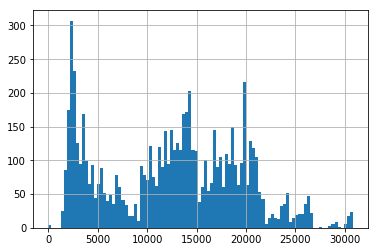

In [64]:
sample_sizes = BES_reduced_with_na[amalg_climate.notnull()].notnull().sum()
sample_sizes.hist(bins=100)

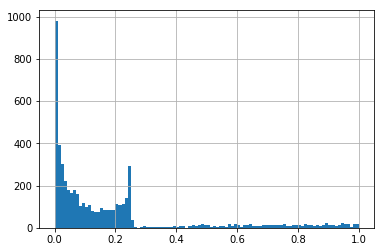

In [72]:
sample_vars = BES_reduced_with_na[amalg_climate.notnull()].var()
sample_vars[sample_vars<=1].hist(bins=100)

In [78]:
low_sample_variance = list(sample_vars[sample_vars<0.01].index)

In [77]:
low_sample_size = list(sample_sizes[sample_sizes<1000].index)

In [67]:
BES_reduced_with_na.shape

(73703, 6864)

In [82]:
corr_climate.drop(low_sample_variance+low_sample_size,errors='ignore').sort_values(ascending=False)

climateChangeW7__Climate not changing                              1.000000
climateChangeW10__Climate not changing                             0.962151
climateChangeW11__Climate not changing                             0.781685
enviroProtectionW3__Gone much too far                              0.454197
enviroProtectionW6__Gone much too far                              0.445071
enviroProtectionW7__Gone much too far                              0.437493
enviroProtectionW2__Gone much too far                              0.434092
enviroProtectionW12__Gone much too far                             0.431481
enviroProtectionW4__Gone much too far                              0.424973
enviroProtectionW1__Gone much too far                              0.411995
enviroProtectionW14__Gone much too far                             0.377303
happyTrumpW10__Extremely happy                                     0.357372
likeNuttallW10__Strongly like                                      0.355601
ptvUKIPW8__V

In [83]:
corr_df_reduced = BES_reduced_with_na.corr(min_periods=100)

In [84]:
import datetime
datetime.datetime.now()

datetime.datetime(2018, 12, 6, 7, 13, 36, 141473)

In [87]:
corr_df.to_msgpack(data_subfolder+"corr_df_reduced.msgpack")

In [86]:
data_subfolder

'../BES_analysis_data/W14_comb\\'

In [88]:
corr_df

,ageW1,turnoutUKGeneralW1__Very likely that I will vote,turnoutUKGeneralW2__Very likely that I will vote,turnoutUKGeneralW3__Very likely that I will vote,turnoutUKGeneralW4__Very likely that I will vote,turnoutUKGeneralW5__Very likely that I will vote,turnoutUKGeneralW7__Very likely that I will vote,turnoutUKGeneralW8__Very likely that I will vote,turnoutUKGeneralW9__Very likely that I will vote,turnoutUKGeneralW10__Very likely that I will vote,...,partyContactLD_4W2_Yes,successReduceInequalityConW12_Yes,bestPMW12_Jeremy Corbyn,partyContactUKIP_3W2_Yes,partyContactUKIP_4W2_Yes,successReduceInequalityUKIPW12_Yes,partyContactUKIP_5W2_Yes,partyContactLDW12_Yes,partyContactLabW12_Yes,partyContactConW12_Yes
ageW1,1.000000,0.197255,0.188298,0.176491,0.165196,0.129728,0.140742,0.130841,0.106640,0.121050,...,0.008540,0.074831,-0.246893,-0.005263,0.003654,0.038569,0.059558,0.007367,-0.050679,0.123966
turnoutUKGeneralW1__Very likely that I will vote,0.197255,1.000000,0.764198,0.759795,0.722853,0.690068,0.658385,0.644661,0.575628,0.637073,...,-0.011803,-0.008027,0.004161,0.015625,-0.030387,-0.002910,0.045551,0.007479,-0.019289,0.035658
turnoutUKGeneralW2__Very likely that I will vote,0.188298,0.764198,1.000000,0.796294,0.749522,0.719718,0.690232,0.668758,0.593488,0.656597,...,0.002412,0.005912,0.011041,-0.003251,-0.019684,-0.006306,0.037717,0.010191,-0.004709,0.032820
turnoutUKGeneralW3__Very likely that I will vote,0.176491,0.759795,0.796294,1.000000,0.777261,0.722657,0.695322,0.678343,0.597681,0.666059,...,0.006367,0.010398,-0.012647,-0.004976,0.000722,0.010162,0.042553,0.010656,-0.005079,0.034747
turnoutUKGeneralW4__Very likely that I will vote,0.165196,0.722853,0.749522,0.777261,1.000000,0.815531,0.713893,0.702592,0.624421,0.676428,...,0.011286,0.037329,-0.000632,0.022456,-0.008737,0.012661,0.024935,0.009404,-0.003206,0.040379
turnoutUKGeneralW5__Very likely that I will vote,0.129728,0.690068,0.719718,0.722657,0.815531,1.000000,0.728354,0.718490,0.642236,0.679955,...,-0.000652,0.040261,0.020196,-0.002992,-0.027304,0.007676,0.025247,0.014554,-0.004100,0.011847
turnoutUKGeneralW7__Very likely that I will vote,0.140742,0.658385,0.690232,0.695322,0.713893,0.728354,1.000000,0.833607,0.726400,0.767871,...,0.006122,0.020414,0.022934,0.014805,-0.010644,0.003176,0.032908,0.025868,-0.014425,0.009854
turnoutUKGeneralW8__Very likely that I will vote,0.130841,0.644661,0.668758,0.678343,0.702592,0.718490,0.833607,1.000000,0.734659,0.759694,...,-0.003978,0.012627,0.017395,0.000140,-0.002534,-0.008324,0.017291,0.021936,-0.013938,0.017731
turnoutUKGeneralW9__Very likely that I will vote,0.106640,0.575628,0.593488,0.597681,0.624421,0.642236,0.726400,0.734659,1.000000,0.719565,...,0.005411,0.023388,0.022219,-0.016361,-0.003391,-0.010991,0.022036,0.010486,-0.001877,0.011632
turnoutUKGeneralW10__Very likely that I will vote,0.121050,0.637073,0.656597,0.666059,0.676428,0.679955,0.767871,0.759694,0.719565,1.000000,...,0.021715,0.032787,0.014077,0.004478,0.005572,-0.002113,0.030815,0.008992,0.000035,0.009162


In [71]:
gc.collect()

35093